# Image + Text only Branches
<style>
h2: color:blue;
</style>

### Here we are only testing the image only, text only 2D, and text only 1D

# Section 0: Import modules, set variables, load functions 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from keras import backend as K
from sklearn.metrics import confusion_matrix    
from sklearn import metrics
from keras.models import Model
from keras.layers import Dense, Reshape, concatenate, Lambda, Average, Maximum, Add, Multiply, Concatenate, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers.embeddings import Embedding
from keras.engine.input_layer import Input
from keras.optimizers import Adam
from utils import *
from keras.activations import relu
from sklearn.model_selection import StratifiedKFold
import random
import dill
import matplotlib.pyplot as plt
from scipy import ndimage
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from PIL import Image
import io
from keras.utils.training_utils import multi_gpu_model
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
G = len(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1']


In [3]:
SRC = 'PMC'

if SRC=='PMC':
    CLASSES = {0: 'bar', 1: 'gel', 2: 'map', 3: 'network', 4: 'plot',
             5: 'text', 6: 'box', 7: 'heatmap',8: 'medical', 9: 'nxmls', 10: 'screenshot',
             11: 'topology', 12: 'diagram', 13: 'histology', 14: 'microscopy',
             15: 'photo', 16: 'sequence', 17: 'tree', 18: 'fluorescence', 19: 'line',
             20: 'molecular', 21: 'pie', 22: 'table'}
    
    class_names = ['bar', 'gel', 'network', 'plot', 'histology', 'sequence',
                               'line', 'molecular']
else:
    class_names = ['cat','dog']
num_class = len(class_names)
NN_Class_Names = dict(enumerate(class_names))
test_size = 0.2
epochs = 150
bs = 128
#Set parameters
create_word_vec = False
w2v_epochs = 20
w2v_window_size=5
w2v_filters=''
seed = 0
max_text_len = 200
vocabulary_size = 10000
csv_fname = 'image_list.csv'
coco_loc = '/home/kevin/Documents/Lab/coco_dataset'
pmc_loc = '/gpfs/ysm/pi/krauthammer/kl533/'
filters = ''
use_glove = False
LOAD_IMG_MODEL_WEIGHTS = False
LOAD_TXT_MODEL_WEIGHTS = False
CHANNELS = 3#should be either 3 or 1 for the number of channels
shape = (100,100,CHANNELS)#image shape
embedding_output_dim = 100
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None)
nltk.download('punkt')
nltk.download('stopwords')
plt.rcParams["figure.dpi"] = 600
n_splits=5

[nltk_data] Downloading package punkt to /home/kl533/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kl533/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Section 1: Initalize variables and load data

In [4]:
# Load our data from source

print('Getting Data')
if SRC == 'PMC':
    image_classes = [list(CLASSES.keys())[list(CLASSES.values()).index(x)] for 
                 x in class_names]  
    data = load_PMC(csv_fname, image_classes, uniform=True)
    #dynamically add location of files
    data['location'] = pmc_loc + data['location'].astype(str)
else:
    data = load_COCO(coco_loc, class_names=class_names)

Getting Data


## Optional: Create embeddings

In [5]:
#%%Section 0.5 create embeddings - Optional
if create_word_vec:
    print('Section 0.5: create embeddings')
    from w2v_keras import w2v_keras
    w2v = w2v_keras(vocabulary_size=vocabulary_size, window_size=w2v_window_size, filters=w2v_filters, vector_dim = embedding_output_dim)
    w2v.fit(data['caption'], epochs=w2v_epochs)
    w2v.save_embeddings('w2v_embeddings.json')
else:
    print("Not creating embeddings")

Not creating embeddings


In [6]:
def Generate_Model(model_type = None):
    #set up our text input
    if model_type == "image":#image only
        image_input = Input(shape, name='image_input')
        x = get_img_branch()(image_input)
        x = Dense(1024, activation='relu', name='dense_layer1_image')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)        
        x = Dense(512, activation='relu', name='dense_layer2_image')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        output = Dense(num_class, activation='softmax', name='image_output')(x)
        classificationModel = Model(inputs=[image_input], outputs=[output])
    if model_type == "text_1d":#text_1d only
        input_text = Input(shape=(max_text_len,), name='text_input')
        embedding = Embedding(input_length=max_text_len, input_dim=vocabulary_size, output_dim=embedding_output_dim, 
                               name='embedding_layer', trainable=False, weights=[embedding_weights])
        embedded_text = embedding(input_text)
        x = get_text_branch()(embedded_text)
        x = Dense(1024, activation='relu', name='dense_layer1_text')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)        
        x = Dense(512, activation='relu', name='dense_layer2_text')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        output = Dense(num_class, activation='softmax', name='text_output')(x)
        classificationModel = Model(inputs=[input_text], outputs=[output])
    if model_type == "text_2d":
        input_text = Input(shape=(max_text_len,), name='text_input')
        embedding = Embedding(input_length=max_text_len, input_dim=vocabulary_size, output_dim=embedding_output_dim, 
                               name='embedding_layer', trainable=False, weights=[embedding_weights])
        embedded_text = embedding(input_text)
        #text_embedding = Reshape((max_text_len,shape[0],1))(embedded_text)
        text_embedding = Lambda(embedding_3Ch)(embedded_text)
        x = get_img_branch()(text_embedding)
        x = Dense(1024, activation='relu', name='dense_layer1')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)        
        x = Dense(512, activation='relu', name='dense_layer2')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        output = Dense(num_class, activation='softmax', name='text_output')(x)
        classificationModel = Model(inputs=[input_text], outputs=[output])
    if G > 1:
        classificationModel = get_multi_gpu_model(classificationModel, G)
    return classificationModel

## Lets visualize our models:

In [ ]:
G_bak = G
G = 1
image_vis = Generate_Model(model_type = "image")
text_1d_vis = Generate_Model(model_type = 'text_1d')
text_2d_vis = Generate_Model(model_type = 'text_2d')

G = G_bak
base_model_list = {'image_vis': image_vis, 
                   'text_1d_vis': text_1d_vis,
                  'text_2d_vis' : text_2d_vis}
plt.rcParams["figure.dpi"] = 600


fig,ax = plt.subplots(len(base_model_list),1)
for i, (name,model) in enumerate(base_model_list.items()):
    x = model_to_dot(model)
    x.set_dpi(600)
    x = x.create(prog='dot', format='png')
    x_ = plt.imread(io.BytesIO(x))
    x_ = ndimage.rotate(x_, 90)
    ax[i].imshow(x_)
    ax[i].axis("off")
    ax[i].set_title(name)

# Section 2: K-Fold Validation

### Get data into format our model understands

In [7]:
#Get all data to kfoldsplit
X_text, X_image, y, tokenizer = get_model_data(data, seed=seed, test_size = test_size, 
                vocabulary_size = vocabulary_size, filters = filters, 
                max_text_len=max_text_len, shape=shape, split=True)
X_text = np.array(X_text)#need to fix this!!!!!!!!!!!!!!!!!!!!!!!!!!!

filtering sentences
filtering sents and removing stopwords
filtering sentences
filtering sents and removing stopwords


/home/kl533/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Load our word embeddings

In [8]:
#%% Section 1.5: Load word embeddings
if use_glove:
    embedding_weights = load_glove('/home/kevin/Downloads', 
                        take(vocabulary_size, tokenizer.word_index.items()))
elif create_word_vec:#get weights from w2v model directly if trained.
    embedding_weights = mapTokensToEmbedding(w2v.get_embeddings(), 
                                             tokenizer.word_index, vocabulary_size)
else:
    #load embedding weights from file
    location = 'w2v_embeddings.json'
    import json
    with open(location) as f:
        embs = json.load(f)
        emb = json.loads(embs)
    embedding_weights = mapTokensToEmbedding(emb, tokenizer.word_index, 
                                             vocabulary_size)

### Generate our K-Folds and save them to be used by other files

In [9]:
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
folds = {}
count = 1
for train, test in kfold.split(np.zeros(len(y)), y.argmax(1)):
    folds['fold_{}'.format(count)] = {}
    folds['fold_{}'.format(count)]['train'.format(count)] = train.tolist()
    folds['fold_{}'.format(count)]['test'.format(count)] = test.tolist()
    count += 1
print(len(folds) == n_splits)#assert we have the same number of splits
#dump folds to json
import json
with open('folds.json', 'w') as fp:
    json.dump(folds, fp)


True


In [10]:
#load to dict to be used
with open('folds.json') as f:
    kfolds = json.load(f)
print(kfolds == folds)

True


### K fold validation on images only

fold_1
K-: fold_1
Samples from Training
[   0    2 3141 3142]


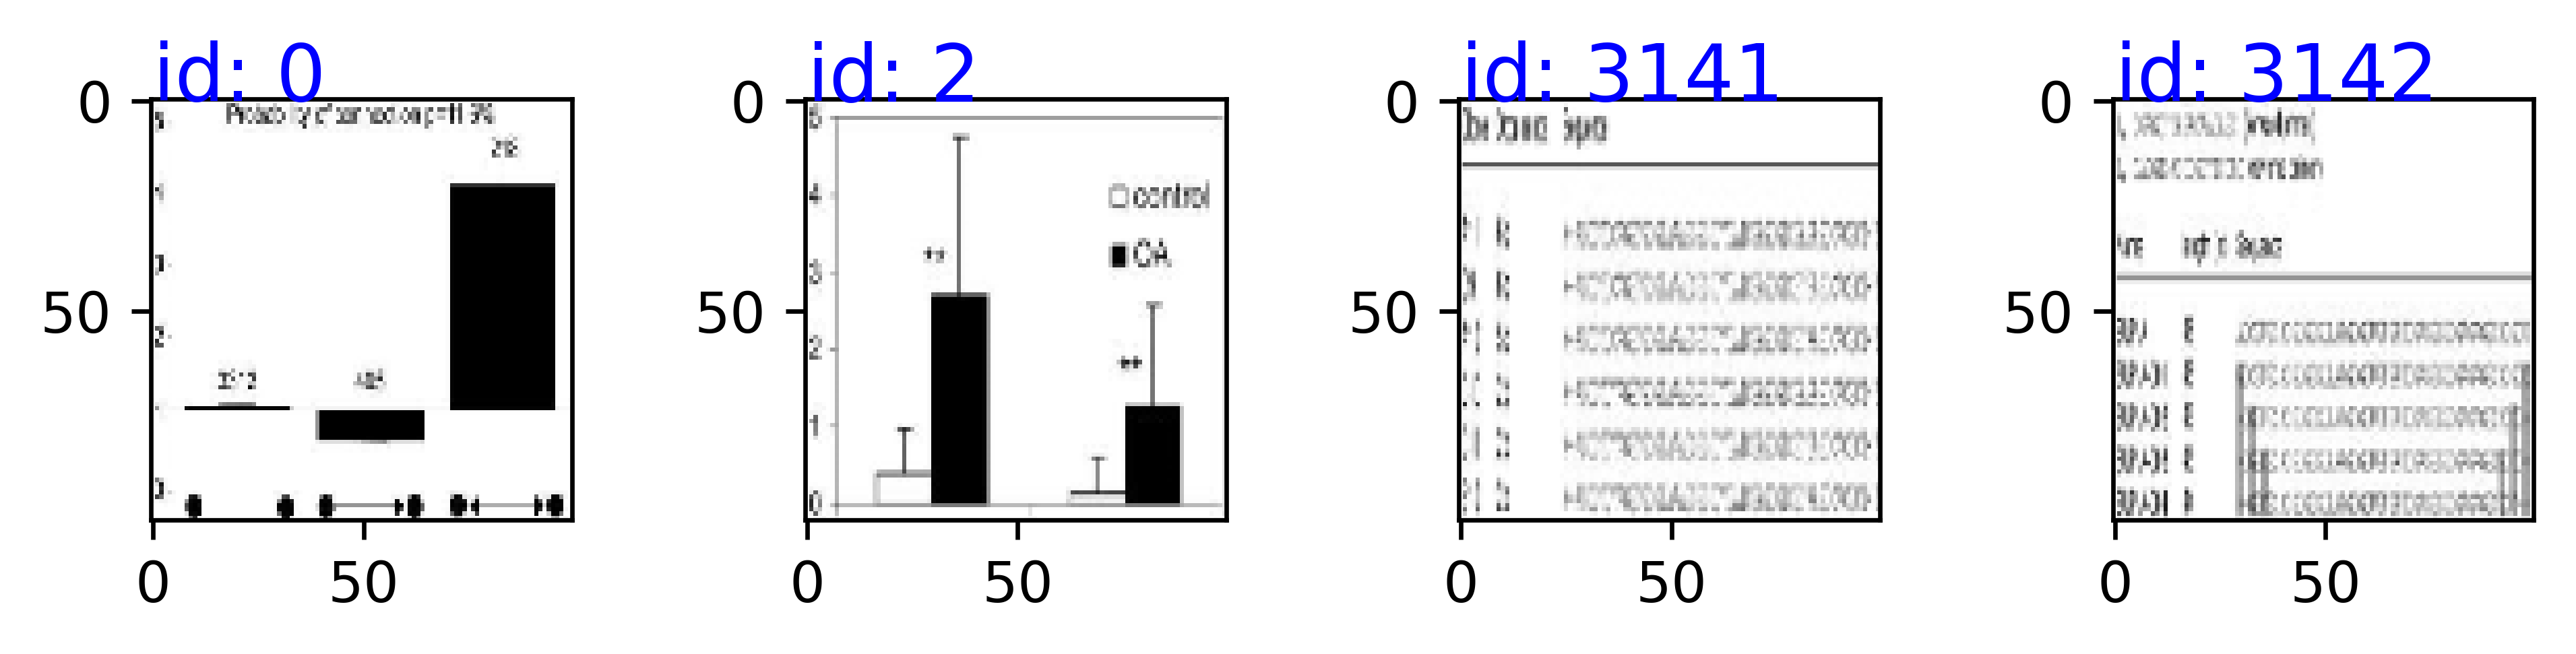

Samples from Testing
[   1    5 3139 3143]


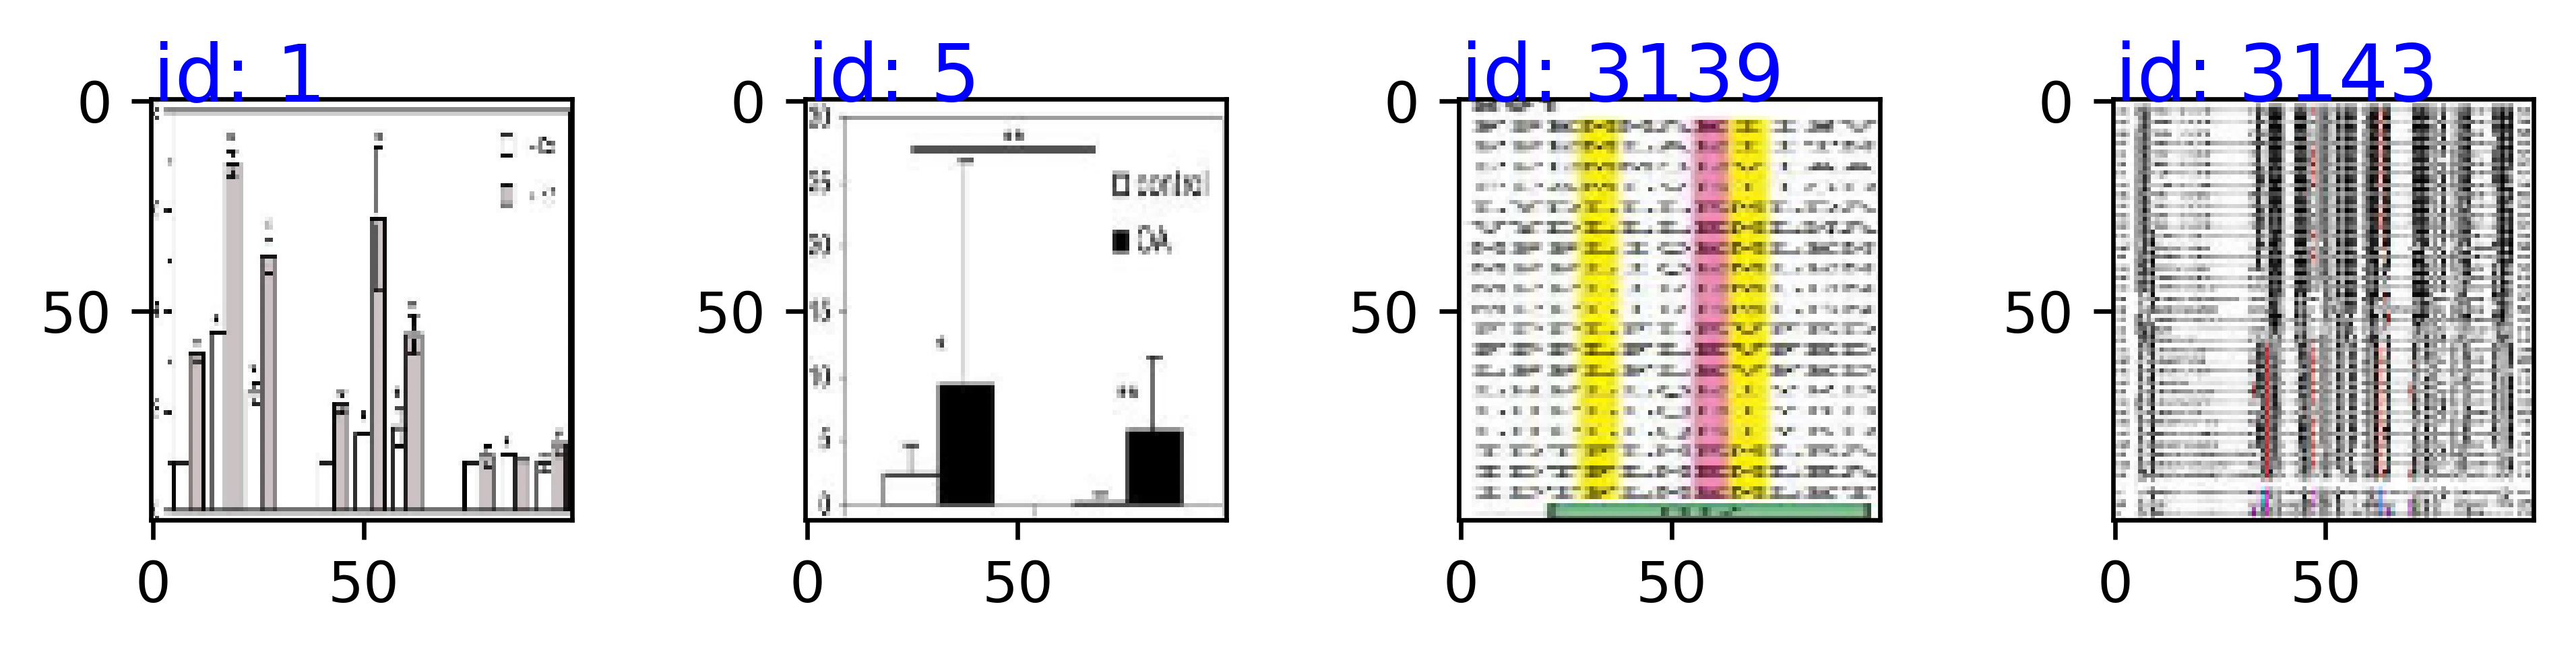

[INFO] training with 2 GPUs...
Train on 2260 samples, validate on 252 samples
Epoch 1/150
2260/2260 [==============================] - 9s 4ms/step - loss: 2.3560 - acc: 0.3438 - val_loss: 2.8071 - val_acc: 0.3730

Epoch 00001: val_acc improved from -inf to 0.37302, saving model to unimodal_weights/best_weight_image_only_k-fold_1.hdf5
Epoch 2/150
2260/2260 [==============================] - 2s 1ms/step - loss: 1.8398 - acc: 0.4602 - val_loss: 2.5625 - val_acc: 0.4444

Epoch 00002: val_acc improved from 0.37302 to 0.44444, saving model to unimodal_weights/best_weight_image_only_k-fold_1.hdf5
Epoch 3/150
2260/2260 [==============================] - 2s 1ms/step - loss: 1.4297 - acc: 0.5447 - val_loss: 2.5103 - val_acc: 0.4762

Epoch 00003: val_acc improved from 0.44444 to 0.47619, saving model to unimodal_weights/best_weight_image_only_k-fold_1.hdf5
Epoch 4/150
2260/2260 [==============================] - 3s 1ms/step - loss: 1.1734 - acc: 0.6296 - val_loss: 1.7877 - val_acc: 0.5635

Epoch 

2260/2260 [==============================] - 2s 1ms/step - loss: 0.0104 - acc: 0.9982 - val_loss: 0.7254 - val_acc: 0.8294

Epoch 00037: val_acc did not improve from 0.83333
Epoch 38/150
2260/2260 [==============================] - 2s 1ms/step - loss: 0.0119 - acc: 0.9973 - val_loss: 0.7084 - val_acc: 0.8333

Epoch 00038: val_acc improved from 0.83333 to 0.83333, saving model to unimodal_weights/best_weight_image_only_k-fold_1.hdf5
Epoch 39/150
2260/2260 [==============================] - 2s 1ms/step - loss: 0.0117 - acc: 0.9978 - val_loss: 0.7075 - val_acc: 0.8373

Epoch 00039: val_acc improved from 0.83333 to 0.83730, saving model to unimodal_weights/best_weight_image_only_k-fold_1.hdf5
Epoch 40/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.0097 - acc: 0.9991 - val_loss: 0.6940 - val_acc: 0.8413

Epoch 00040: val_acc improved from 0.83730 to 0.84127, saving model to unimodal_weights/best_weight_image_only_k-fold_1.hdf5
Epoch 41/150
2260/2260 [================

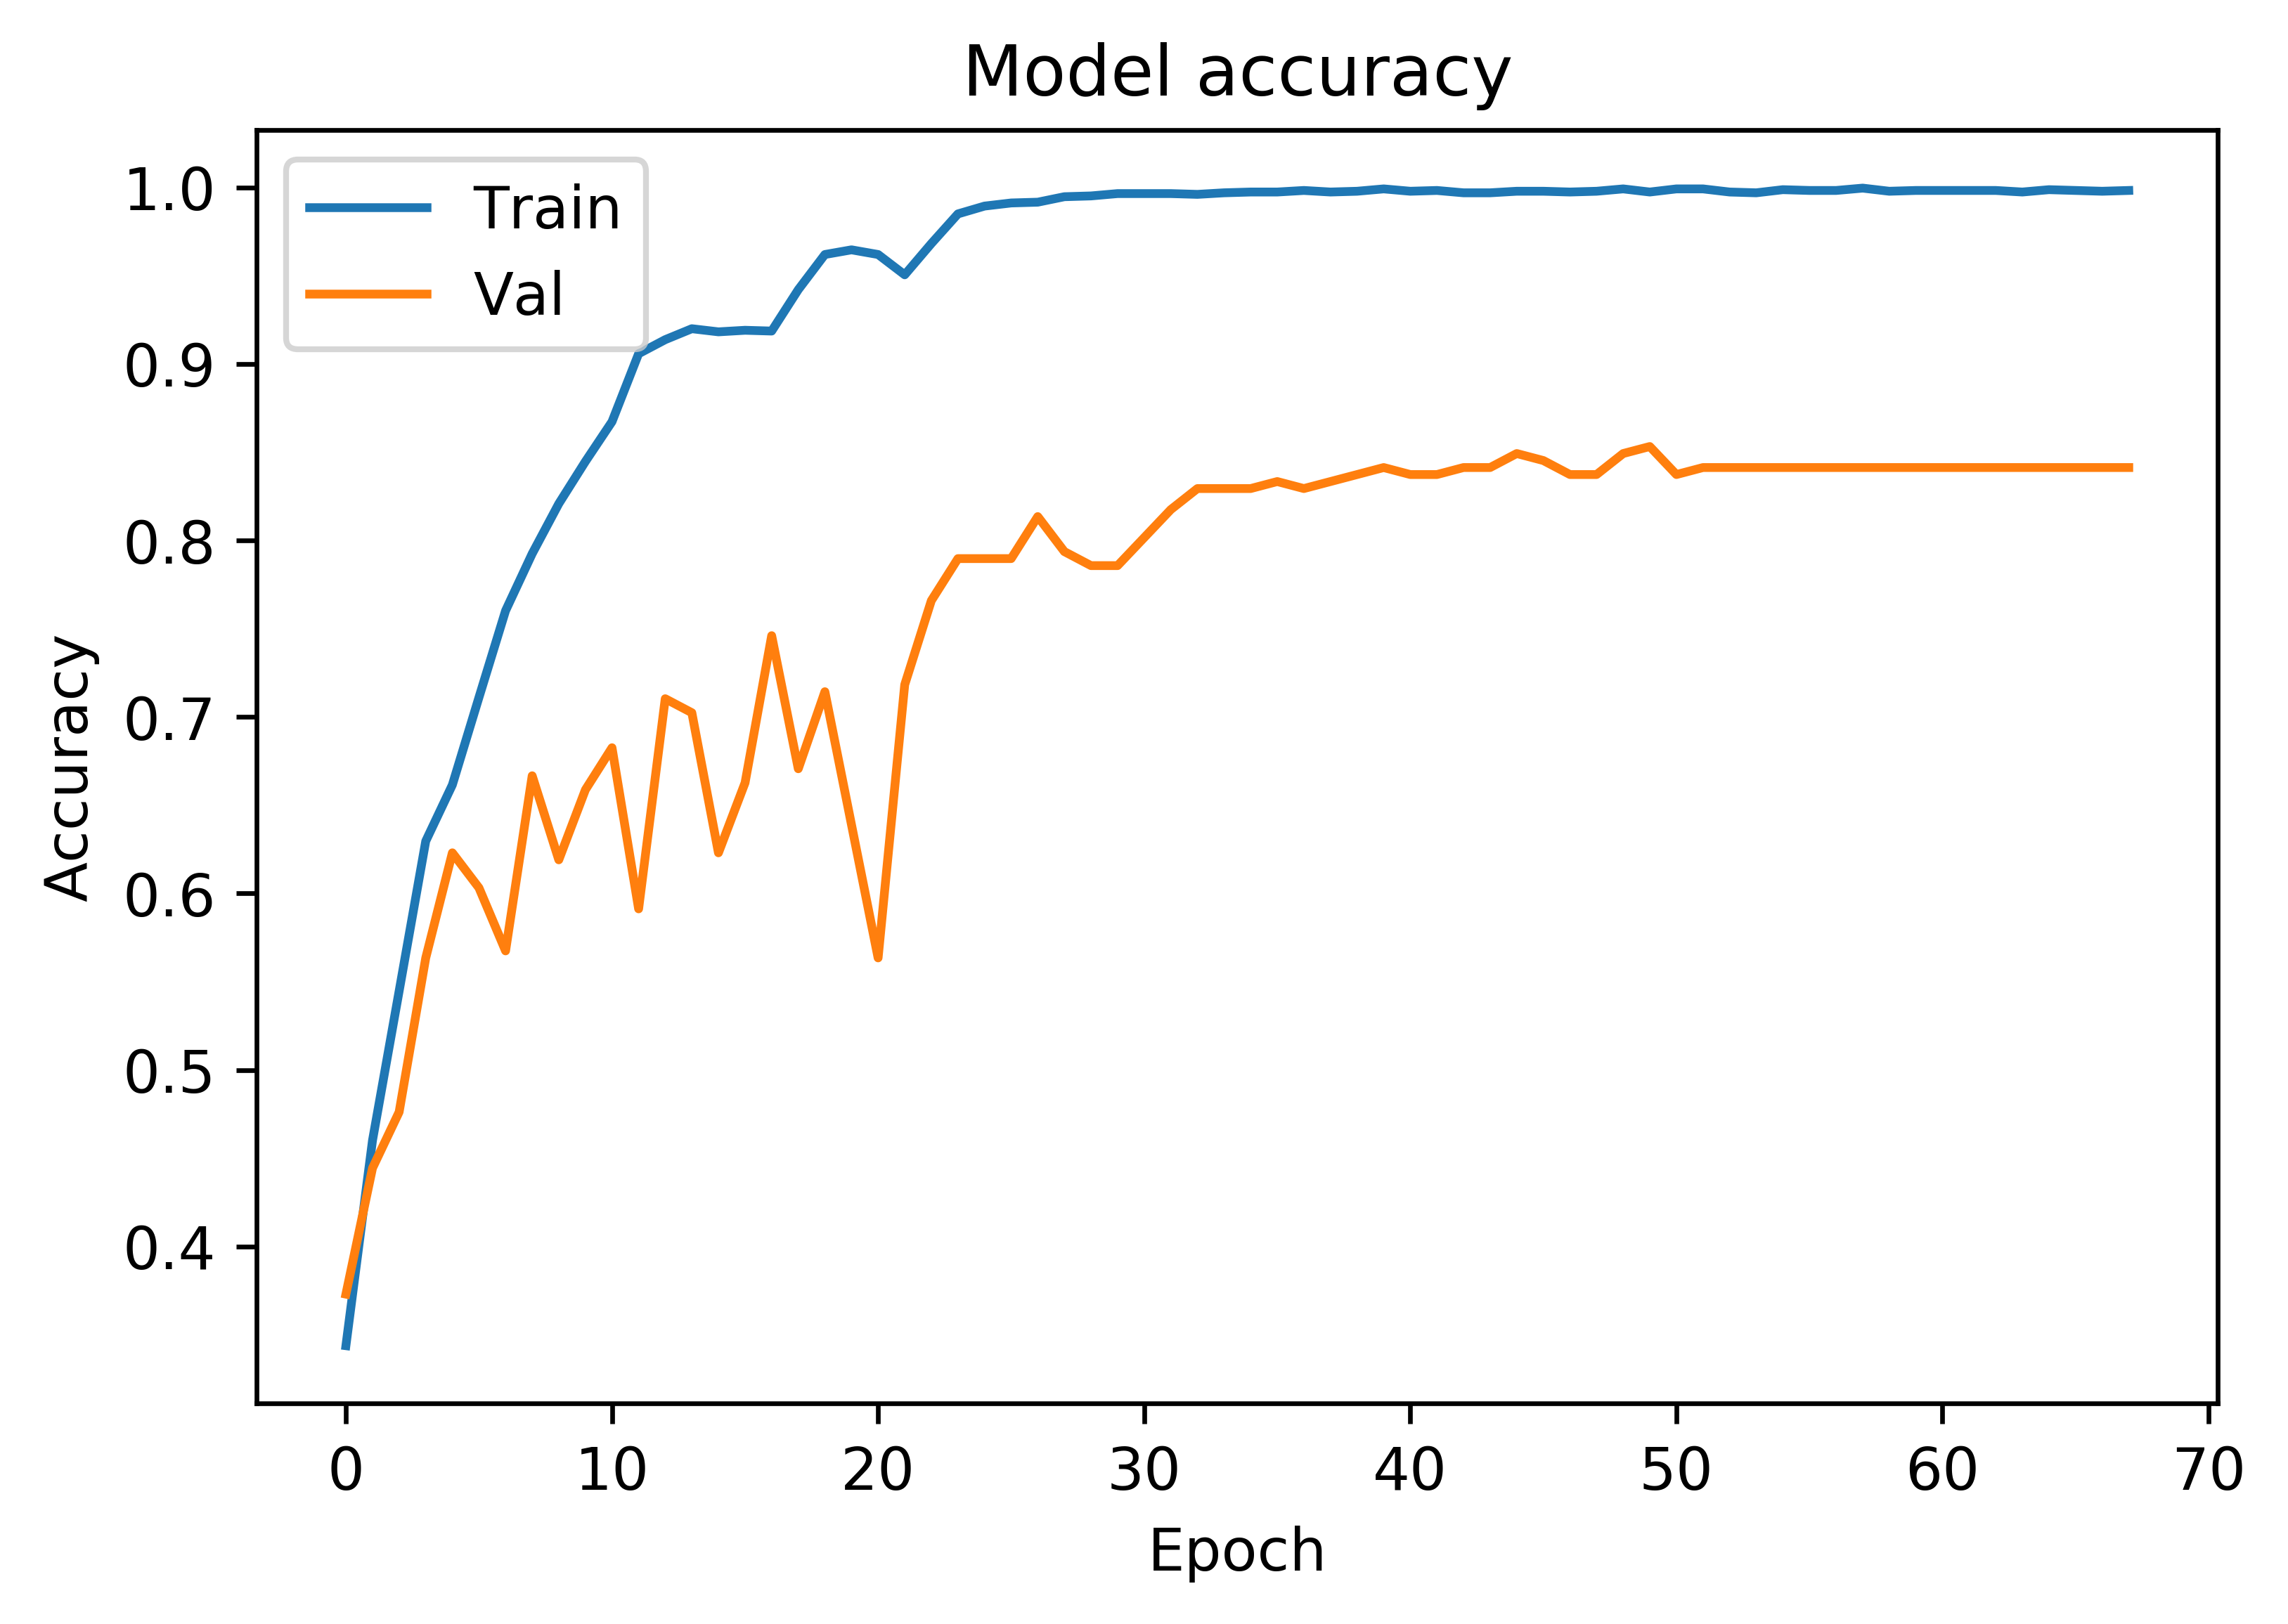

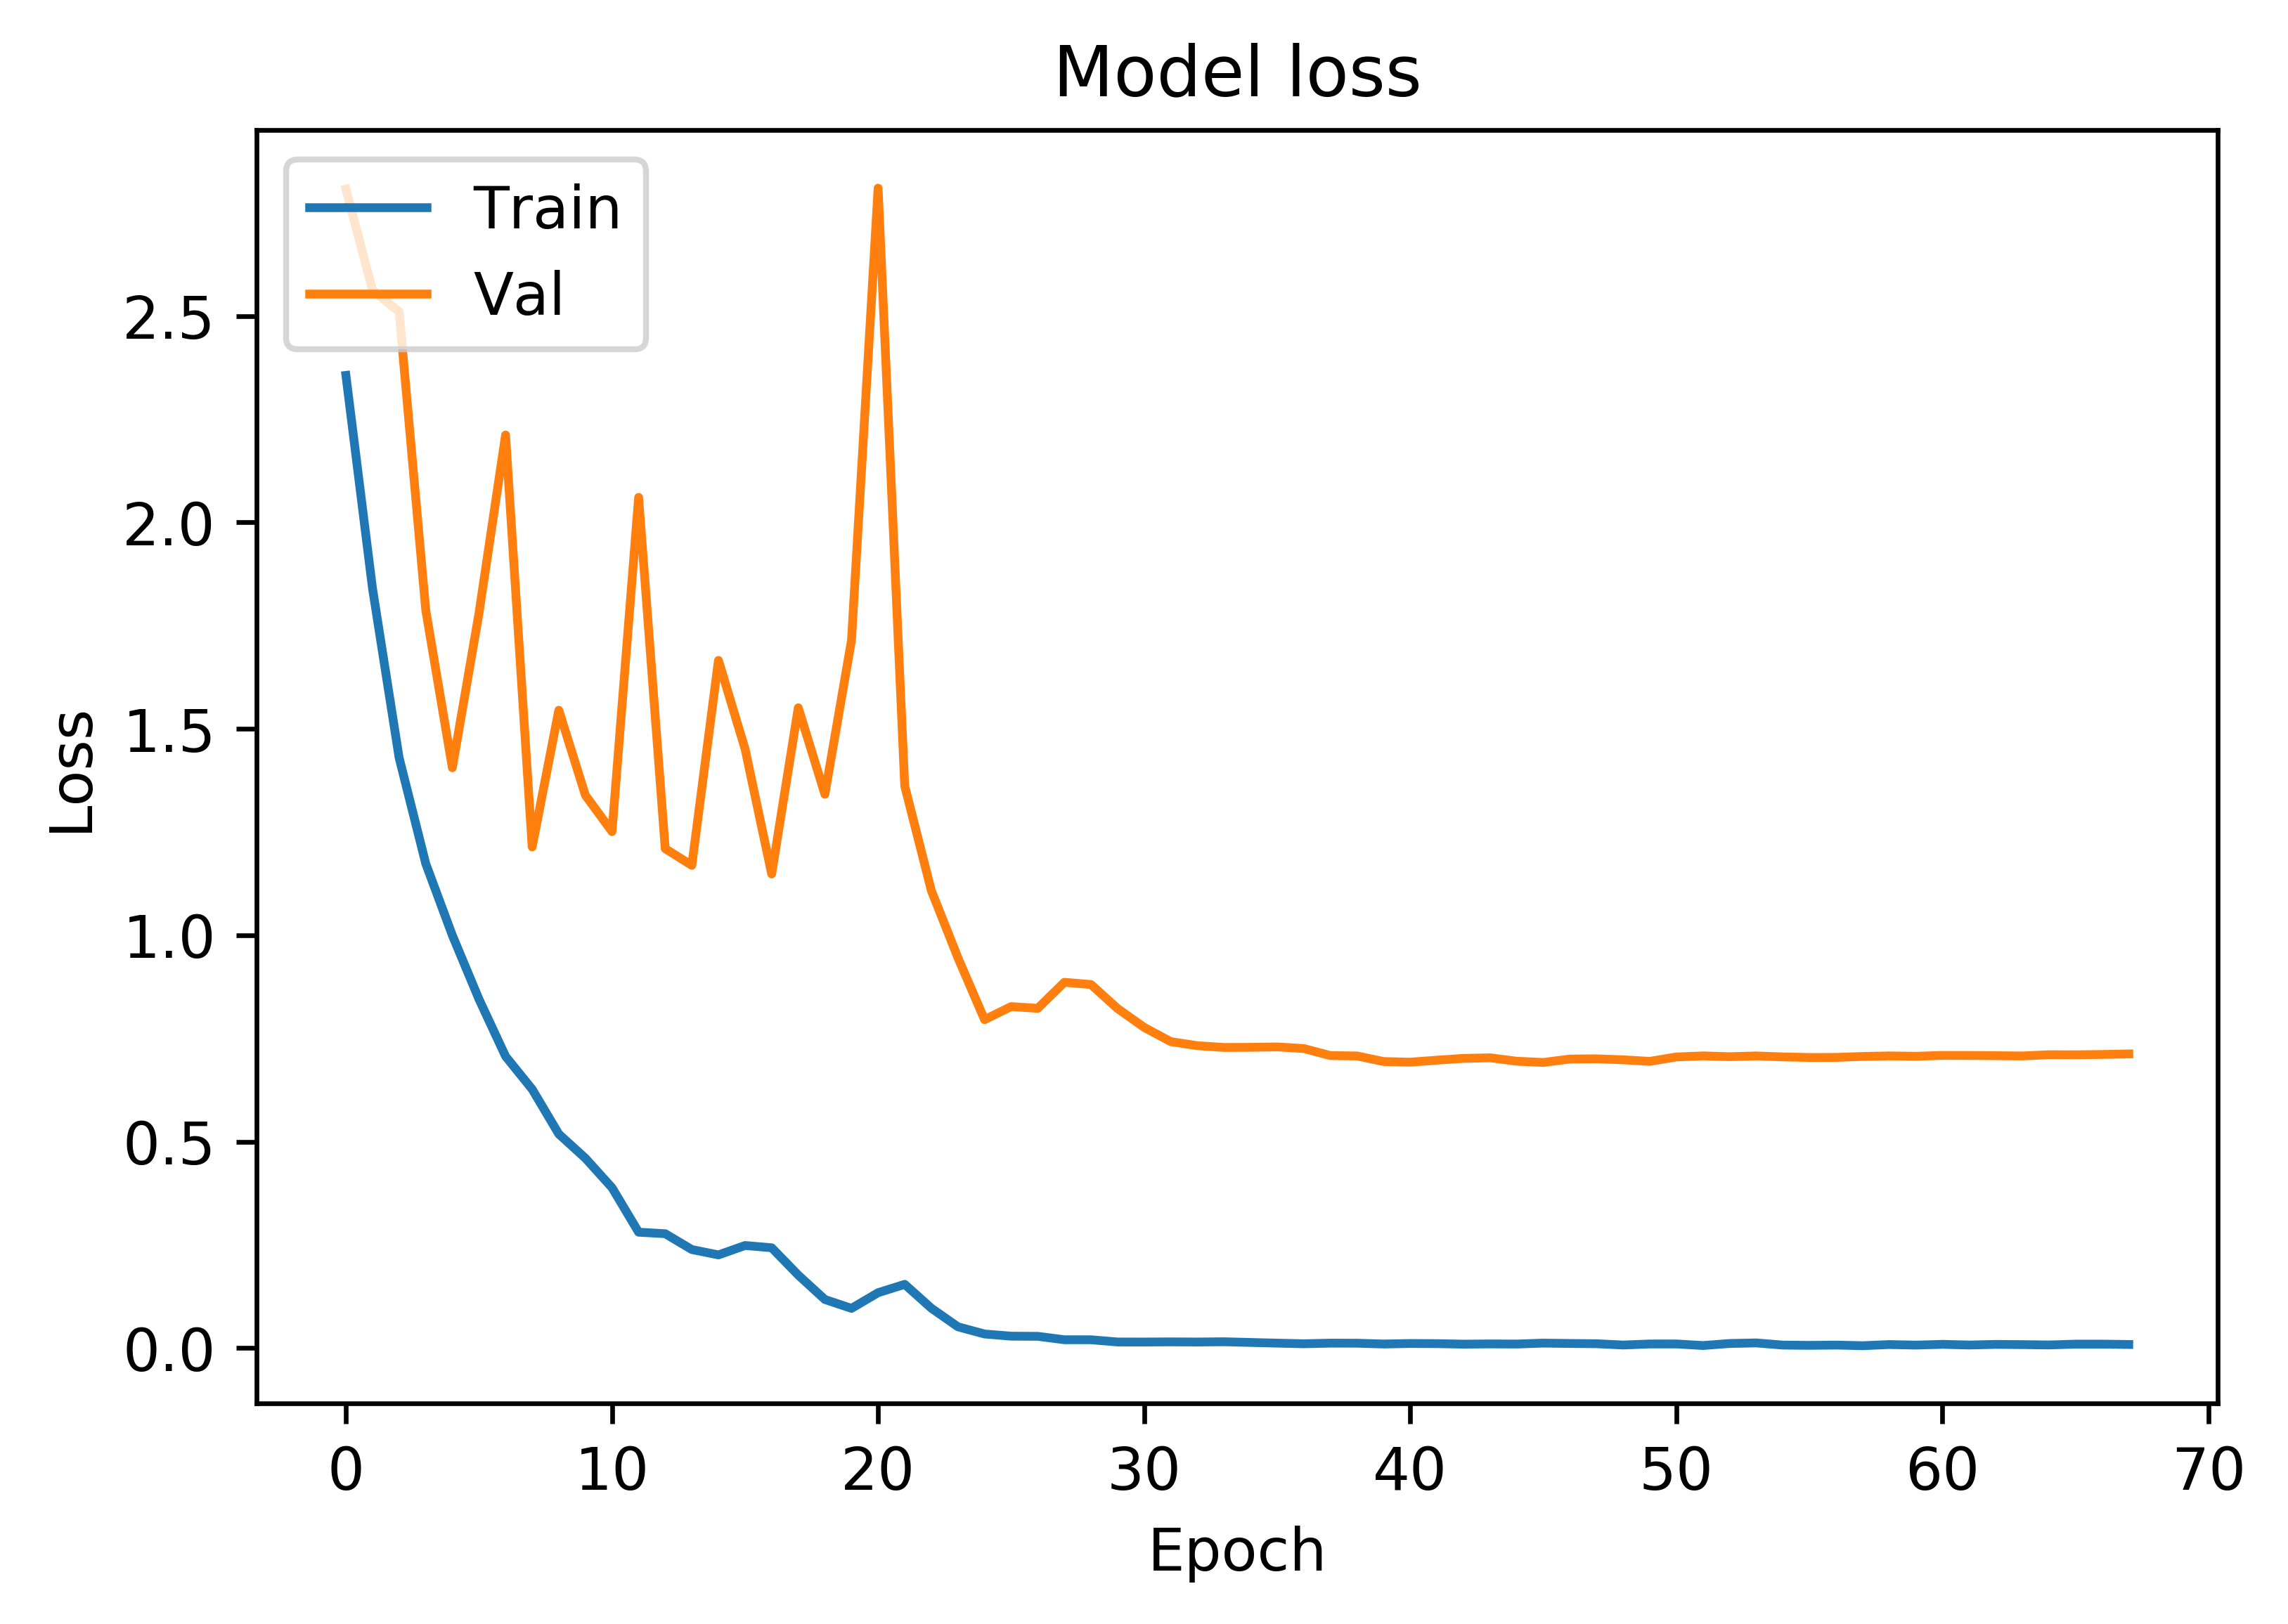

Results from K-fold: 1
acc: 82.12%
632/632 [==============================] - 0s 730us/step
[0.7724397514439836, 0.8212025324000588]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         60    2        1     5          2         2     5          2
gel          2   70        2     2          1         2     0          0
network      1    2       56     0          0         7     5          8
plot         1    1        2    65          0         0     9          1
histology    0    0        0     0         77         0     0          2
sequence     1    1        6     0          1        69     1          0
line         2    3        8     8          0         3    55          0
molecular    0    0        3     3          4         2     0         67
              precision    recall  f1-score   support

         bar       0.90      0.76      0.82        79
         gel       0.89      0.89      0.89        79
     network       0.72      0.71      0.71    

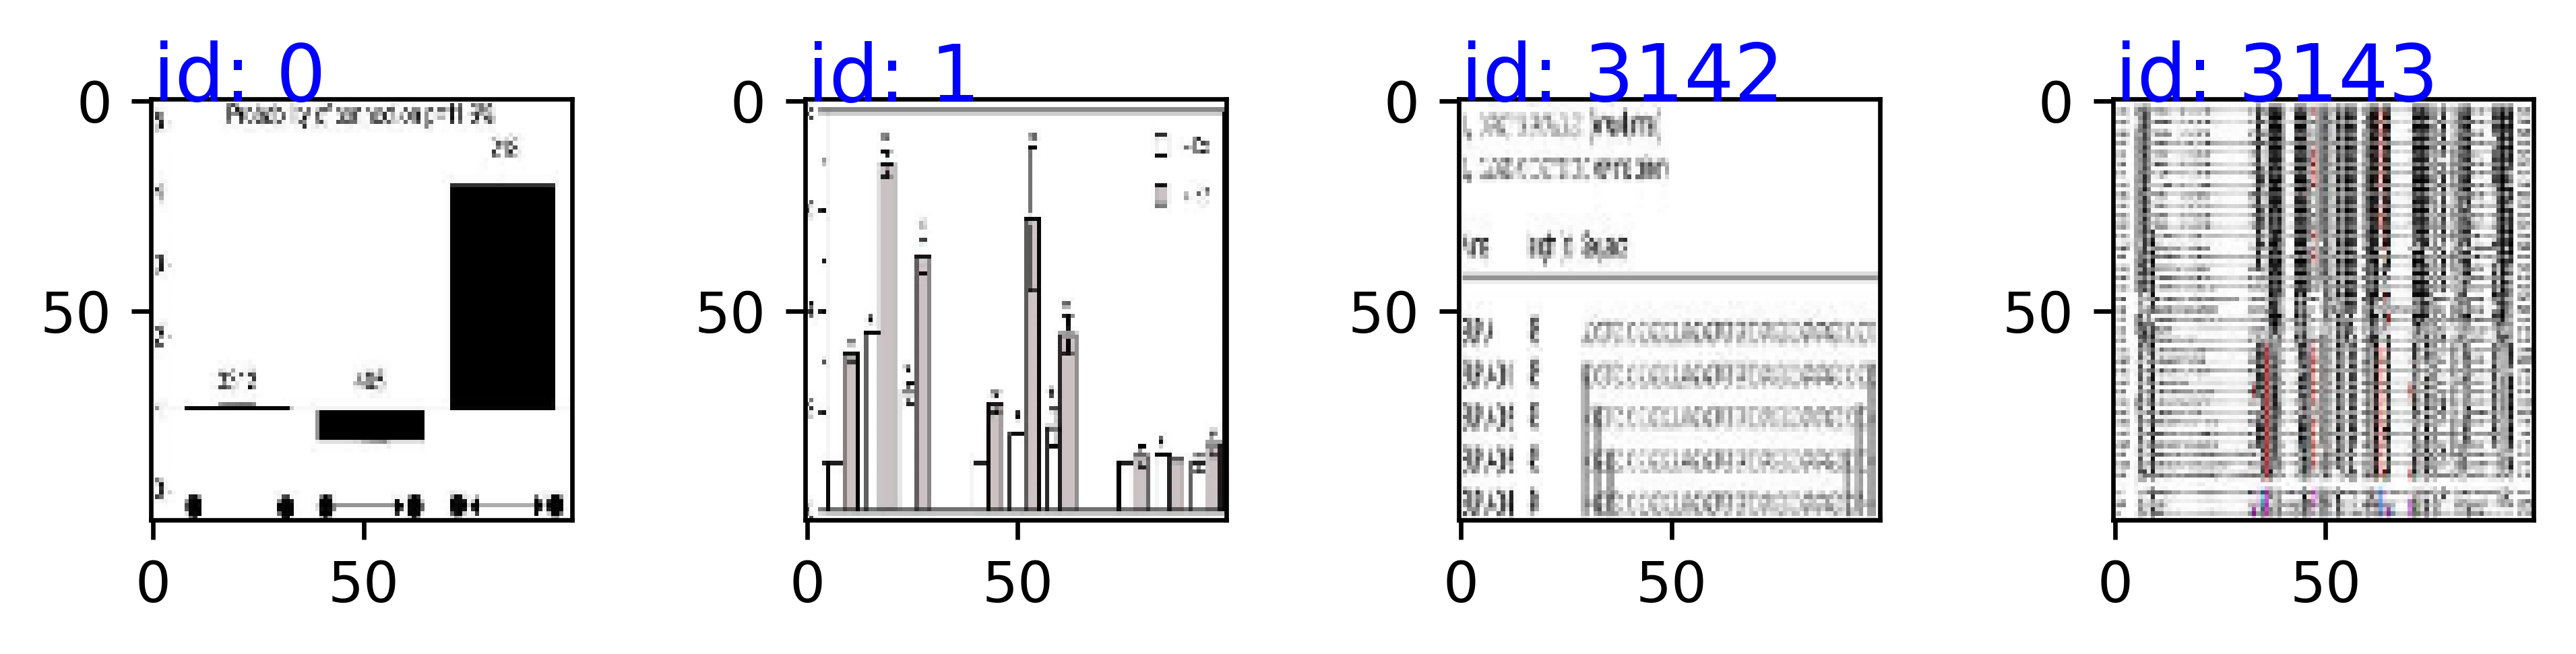

Samples from Testing
[   8   12 3133 3140]


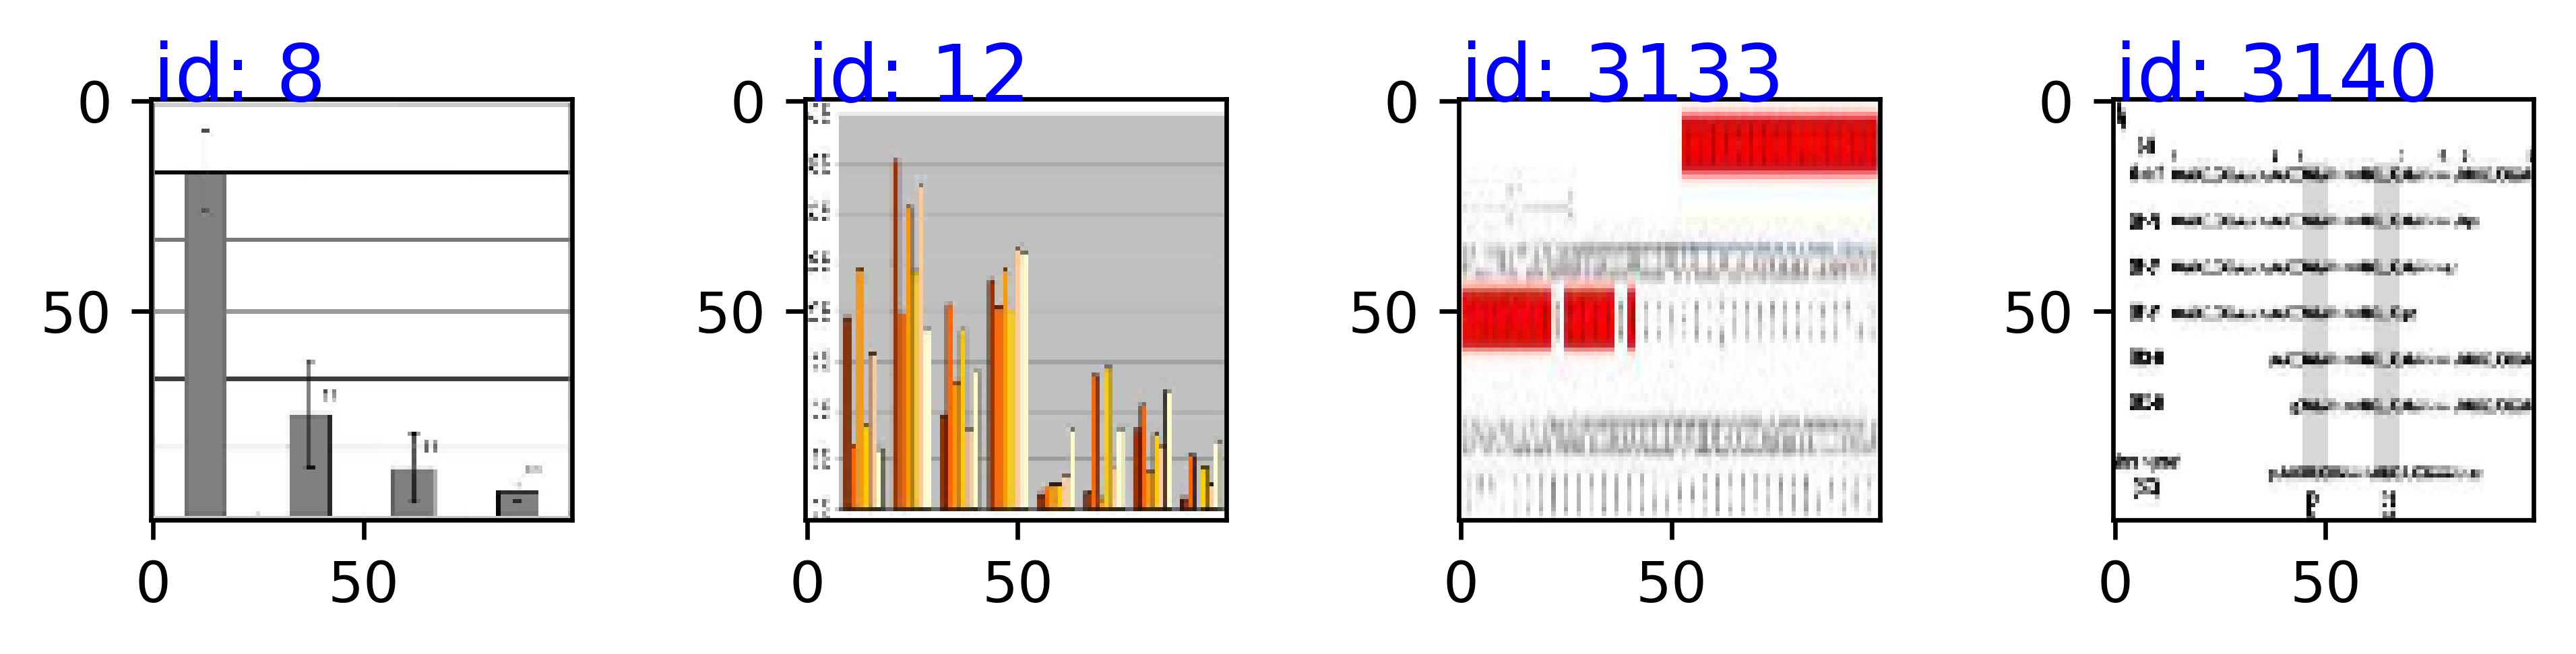

[INFO] training with 2 GPUs...
Train on 2260 samples, validate on 252 samples
Epoch 1/150
2260/2260 [==============================] - 7s 3ms/step - loss: 2.3719 - acc: 0.3314 - val_loss: 3.5678 - val_acc: 0.3770

Epoch 00001: val_acc improved from -inf to 0.37698, saving model to unimodal_weights/best_weight_image_only_k-fold_2.hdf5
Epoch 2/150
2260/2260 [==============================] - 2s 1ms/step - loss: 1.6839 - acc: 0.4611 - val_loss: 2.0489 - val_acc: 0.4881

Epoch 00002: val_acc improved from 0.37698 to 0.48810, saving model to unimodal_weights/best_weight_image_only_k-fold_2.hdf5
Epoch 3/150
2260/2260 [==============================] - 2s 1ms/step - loss: 1.3326 - acc: 0.5686 - val_loss: 3.6391 - val_acc: 0.4563

Epoch 00003: val_acc did not improve from 0.48810
Epoch 4/150
2260/2260 [==============================] - 3s 1ms/step - loss: 1.1483 - acc: 0.6031 - val_loss: 1.3074 - val_acc: 0.6071

Epoch 00004: val_acc improved from 0.48810 to 0.60714, saving model to unimodal_w


Epoch 00036: val_acc did not improve from 0.77778
Epoch 37/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.0216 - acc: 0.9947 - val_loss: 0.8454 - val_acc: 0.7619

Epoch 00037: val_acc did not improve from 0.77778
Epoch 38/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.0208 - acc: 0.9960 - val_loss: 0.8368 - val_acc: 0.7500

Epoch 00038: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 00038: val_acc did not improve from 0.77778
Epoch 39/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.0197 - acc: 0.9951 - val_loss: 0.8355 - val_acc: 0.7500

Epoch 00039: val_acc did not improve from 0.77778
Epoch 40/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.0198 - acc: 0.9951 - val_loss: 0.8400 - val_acc: 0.7540

Epoch 00040: val_acc did not improve from 0.77778
Epoch 41/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.0189 - acc: 0.9960 - val_loss: 0.8360 -

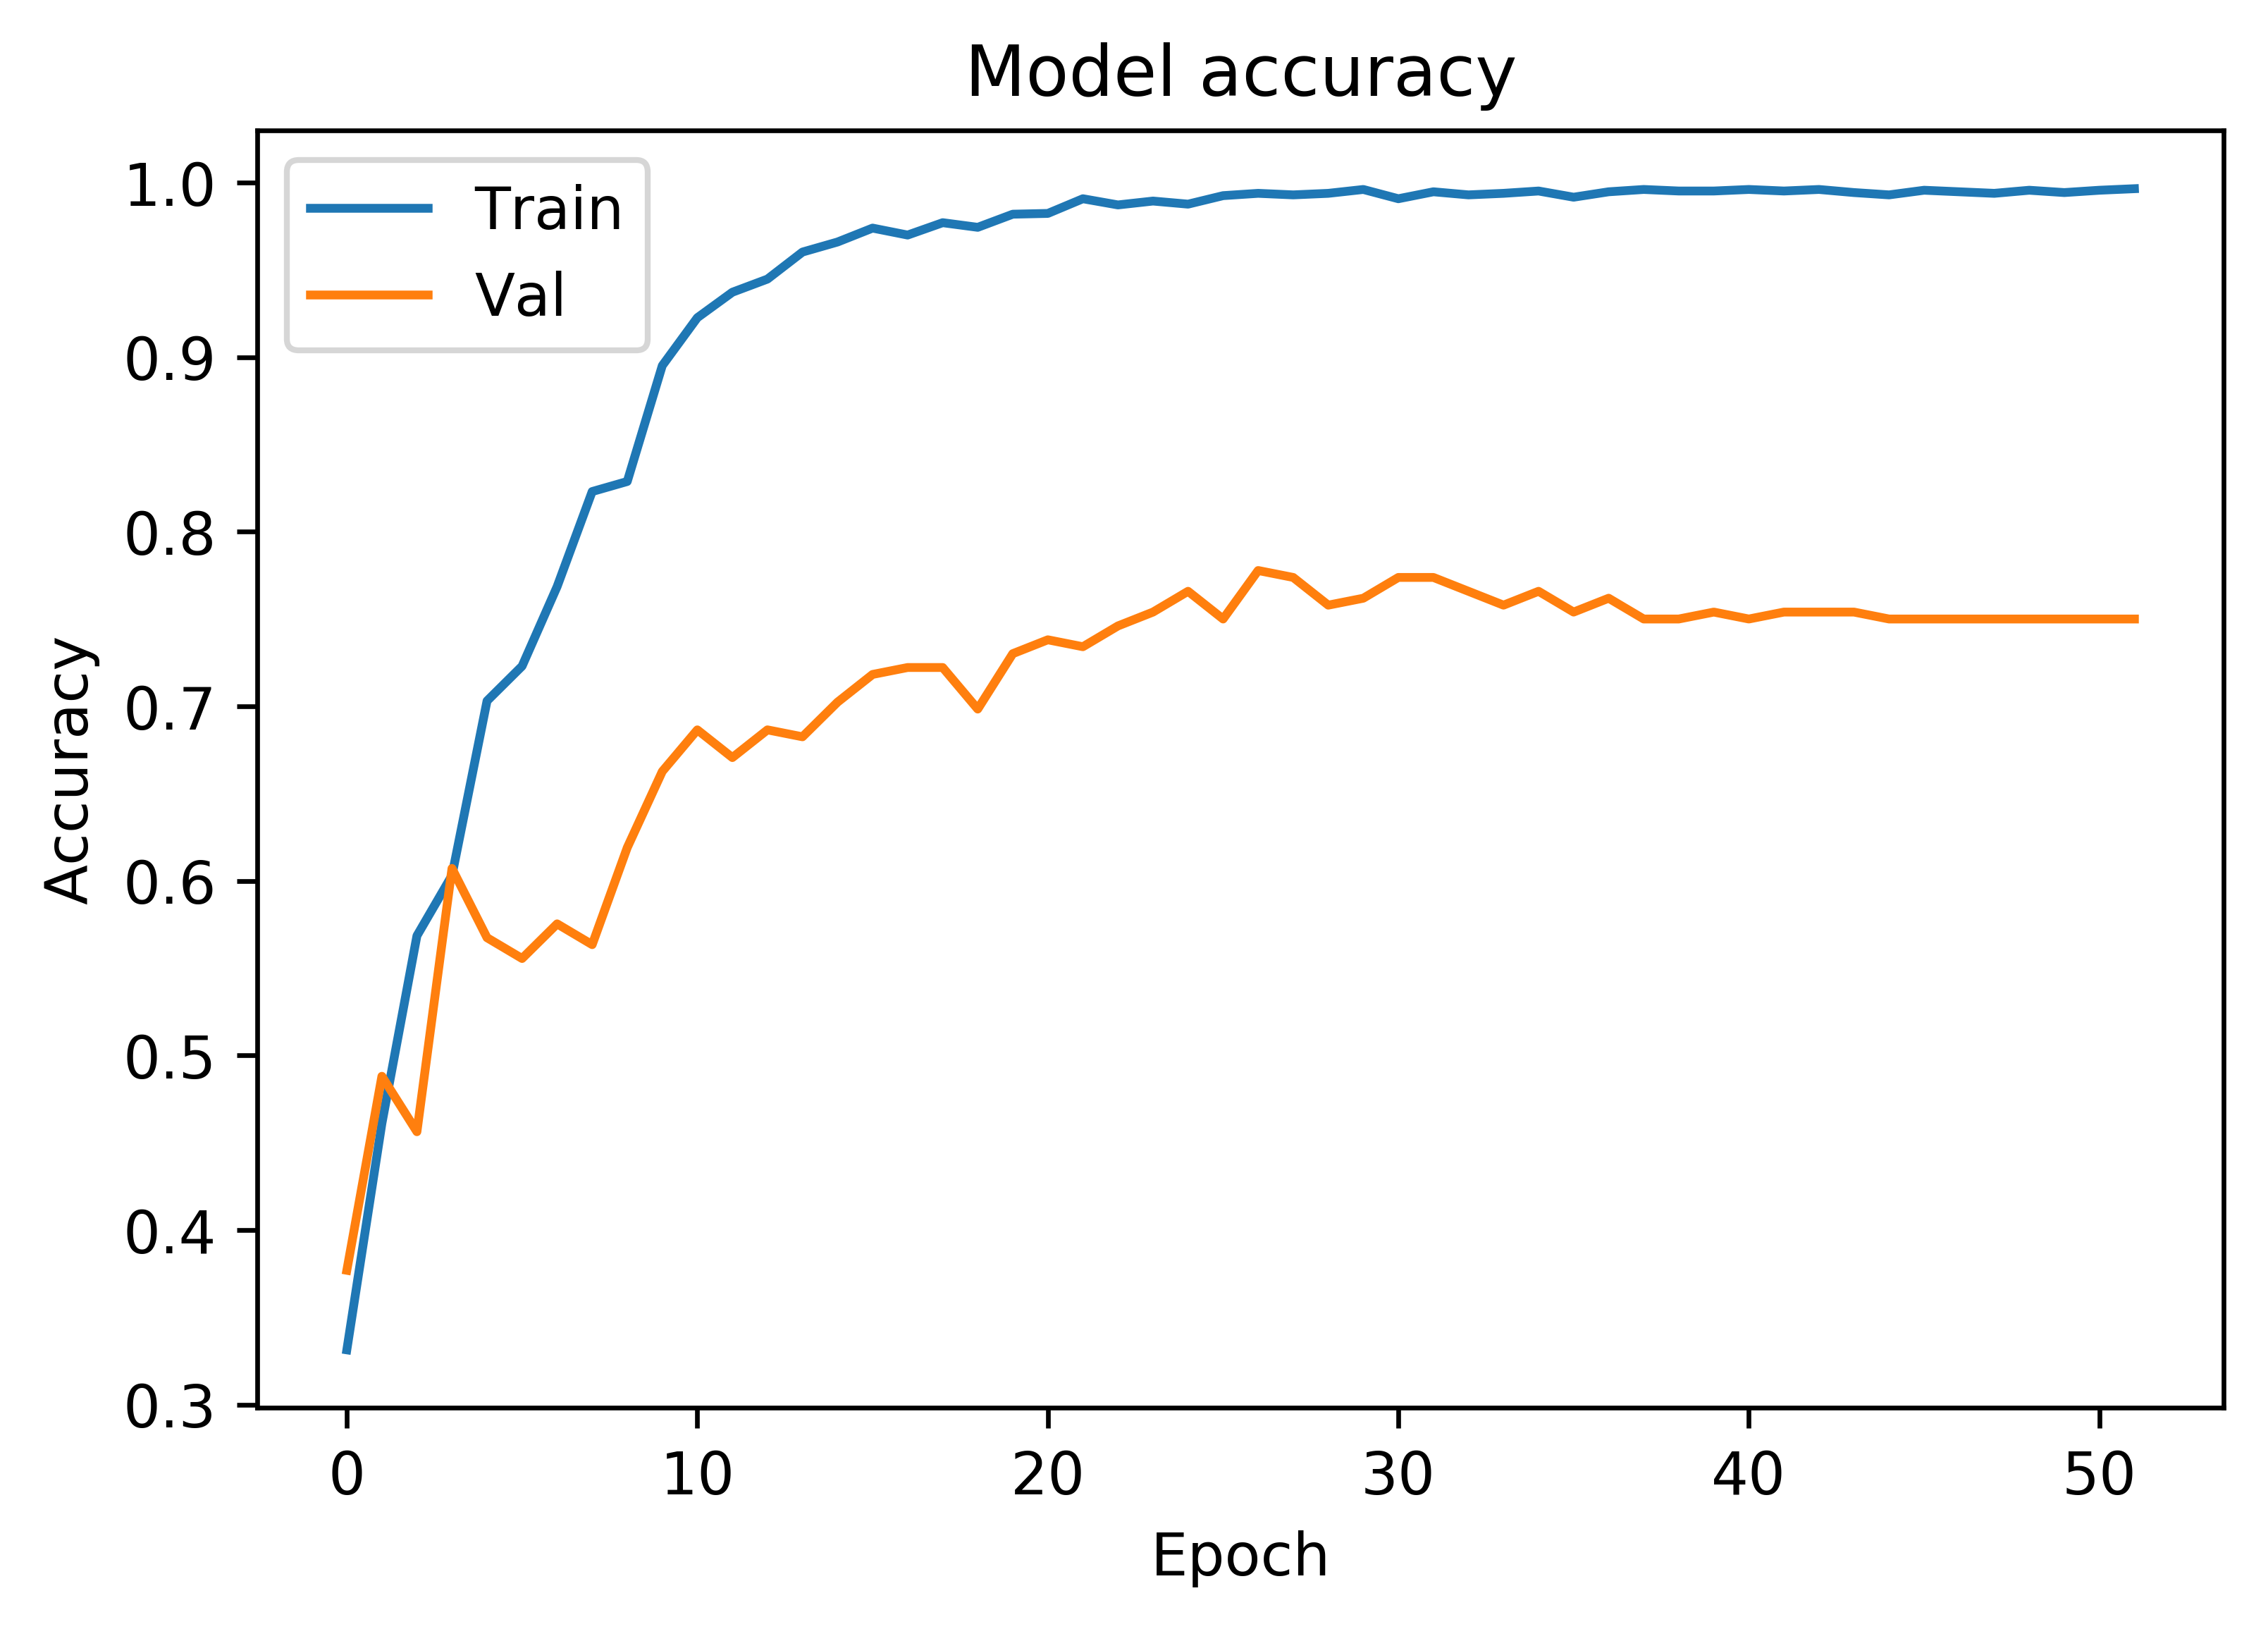

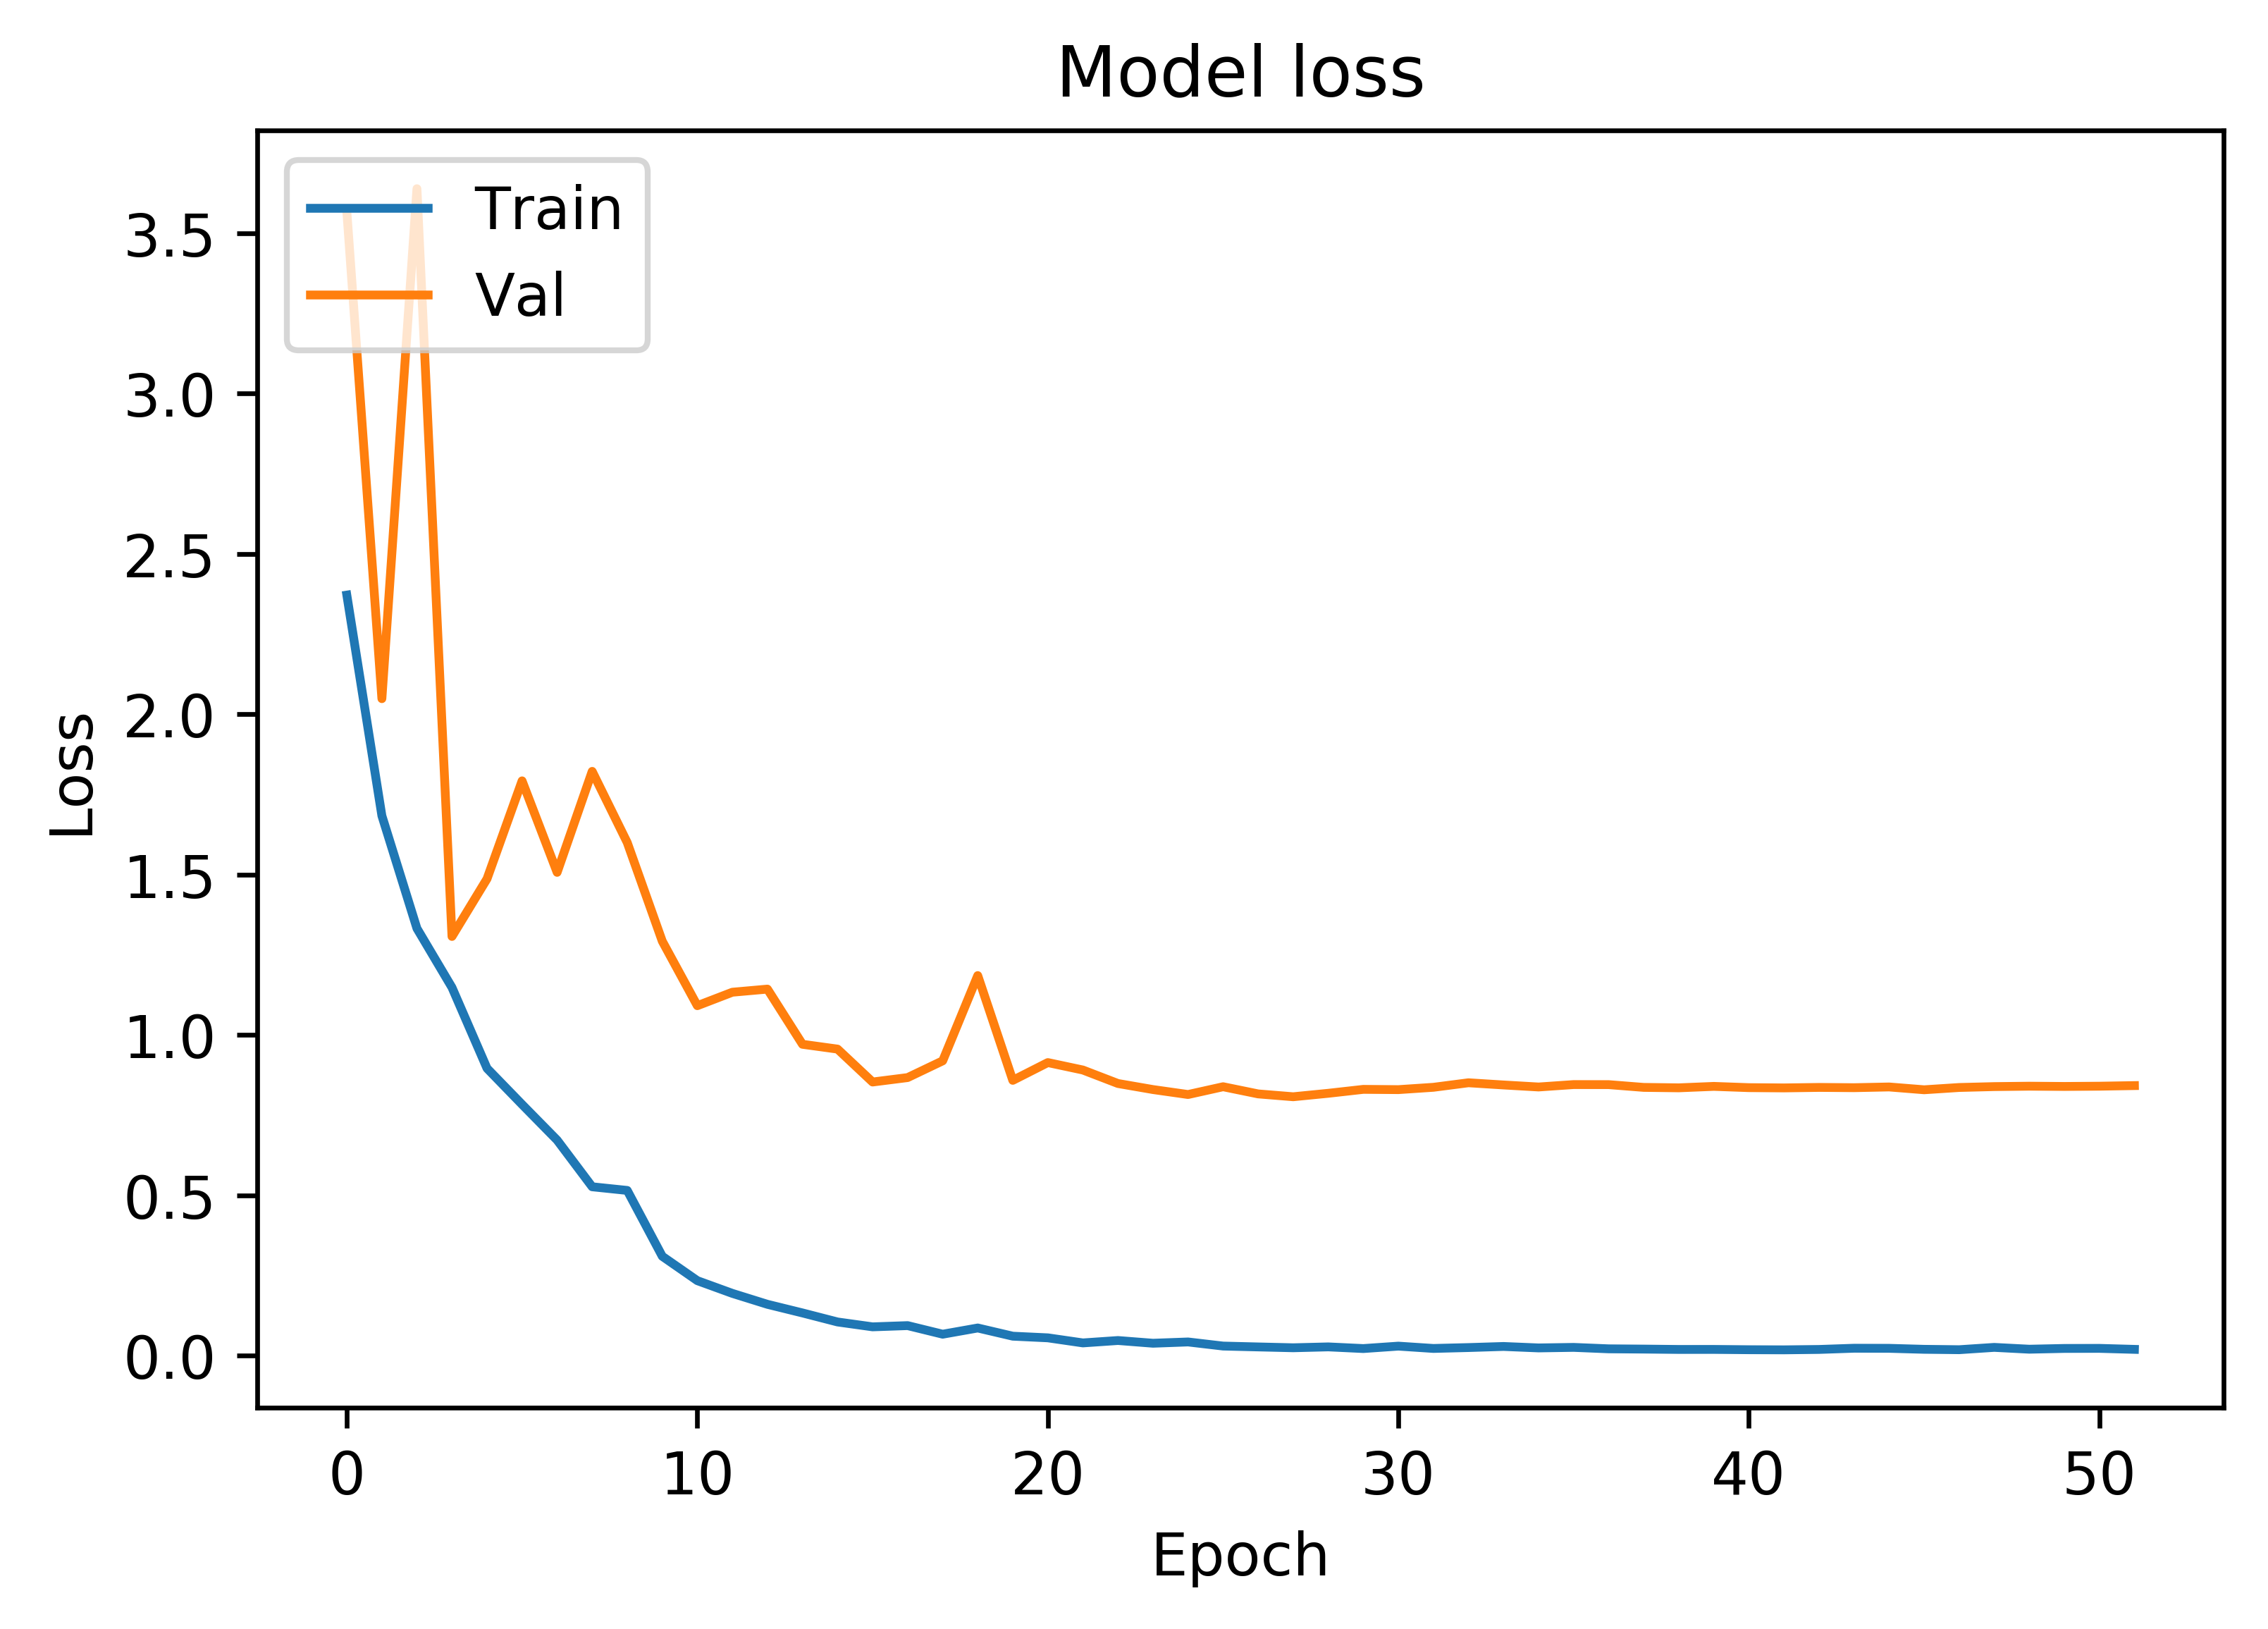

Results from K-fold: 2
acc: 80.70%
632/632 [==============================] - 0s 749us/step
[0.8440178966597666, 0.8069620260709449]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         65    1        3     2          1         1     6          0
gel          0   73        2     1          1         0     1          1
network      0    4       58     2          0         3     8          4
plot         4    1        3    48          1         0    19          3
histology    0    3        0     0         68         0     0          8
sequence     0    1        3     0          1        74     0          0
line         0    2        7     8          2         1    52          7
molecular    0    0        2     0          2         1     2         72
              precision    recall  f1-score   support

         bar       0.94      0.82      0.88        79
         gel       0.86      0.92      0.89        79
     network       0.74      0.73      0.74    

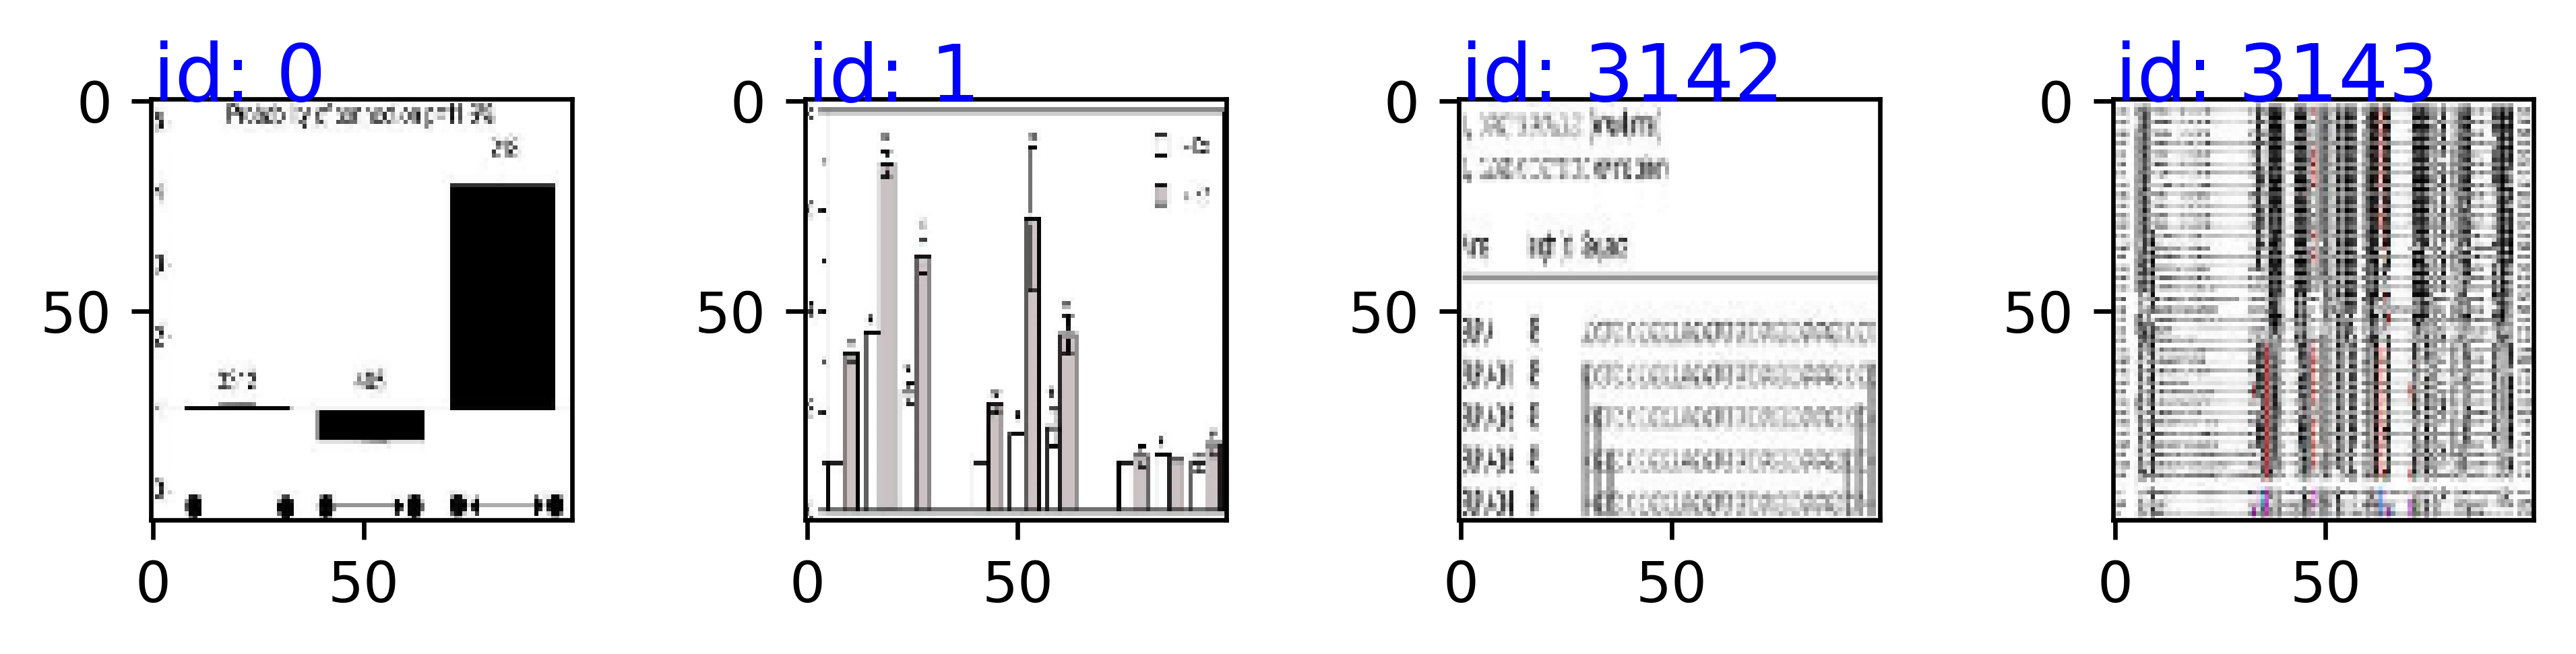

Samples from Testing
[   2   13 3135 3141]


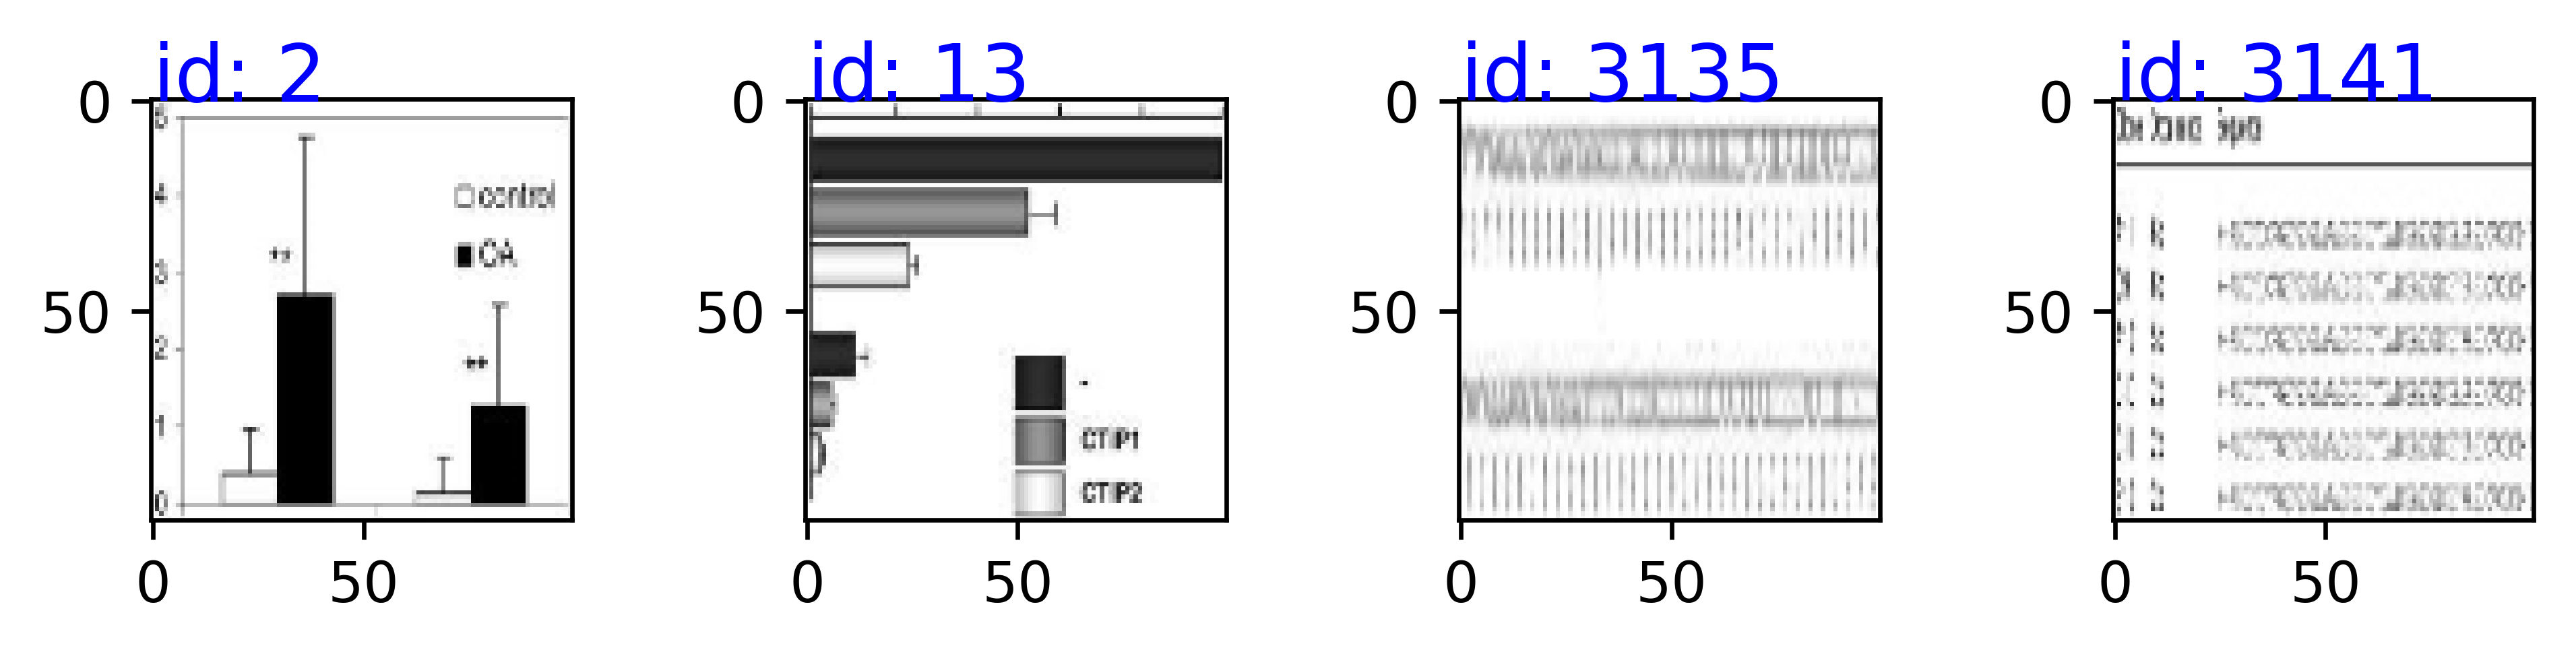

[INFO] training with 2 GPUs...
Train on 2260 samples, validate on 252 samples
Epoch 1/150
2260/2260 [==============================] - 7s 3ms/step - loss: 2.3809 - acc: 0.3310 - val_loss: 3.4050 - val_acc: 0.3571

Epoch 00001: val_acc improved from -inf to 0.35714, saving model to unimodal_weights/best_weight_image_only_k-fold_3.hdf5
Epoch 2/150
2260/2260 [==============================] - 3s 1ms/step - loss: 1.7438 - acc: 0.4611 - val_loss: 2.2537 - val_acc: 0.4563

Epoch 00002: val_acc improved from 0.35714 to 0.45635, saving model to unimodal_weights/best_weight_image_only_k-fold_3.hdf5
Epoch 3/150
2260/2260 [==============================] - 3s 1ms/step - loss: 1.4530 - acc: 0.5332 - val_loss: 2.6966 - val_acc: 0.4405

Epoch 00003: val_acc did not improve from 0.45635
Epoch 4/150
2260/2260 [==============================] - 3s 1ms/step - loss: 1.1787 - acc: 0.6000 - val_loss: 1.4435 - val_acc: 0.5516

Epoch 00004: val_acc improved from 0.45635 to 0.55159, saving model to unimodal_w

2260/2260 [==============================] - 3s 1ms/step - loss: 0.0187 - acc: 0.9956 - val_loss: 0.6114 - val_acc: 0.7897

Epoch 00038: val_acc did not improve from 0.80952
Epoch 39/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.0206 - acc: 0.9951 - val_loss: 0.5993 - val_acc: 0.7897

Epoch 00039: val_acc did not improve from 0.80952
Epoch 40/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.0164 - acc: 0.9973 - val_loss: 0.6354 - val_acc: 0.7937

Epoch 00040: val_acc did not improve from 0.80952
Epoch 41/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.0136 - acc: 0.9973 - val_loss: 0.6308 - val_acc: 0.8056

Epoch 00041: val_acc did not improve from 0.80952
Epoch 42/150
2260/2260 [==============================] - 3s 1ms/step - loss: 0.0130 - acc: 0.9978 - val_loss: 0.6212 - val_acc: 0.8135

Epoch 00042: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00042: val_acc improved from 0.80952 to 0

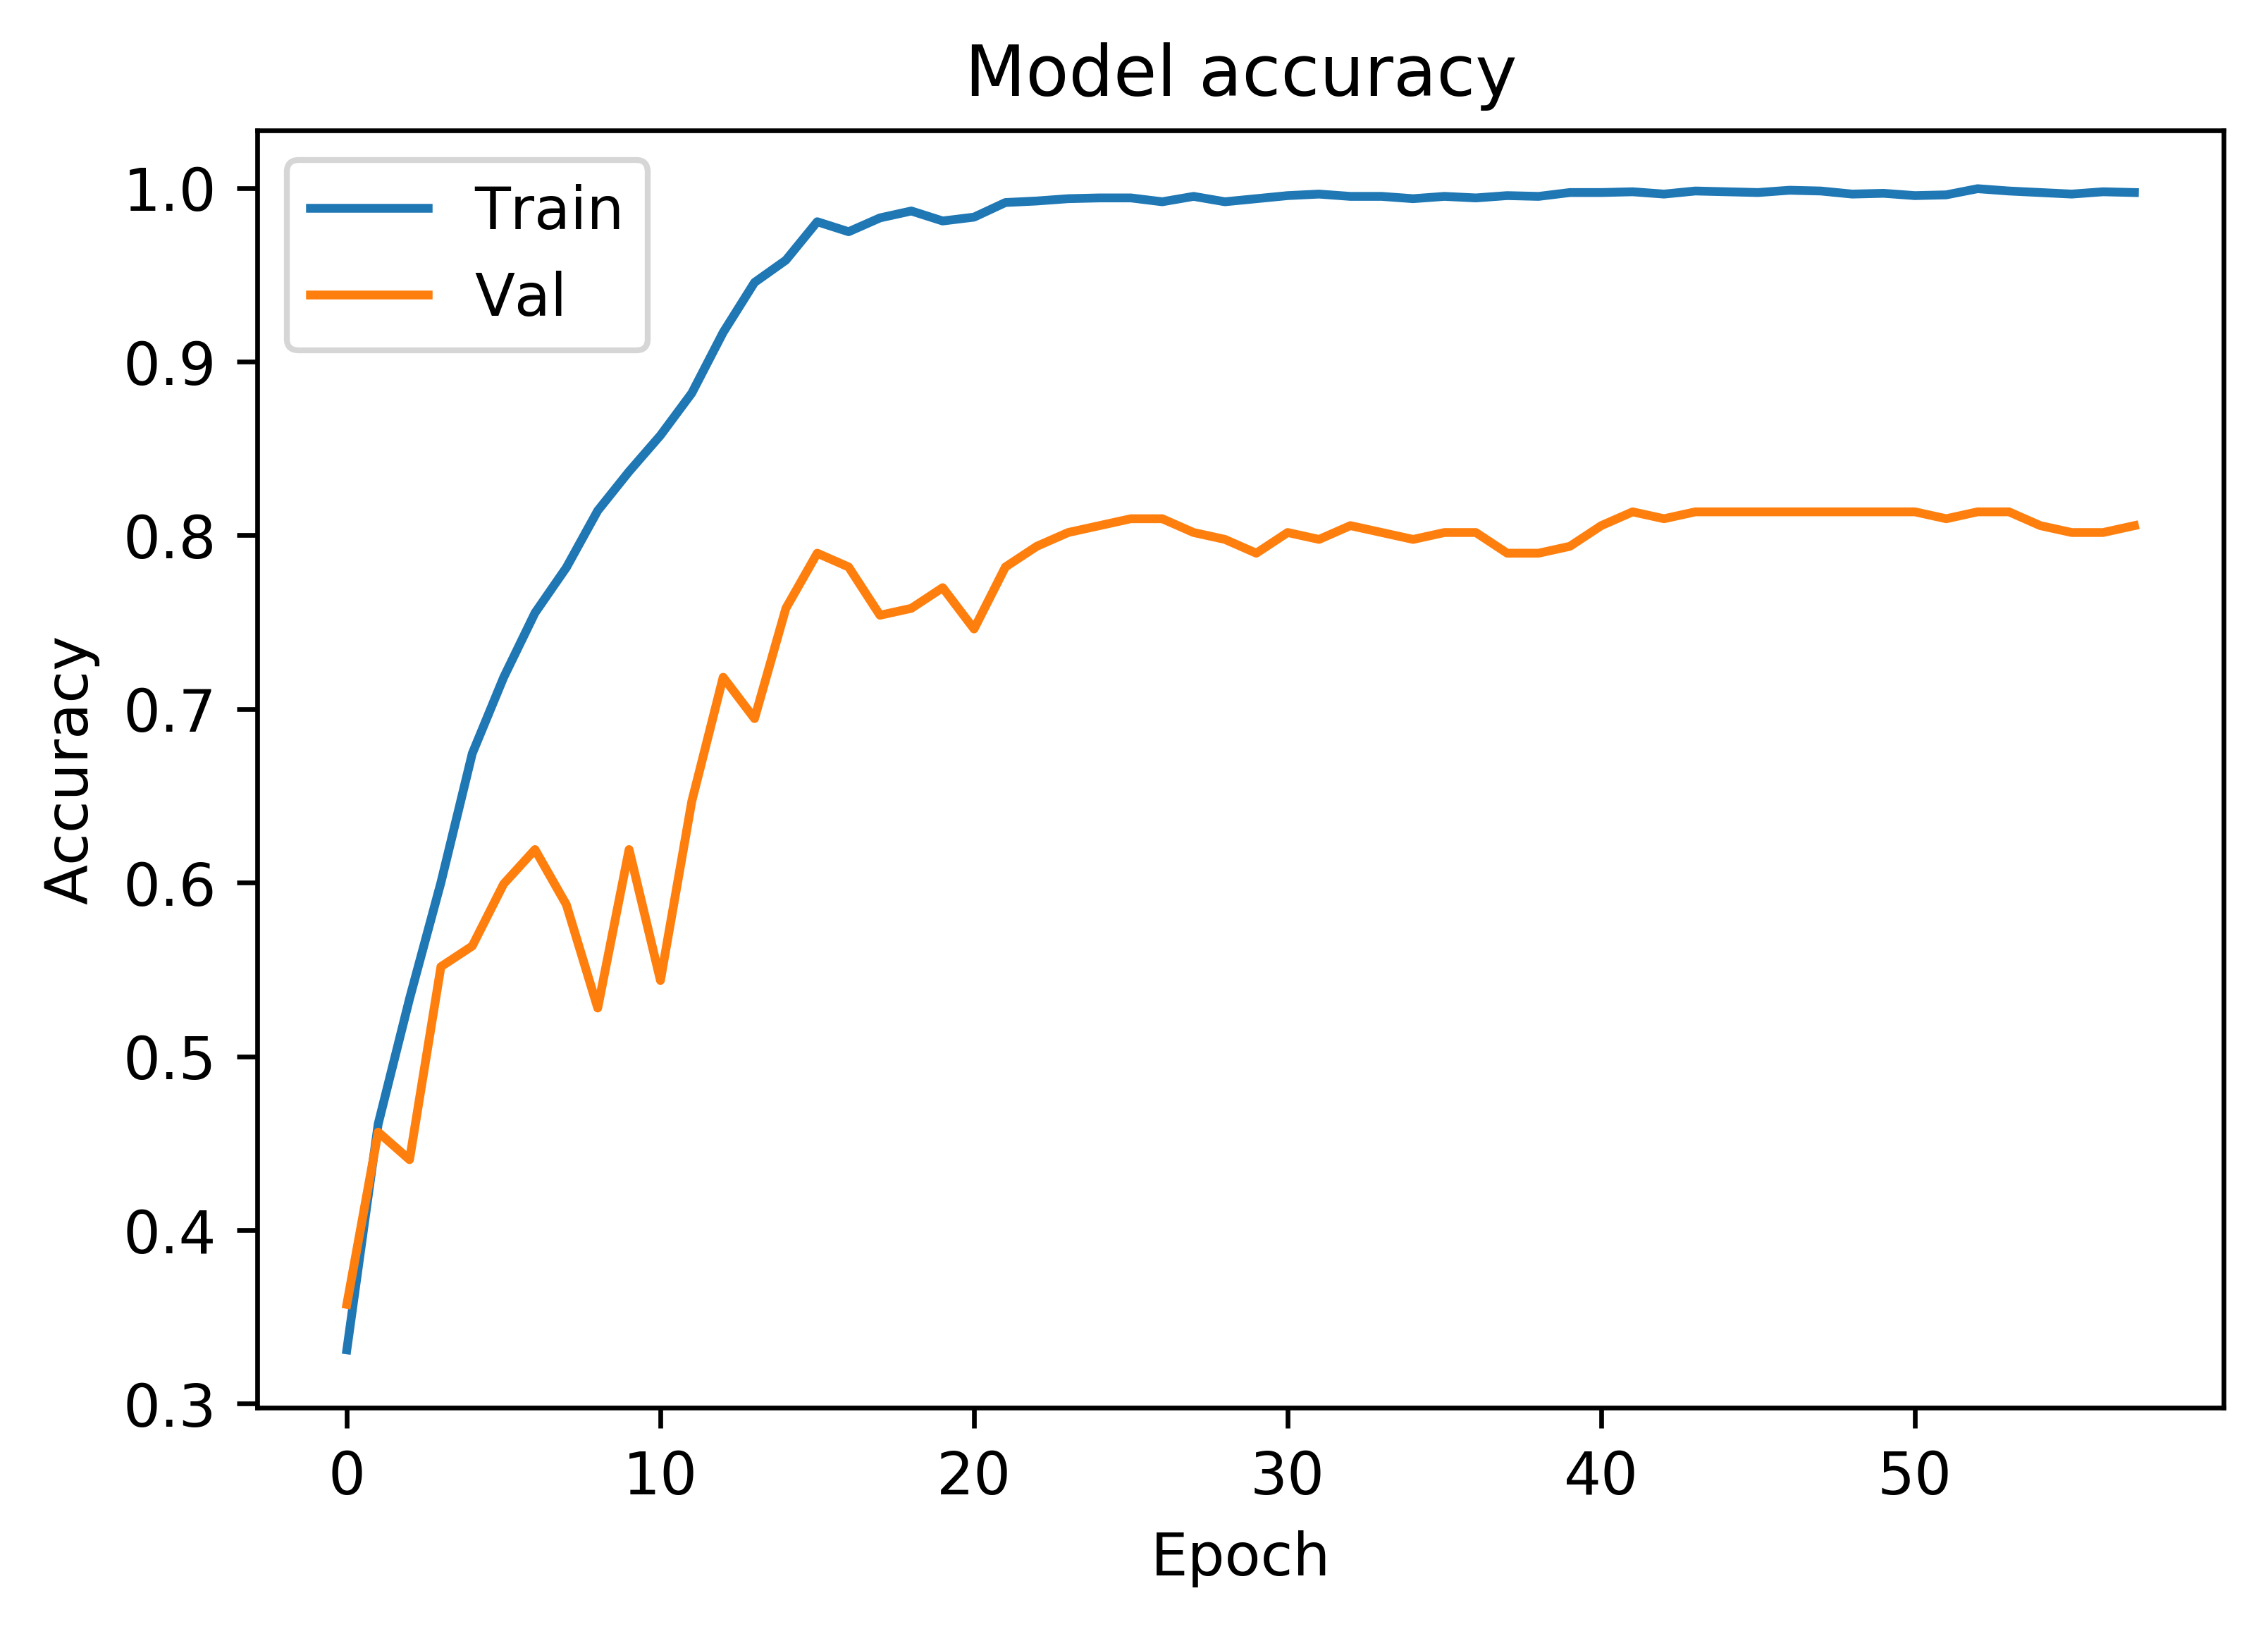

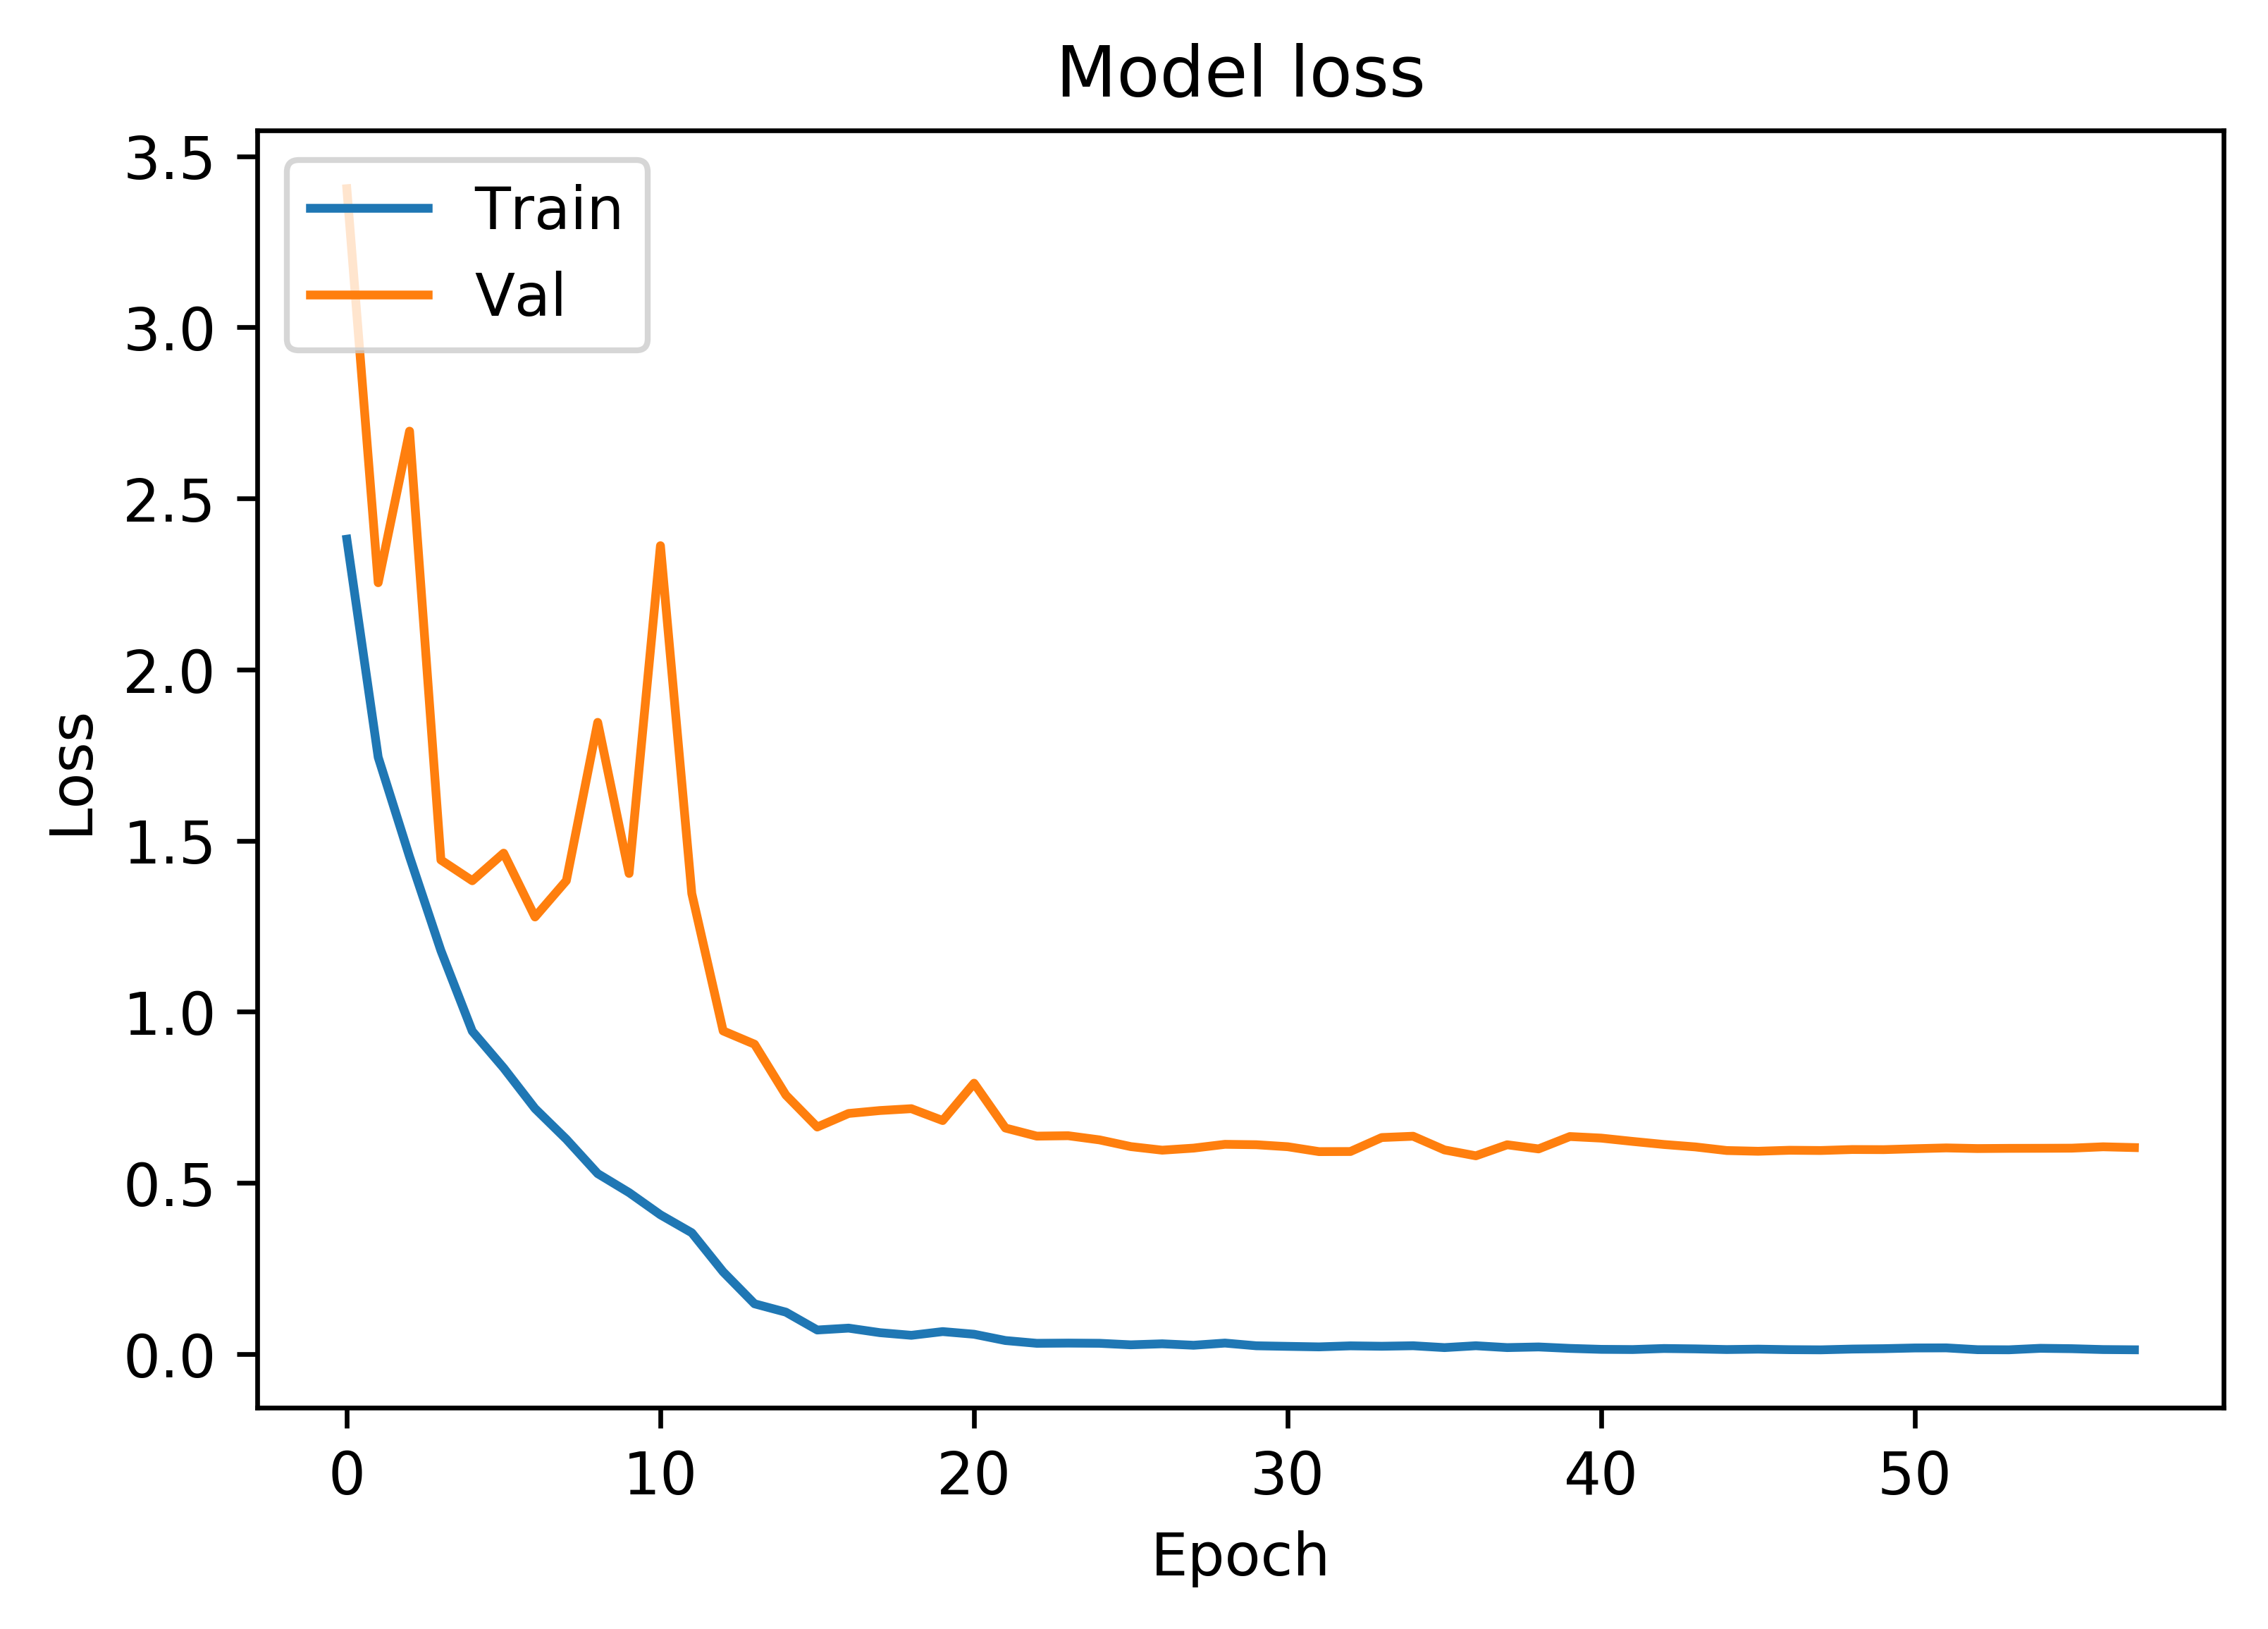

Results from K-fold: 3
acc: 83.70%
632/632 [==============================] - 0s 727us/step
[0.571231680839688, 0.8370253164556962]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         69    3        0     4          0         1     2          0
gel          0   68        4     1          0         3     2          1
network      1    1       60     5          2         5     1          4
plot         0    1        7    63          1         0     7          0
histology    0    2        0     0         75         0     0          2
sequence     0    0        4     1          0        72     2          0
line         1    3        5    13          0         3    54          0
molecular    0    0        7     0          2         1     1         68
              precision    recall  f1-score   support

         bar       0.97      0.87      0.92        79
         gel       0.87      0.86      0.87        79
     network       0.69      0.76      0.72     

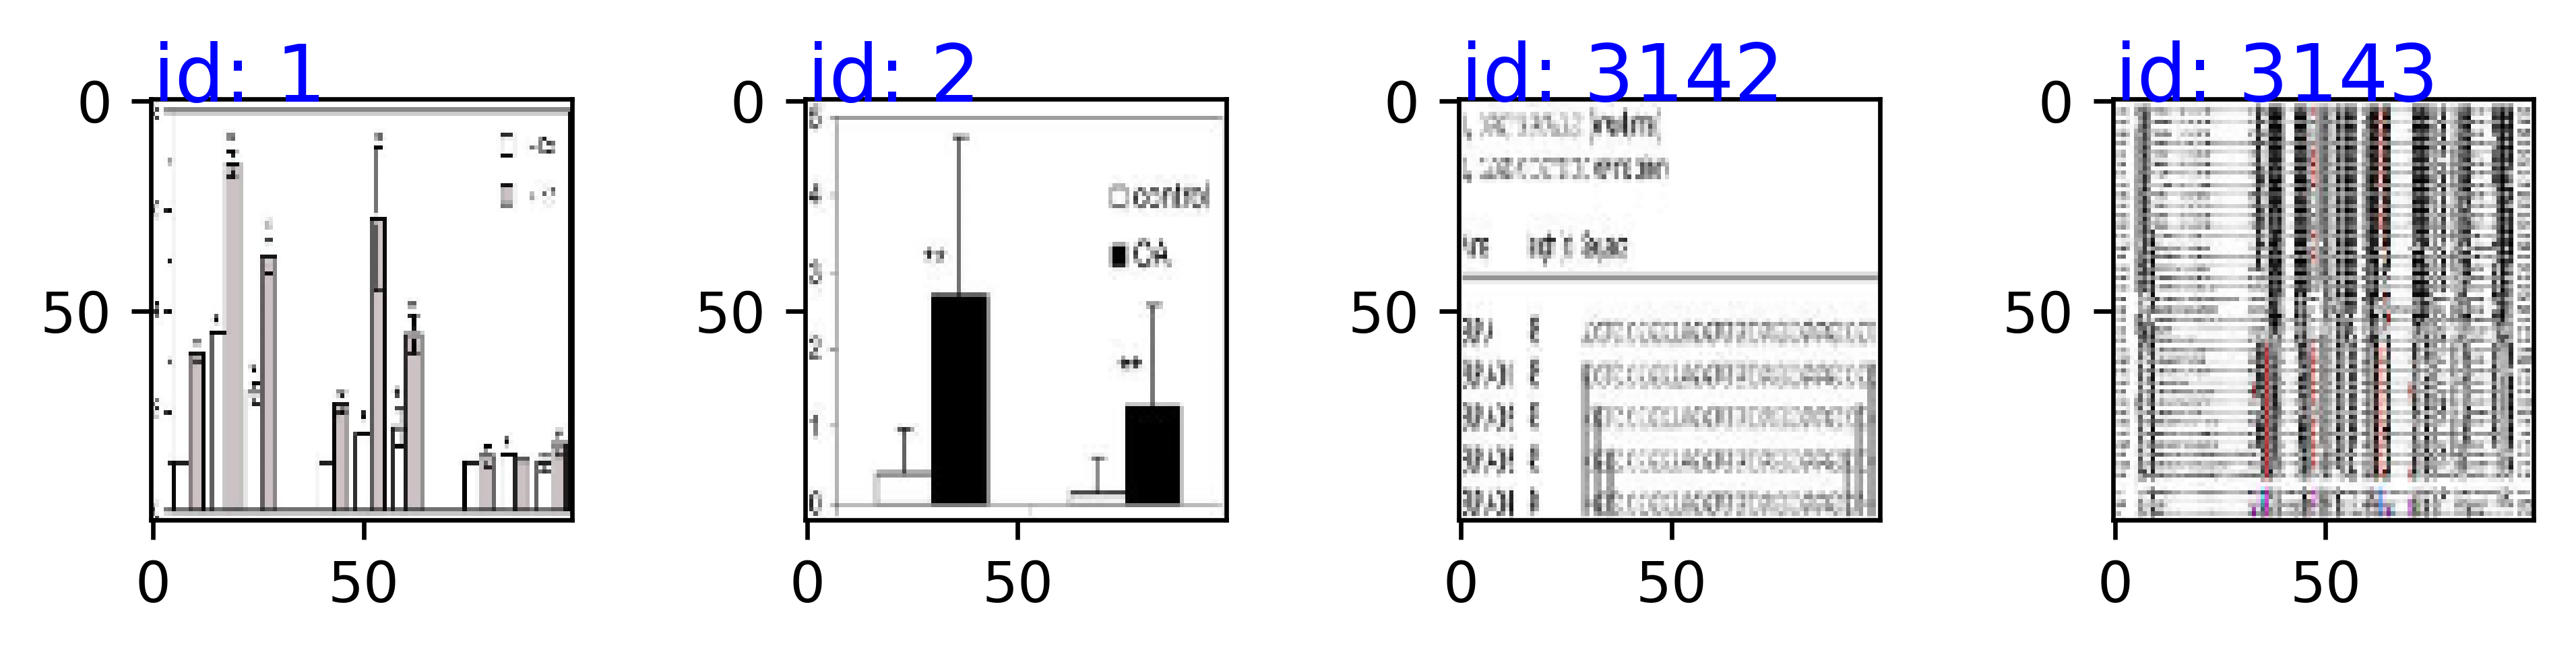

Samples from Testing
[   0    3 3131 3137]


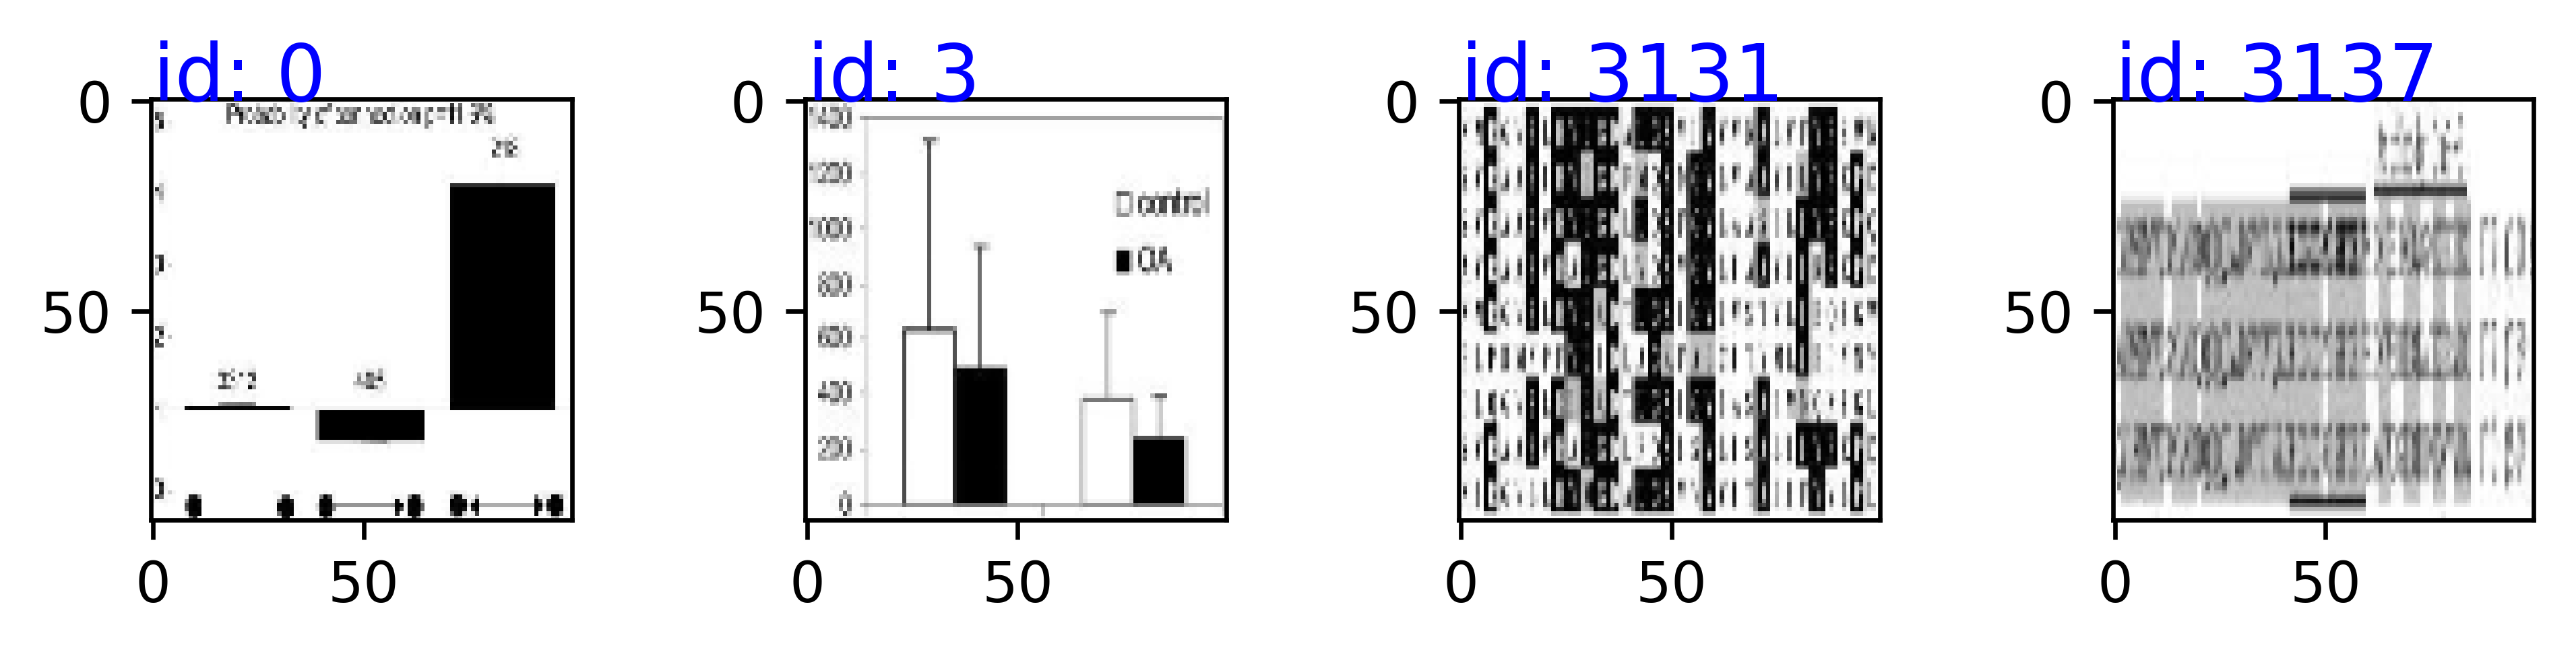

[INFO] training with 2 GPUs...
Train on 2268 samples, validate on 252 samples
Epoch 1/150
2268/2268 [==============================] - 8s 4ms/step - loss: 2.3911 - acc: 0.3347 - val_loss: 4.2541 - val_acc: 0.3214

Epoch 00001: val_acc improved from -inf to 0.32143, saving model to unimodal_weights/best_weight_image_only_k-fold_4.hdf5
Epoch 2/150
2268/2268 [==============================] - 3s 1ms/step - loss: 1.7607 - acc: 0.4678 - val_loss: 2.3811 - val_acc: 0.4762

Epoch 00002: val_acc improved from 0.32143 to 0.47619, saving model to unimodal_weights/best_weight_image_only_k-fold_4.hdf5
Epoch 3/150
2268/2268 [==============================] - 3s 1ms/step - loss: 1.4051 - acc: 0.5437 - val_loss: 1.5261 - val_acc: 0.5516

Epoch 00003: val_acc improved from 0.47619 to 0.55159, saving model to unimodal_weights/best_weight_image_only_k-fold_4.hdf5
Epoch 4/150
2268/2268 [==============================] - 3s 1ms/step - loss: 1.2000 - acc: 0.6129 - val_loss: 2.1115 - val_acc: 0.5000

Epoch 

2268/2268 [==============================] - 3s 1ms/step - loss: 0.0122 - acc: 0.9987 - val_loss: 0.8245 - val_acc: 0.7738

Epoch 00038: val_acc did not improve from 0.78968
Epoch 39/150
2268/2268 [==============================] - 3s 1ms/step - loss: 0.0162 - acc: 0.9947 - val_loss: 0.8152 - val_acc: 0.7738

Epoch 00039: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00039: val_acc did not improve from 0.78968
Epoch 40/150
2268/2268 [==============================] - 3s 1ms/step - loss: 0.0117 - acc: 0.9982 - val_loss: 0.8194 - val_acc: 0.7738

Epoch 00040: val_acc did not improve from 0.78968
Epoch 41/150
2268/2268 [==============================] - 3s 1ms/step - loss: 0.0148 - acc: 0.9974 - val_loss: 0.8192 - val_acc: 0.7778

Epoch 00041: val_acc did not improve from 0.78968
Epoch 42/150
2268/2268 [==============================] - 3s 1ms/step - loss: 0.0121 - acc: 0.9960 - val_loss: 0.8230 - val_acc: 0.7778

Epoch 00042: val_acc did not improve from 0.789

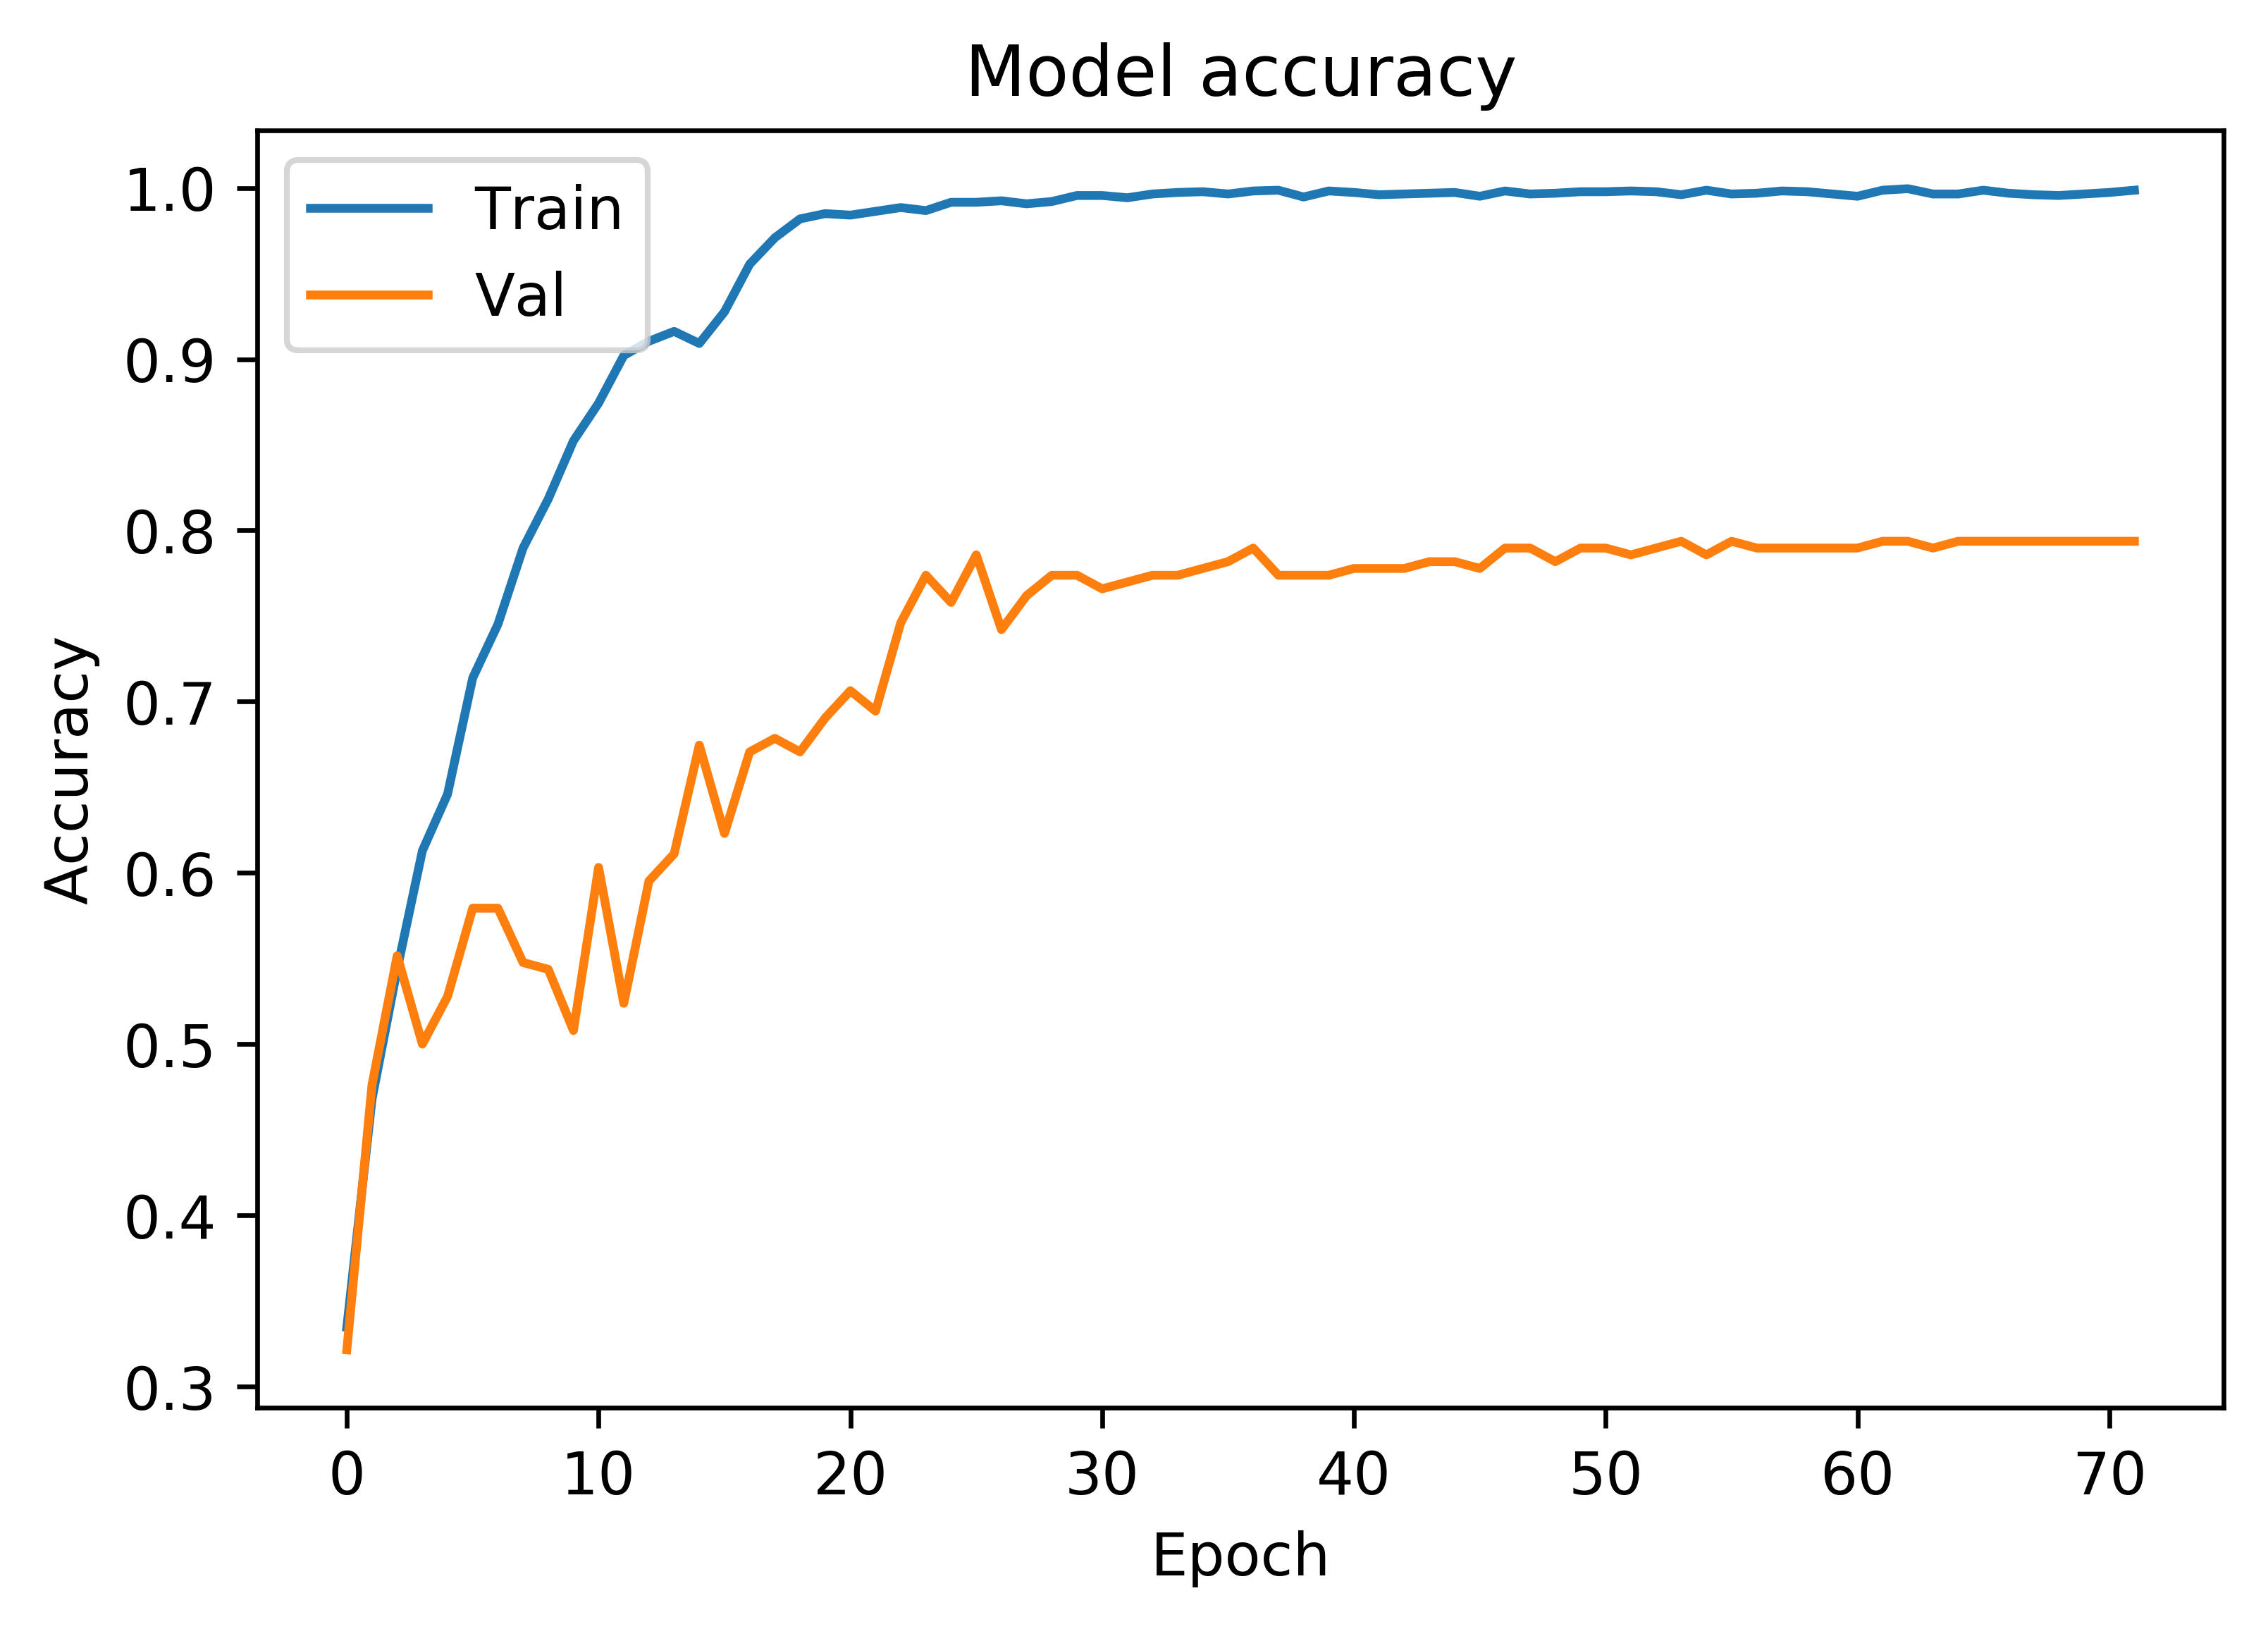

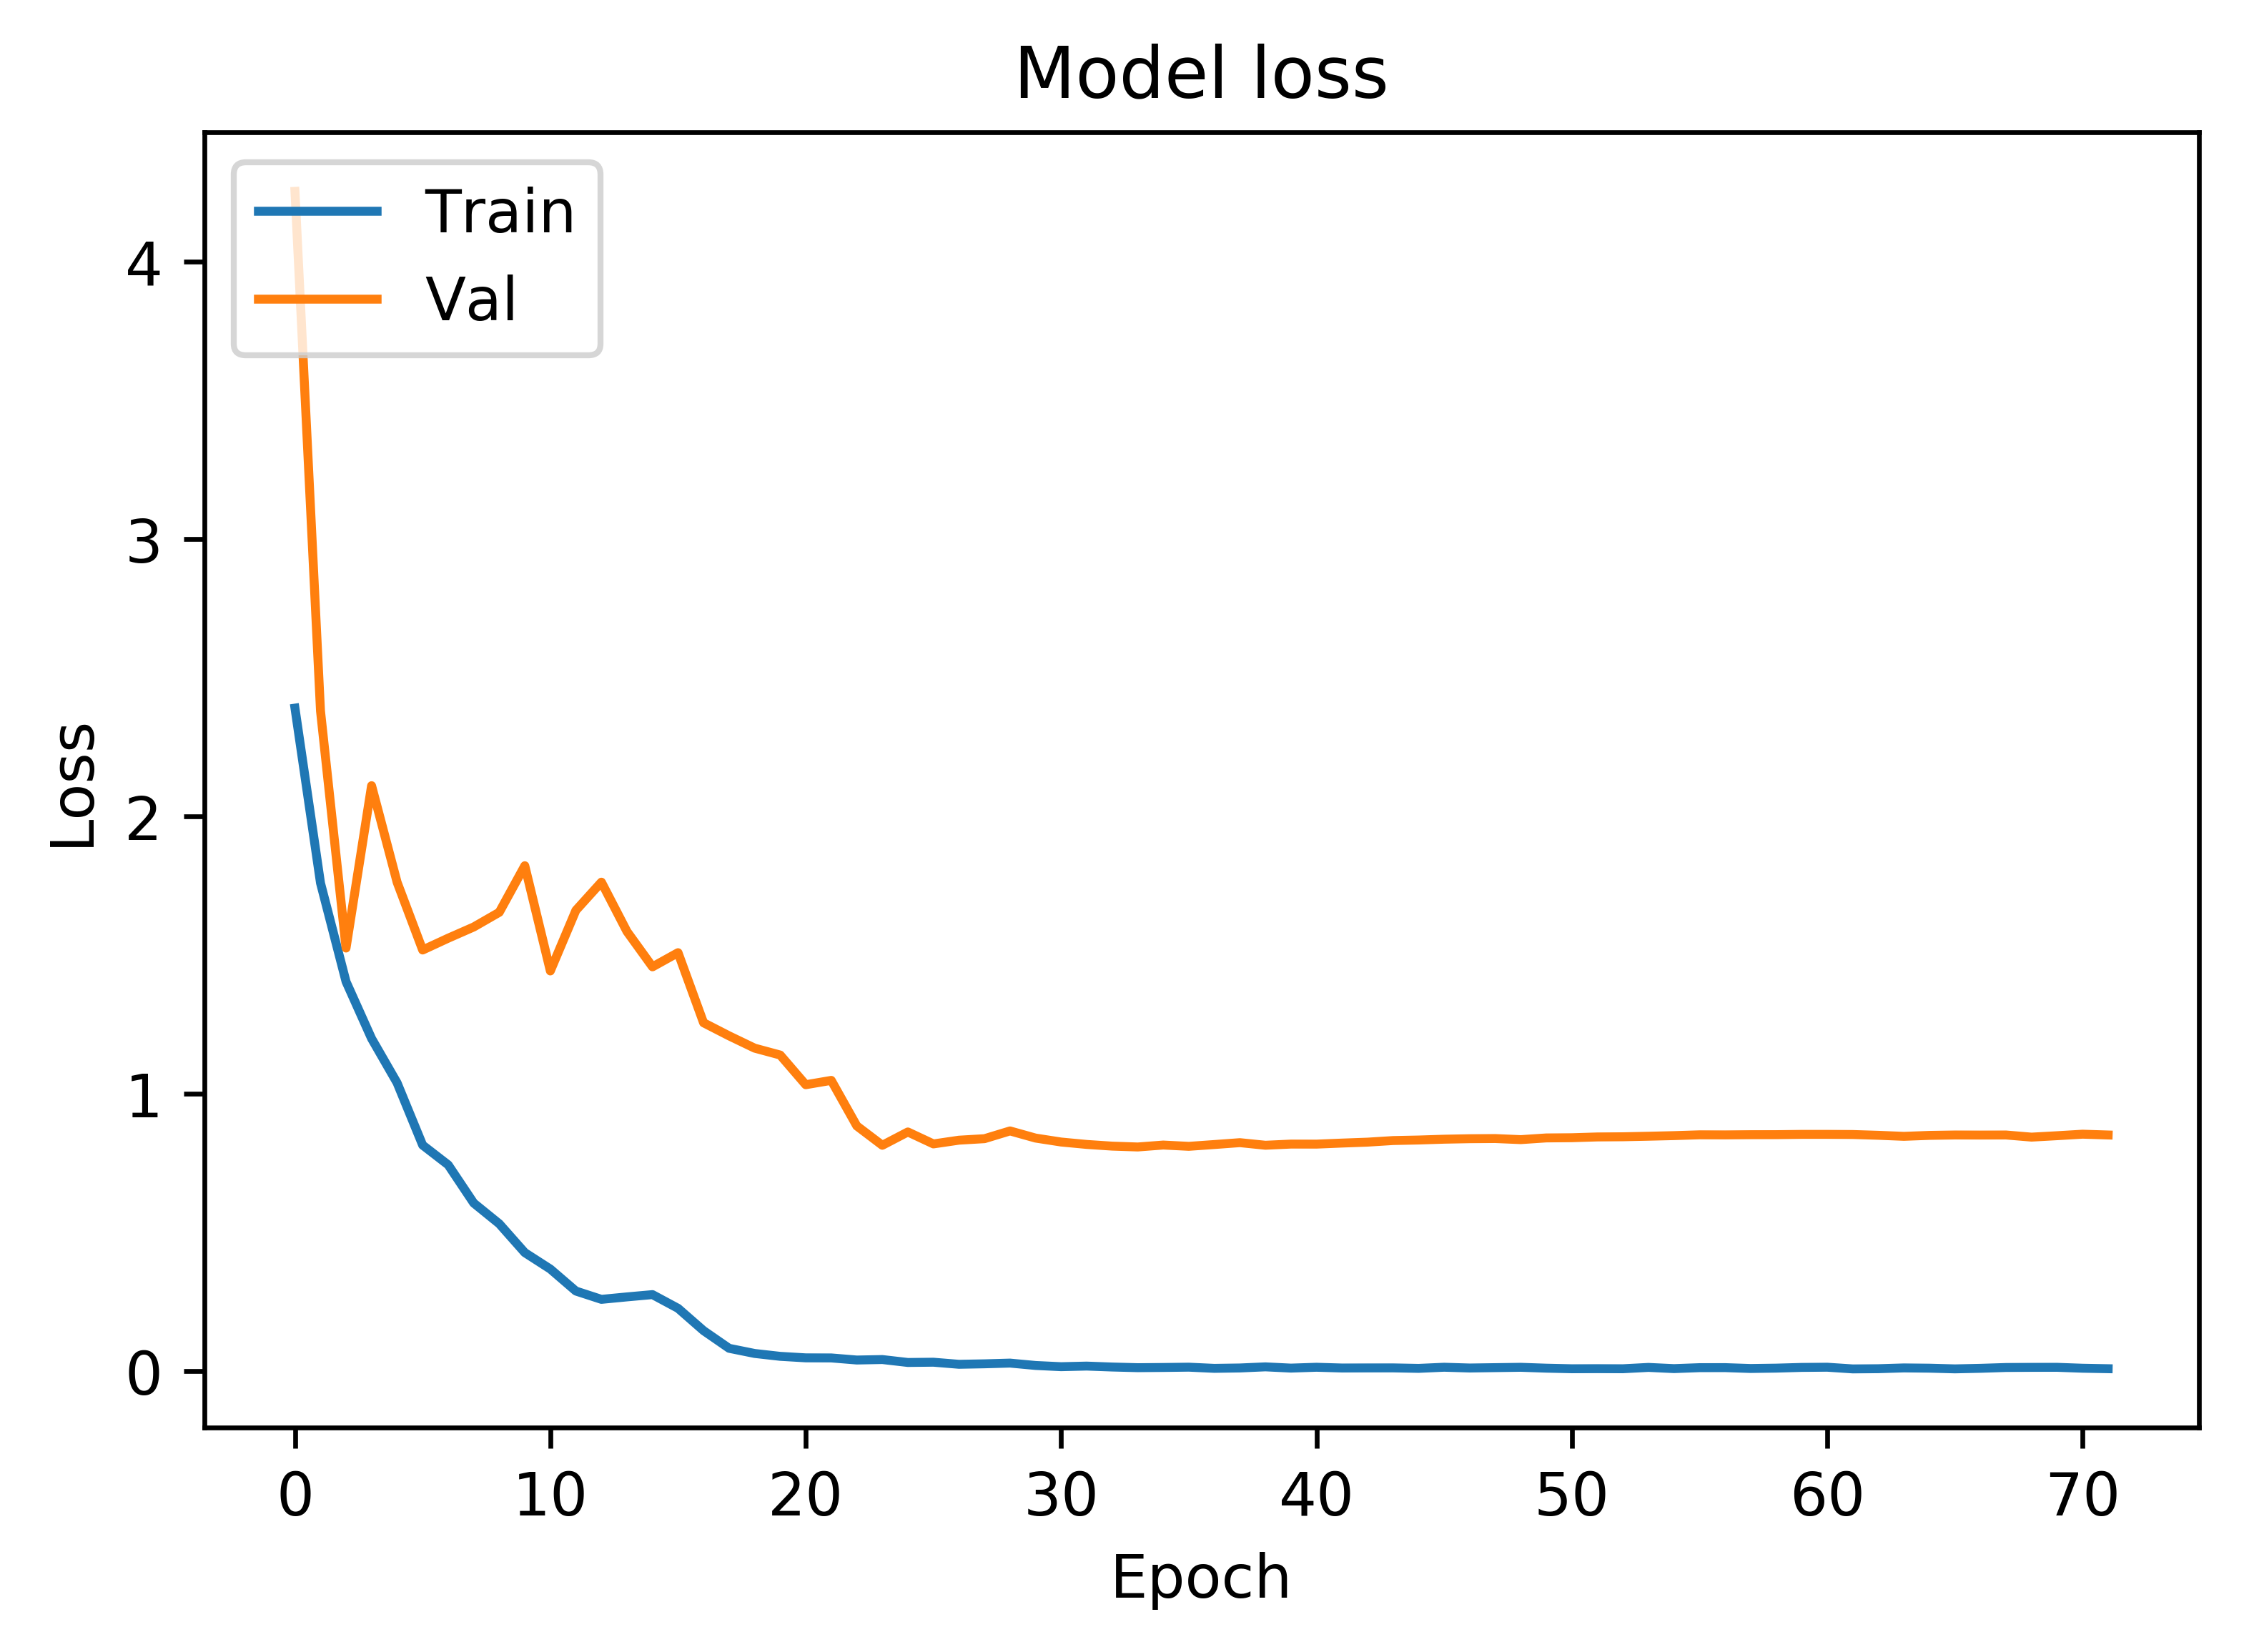

Results from K-fold: 4
acc: 81.25%
624/624 [==============================] - 0s 748us/step
[0.6999830221518492, 0.8125]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         68    1        2     3          0         0     4          0
gel          1   72        3     0          0         1     0          1
network      1    3       49     5          1         5     8          6
plot         3    1        1    57          0         0    16          0
histology    0    0        1     0         74         0     0          3
sequence     1    4        5     0          2        63     1          2
line         1    1        1     8          2         0    63          2
molecular    0    0        7     0          5         1     4         61
              precision    recall  f1-score   support

         bar       0.91      0.87      0.89        78
         gel       0.88      0.92      0.90        78
     network       0.71      0.63      0.67        78
     

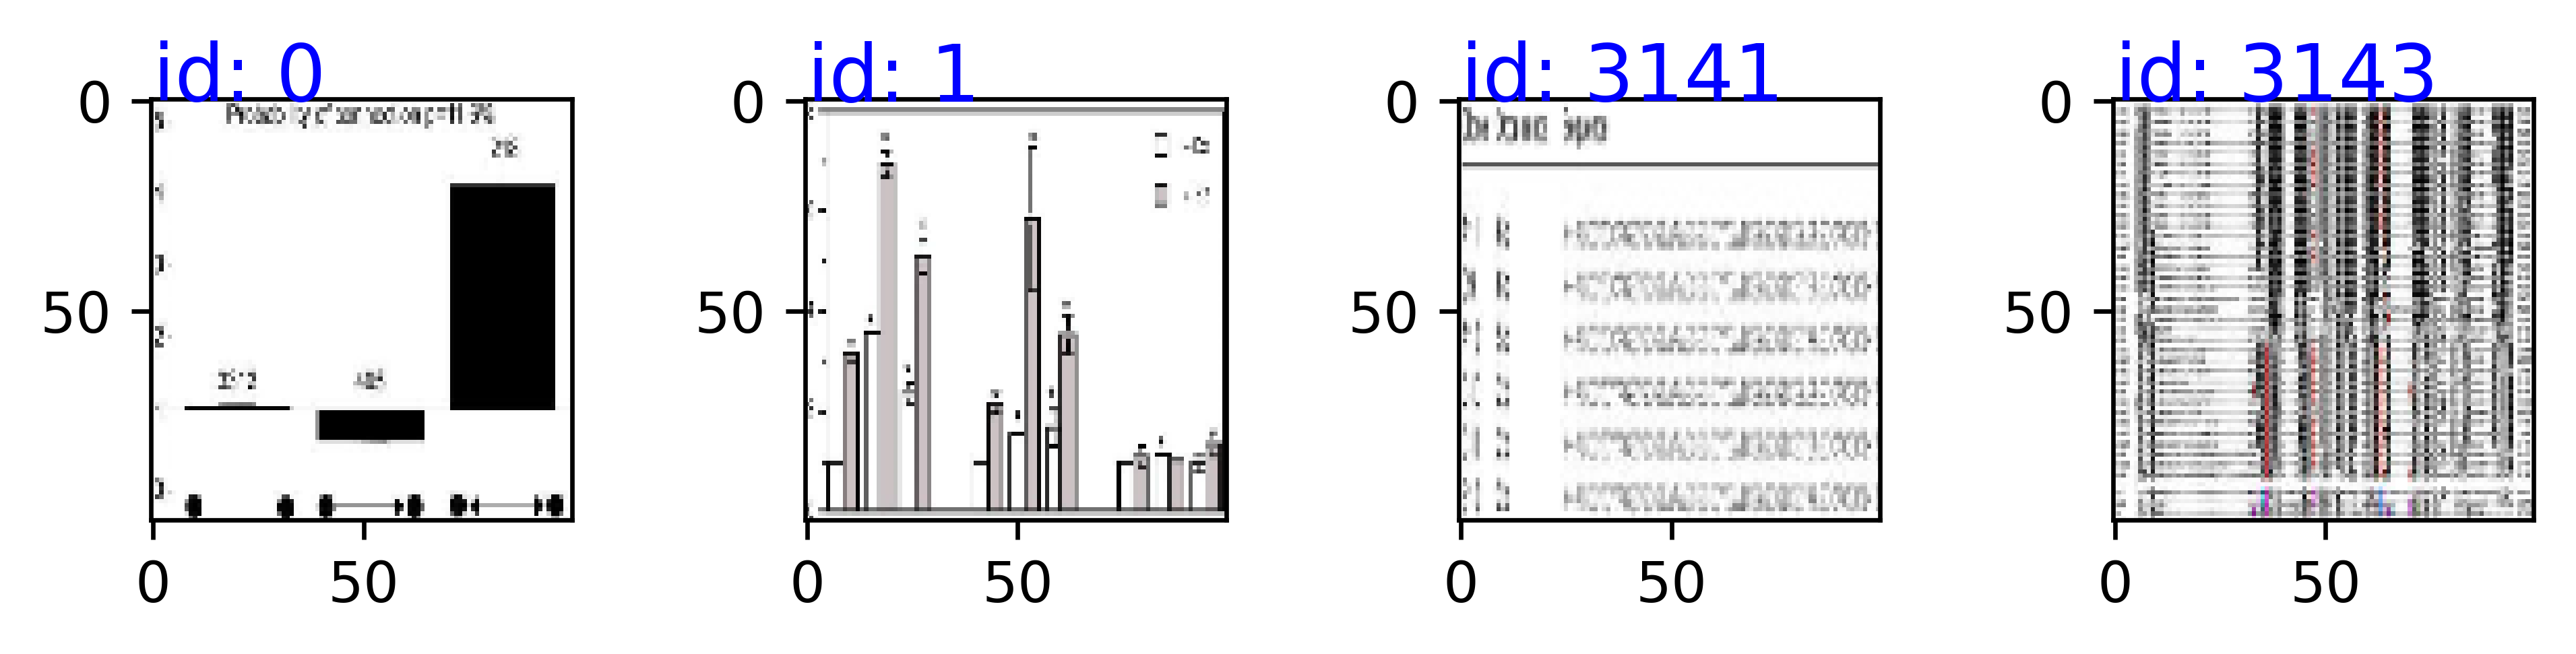

Samples from Testing
[   9   25 3136 3142]


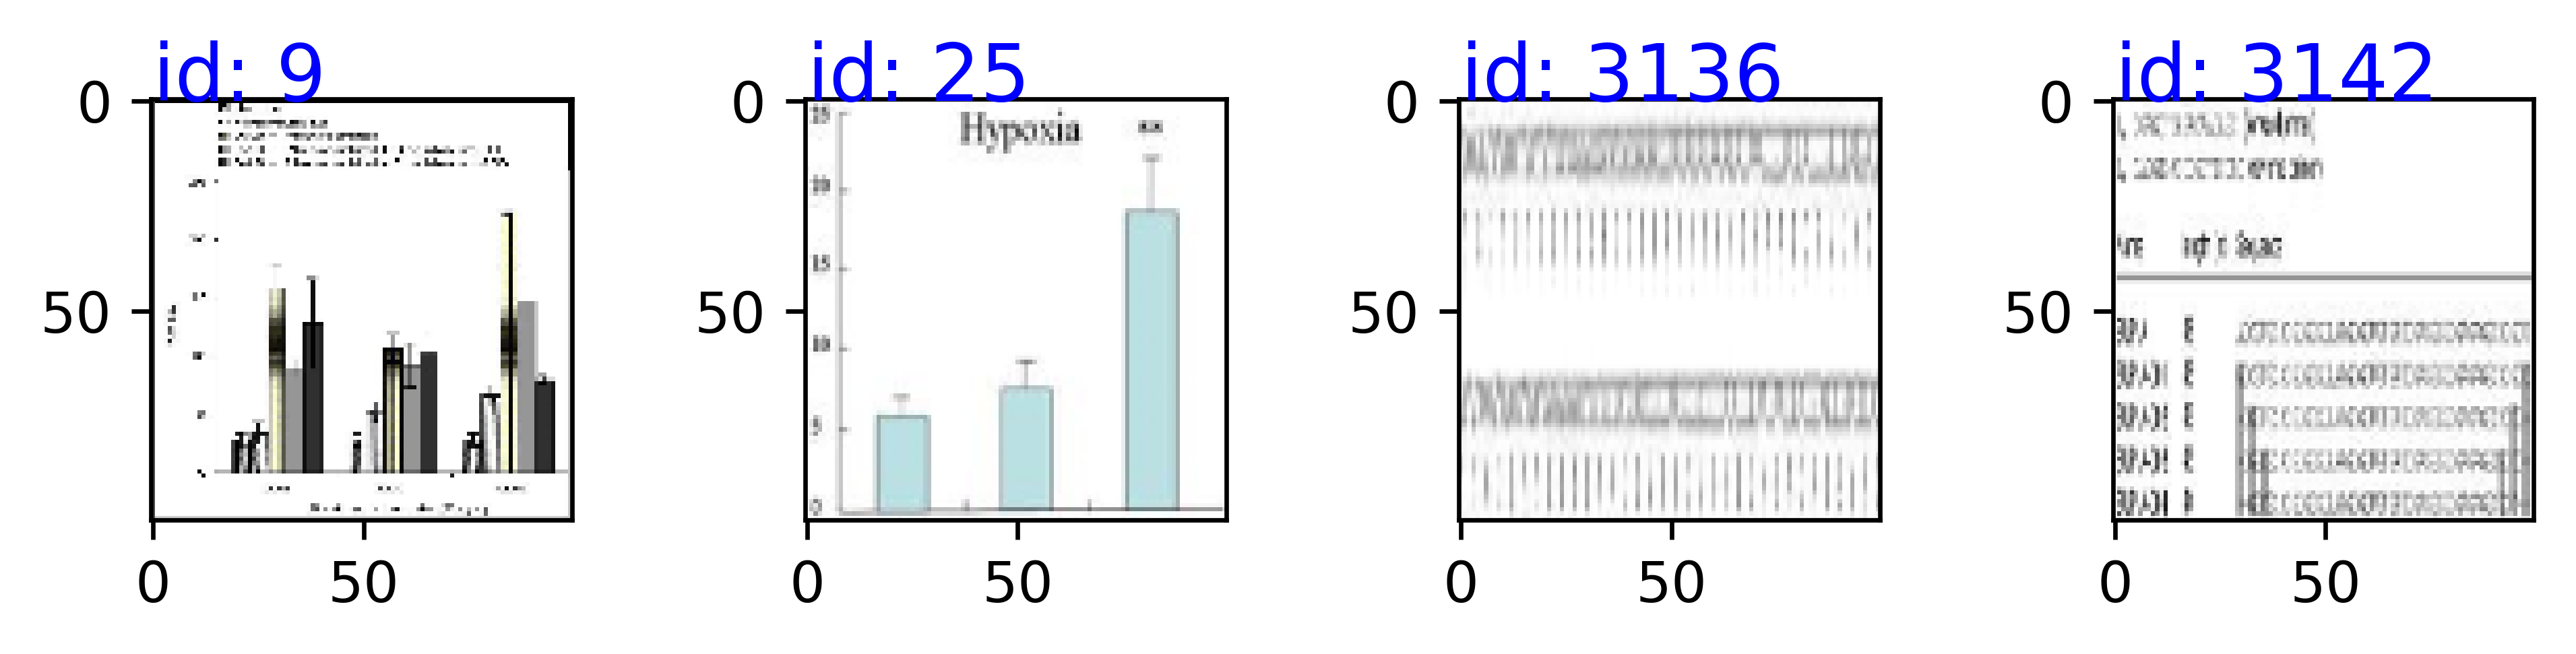

[INFO] training with 2 GPUs...
Train on 2268 samples, validate on 252 samples
Epoch 1/150
2268/2268 [==============================] - 8s 4ms/step - loss: 2.3329 - acc: 0.3408 - val_loss: 2.7046 - val_acc: 0.3968

Epoch 00001: val_acc improved from -inf to 0.39683, saving model to unimodal_weights/best_weight_image_only_k-fold_5.hdf5
Epoch 2/150
2268/2268 [==============================] - 3s 1ms/step - loss: 1.8006 - acc: 0.4603 - val_loss: 2.2871 - val_acc: 0.4802

Epoch 00002: val_acc improved from 0.39683 to 0.48016, saving model to unimodal_weights/best_weight_image_only_k-fold_5.hdf5
Epoch 3/150
2268/2268 [==============================] - 3s 1ms/step - loss: 1.3779 - acc: 0.5516 - val_loss: 1.7797 - val_acc: 0.5317

Epoch 00003: val_acc improved from 0.48016 to 0.53175, saving model to unimodal_weights/best_weight_image_only_k-fold_5.hdf5
Epoch 4/150
2268/2268 [==============================] - 3s 1ms/step - loss: 1.1796 - acc: 0.6287 - val_loss: 1.9020 - val_acc: 0.5040

Epoch 

2268/2268 [==============================] - 3s 1ms/step - loss: 0.0098 - acc: 0.9978 - val_loss: 0.7987 - val_acc: 0.8056

Epoch 00038: val_acc improved from 0.79762 to 0.80556, saving model to unimodal_weights/best_weight_image_only_k-fold_5.hdf5
Epoch 39/150
2268/2268 [==============================] - 3s 1ms/step - loss: 0.0091 - acc: 0.9987 - val_loss: 0.8028 - val_acc: 0.8016

Epoch 00039: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00039: val_acc did not improve from 0.80556
Epoch 40/150
2268/2268 [==============================] - 3s 1ms/step - loss: 0.0092 - acc: 0.9987 - val_loss: 0.8005 - val_acc: 0.8016

Epoch 00040: val_acc did not improve from 0.80556
Epoch 41/150
2268/2268 [==============================] - 3s 1ms/step - loss: 0.0078 - acc: 0.9991 - val_loss: 0.8014 - val_acc: 0.7976

Epoch 00041: val_acc did not improve from 0.80556
Epoch 42/150
2268/2268 [==============================] - 3s 1ms/step - loss: 0.0101 - acc: 0.9991 - val_loss

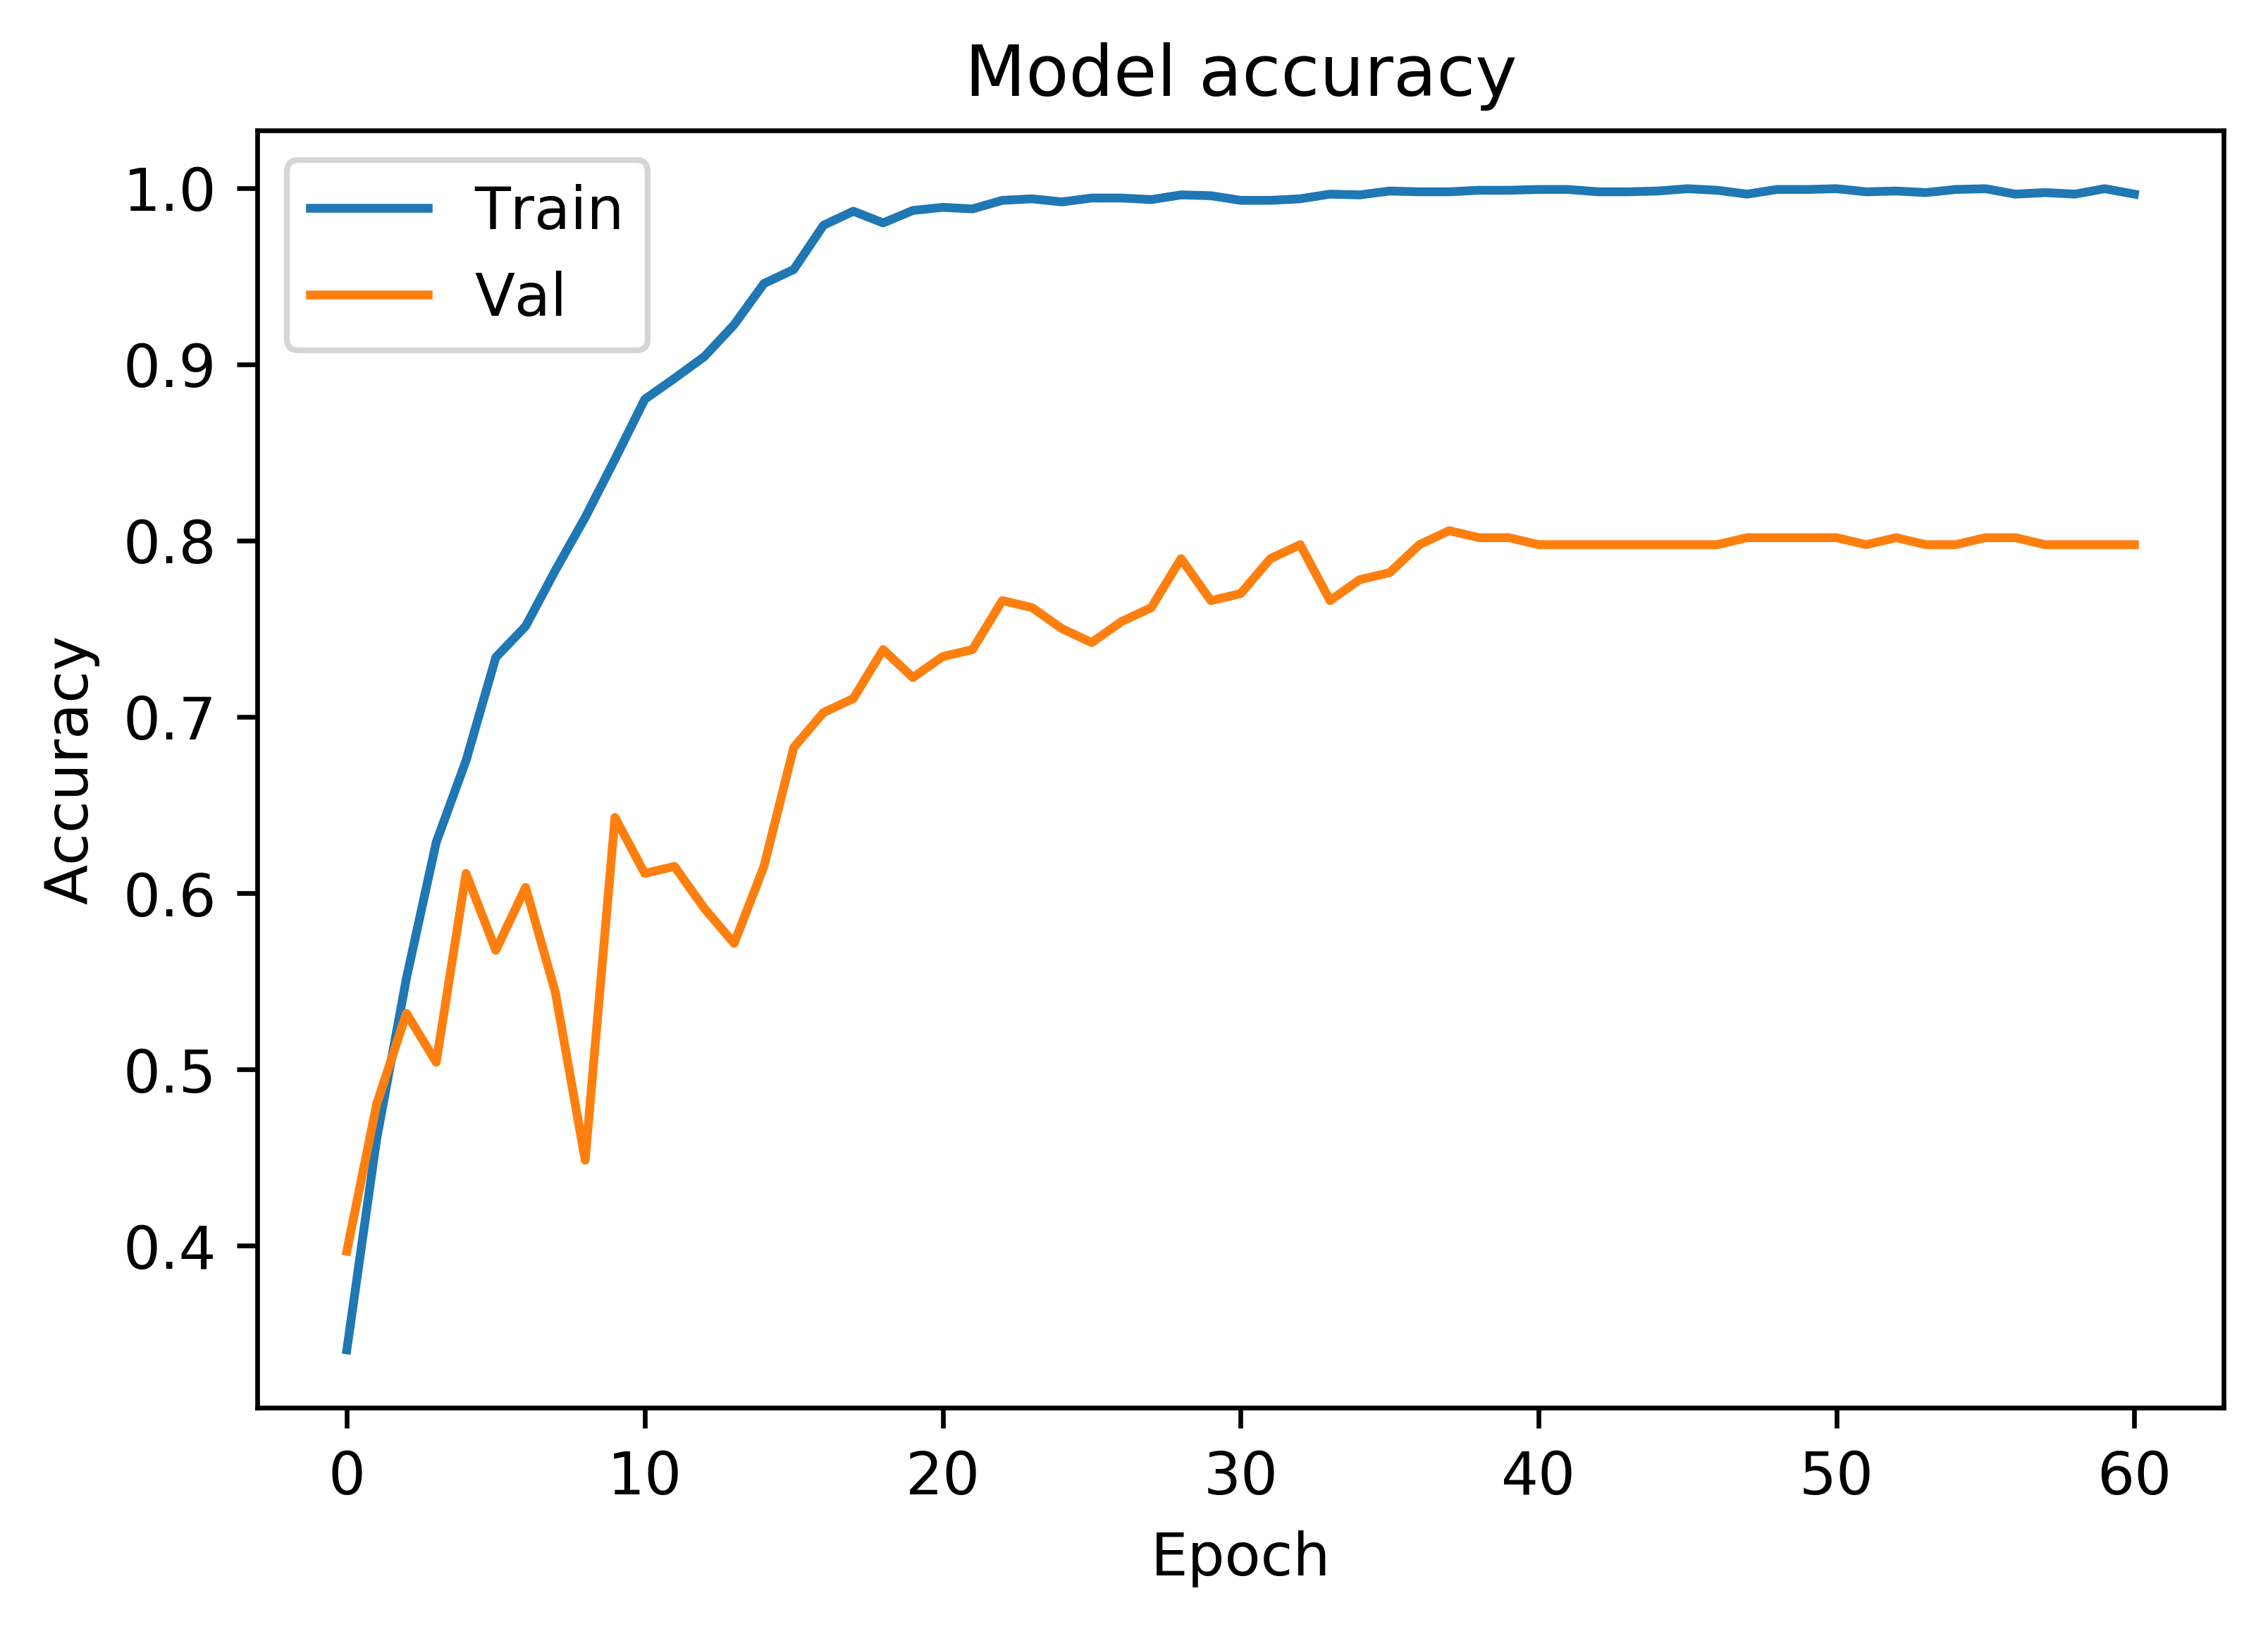

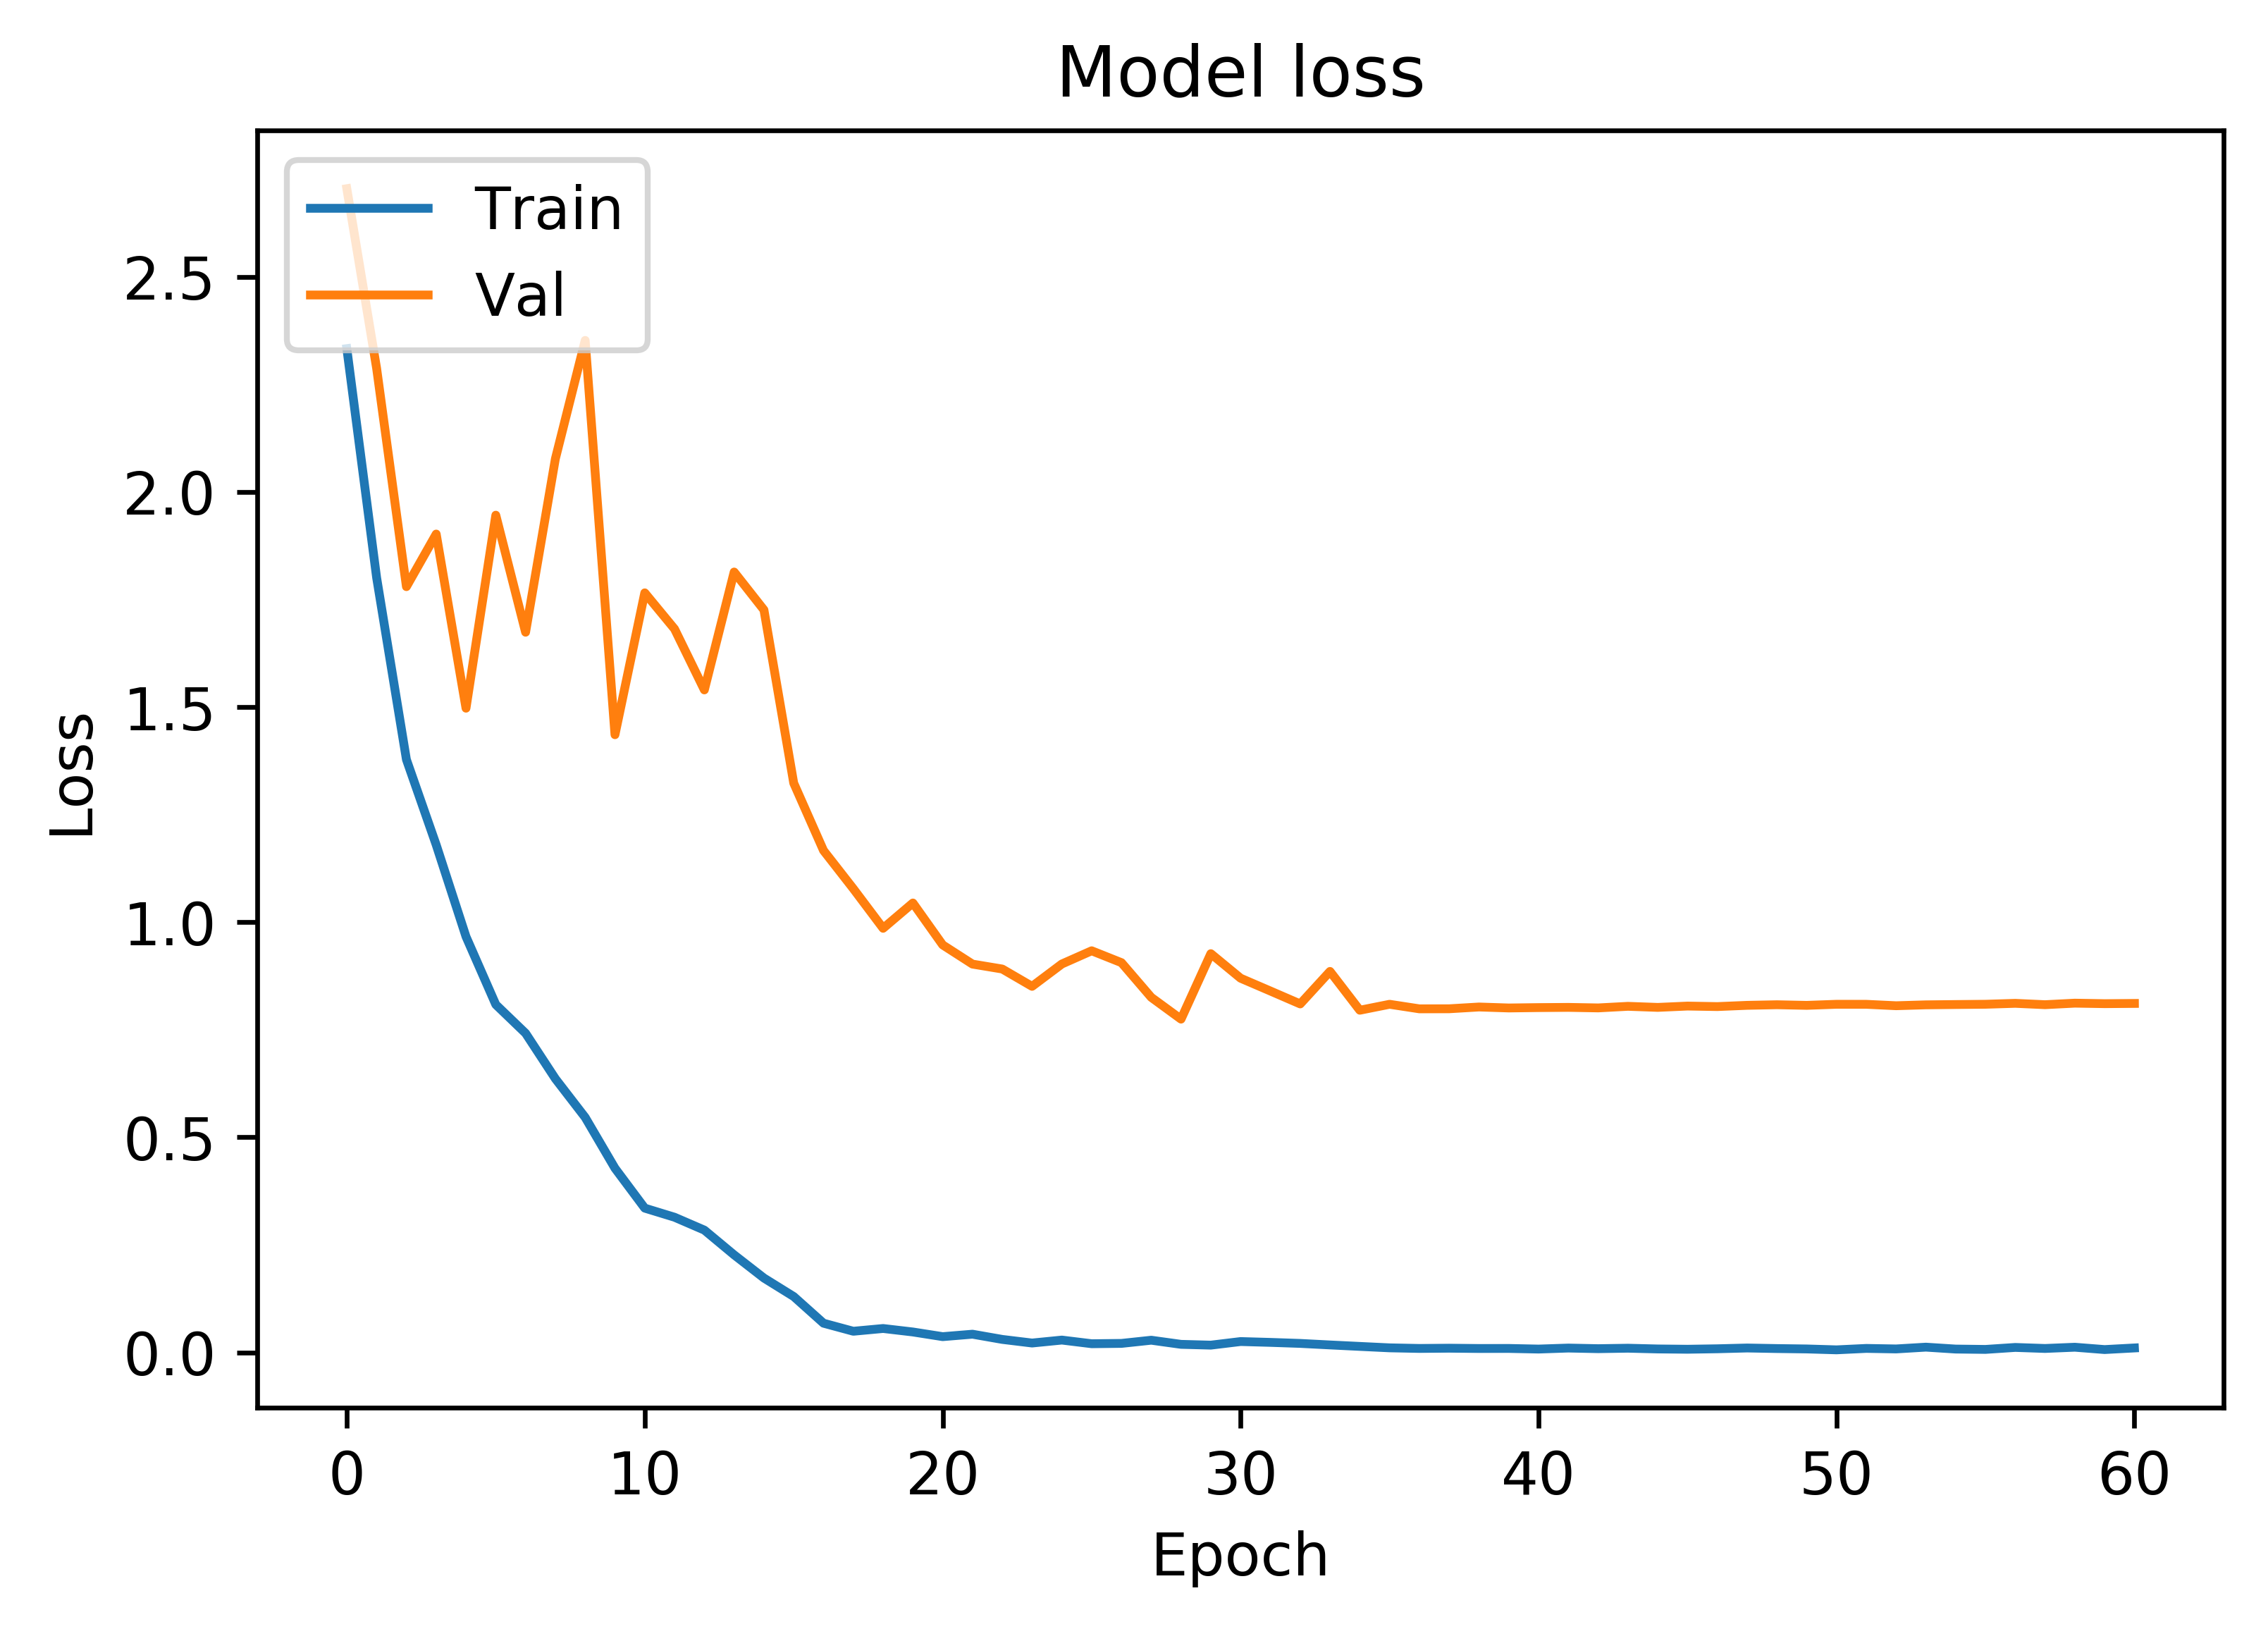

Results from K-fold: 5
acc: 81.89%
624/624 [==============================] - 0s 762us/step
[0.8112386994254894, 0.8189102564102564]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         67    0        3     4          1         0     3          0
gel          0   66        0     3          4         2     2          1
network      1    1       51     0          4         7     7          7
plot         2    0        5    59          1         1    10          0
histology    0    0        0     0         75         0     1          2
sequence     0    0        9     2          0        66     1          0
line         2    0        6     8          1         2    54          5
molecular    0    0        3     0          1         0     1         73
              precision    recall  f1-score   support

         bar       0.93      0.86      0.89        78
         gel       0.99      0.85      0.91        78
     network       0.66      0.65      0.66    

In [11]:
#set K folds to 5

cvscores = []
count = 1
confusion_matrix_list = []
report_list = []

for key, val in kfolds.items():
    print(key)
    train = val['train']
    test = val['test']
    
    print('K-: {}'.format(key))
            
    print("Samples from Training")
    print_samples(samples=train, images=X_image)
    print("============================")
    
    print("Samples from Testing")
    print_samples(samples=test, images=X_image)
    print("============================")
    
    random.shuffle(train)
    image_model = Generate_Model(model_type = "image")
    image_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    filepath="unimodal_weights/best_weight_image_only_k-fold_{}.hdf5".format(count)
    checkpoint = MultiGPUCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [reduce_lr, checkpoint, early_stopping]

    history = image_model.fit([X_image[train]], y[train], 
                     epochs=epochs, batch_size=bs, validation_split=0.1, callbacks=callbacks_list)
    plot_model_history(history)
    filepath="unimodal_weights/final_weight_image_only_k-fold_{}.hdf5".format(count)
    image_model.save_weights(filepath)
    scores = image_model.evaluate([X_image[test]], y[test], verbose=0)
    print('Results from K-fold: {}'.format(count))
    print("%s: %.2f%%" % (image_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    y_hat = test_model(image_model, zip(X_image[test], y[test]), image = True, text = False, 
                       class_names=class_names)
    cm = confusion_matrix([np.argmax(t) for t in y[test]], y_hat)
    confusion_matrix_list.append(pd.DataFrame(cm, index=class_names, columns=class_names))
    cr = classification_report([np.argmax(t) for t in y[test]], y_hat, target_names=class_names)
    report_list.append(classification_report_df(cr))
    count += 1
    print('================================================')
print('Average for kfold accuracy and stdev')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Average classification report for all folds")
print(df_mean(report_list))

### K fold validation on text_1d only

fold_1
K-: fold_1
Samples from Training
[1518  867  152 3131]
id: 1518
influence united states airline volume influenza spread timing yearly transmission influenza seasons association airline travel september december timing us influenza peak displayed airline volume significantly predicts timing seasonal influenza mortality r p timing seasonal national influenza mortality blue dots estimated cross-correlation season season b association airline travel september december time transnational us spread displayed numbers traveling domestic passengers significantly predicts transnational influenza spread r p index spread influenza blue dots estimated confidence interval cross-correlation values nine major geographic regions united states national curve give year previously described 
id: 867
- 
id: 152
fap gene expression upregulated il- oncostatin osm chondrocytes sw cells treated combinations il- osm h total rna extracted fap gene expression determined real-time pcr described materials me


Epoch 00016: val_acc did not improve from 0.80159
Epoch 17/150
2260/2260 [==============================] - 0s 136us/step - loss: 0.4073 - acc: 0.8650 - val_loss: 0.6787 - val_acc: 0.8095

Epoch 00017: val_acc improved from 0.80159 to 0.80952, saving model to unimodal_weights/best_weight_text_1d_only_k-fold_1.hdf5
Epoch 18/150
2260/2260 [==============================] - 0s 174us/step - loss: 0.3634 - acc: 0.8730 - val_loss: 0.6547 - val_acc: 0.7897

Epoch 00018: val_acc did not improve from 0.80952
Epoch 19/150
2260/2260 [==============================] - 0s 135us/step - loss: 0.3501 - acc: 0.8841 - val_loss: 0.6909 - val_acc: 0.7897

Epoch 00019: val_acc did not improve from 0.80952
Epoch 20/150
2260/2260 [==============================] - 0s 131us/step - loss: 0.3138 - acc: 0.8938 - val_loss: 0.6607 - val_acc: 0.8413

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00020: val_acc improved from 0.80952 to 0.84127, saving model to unimodal_weig

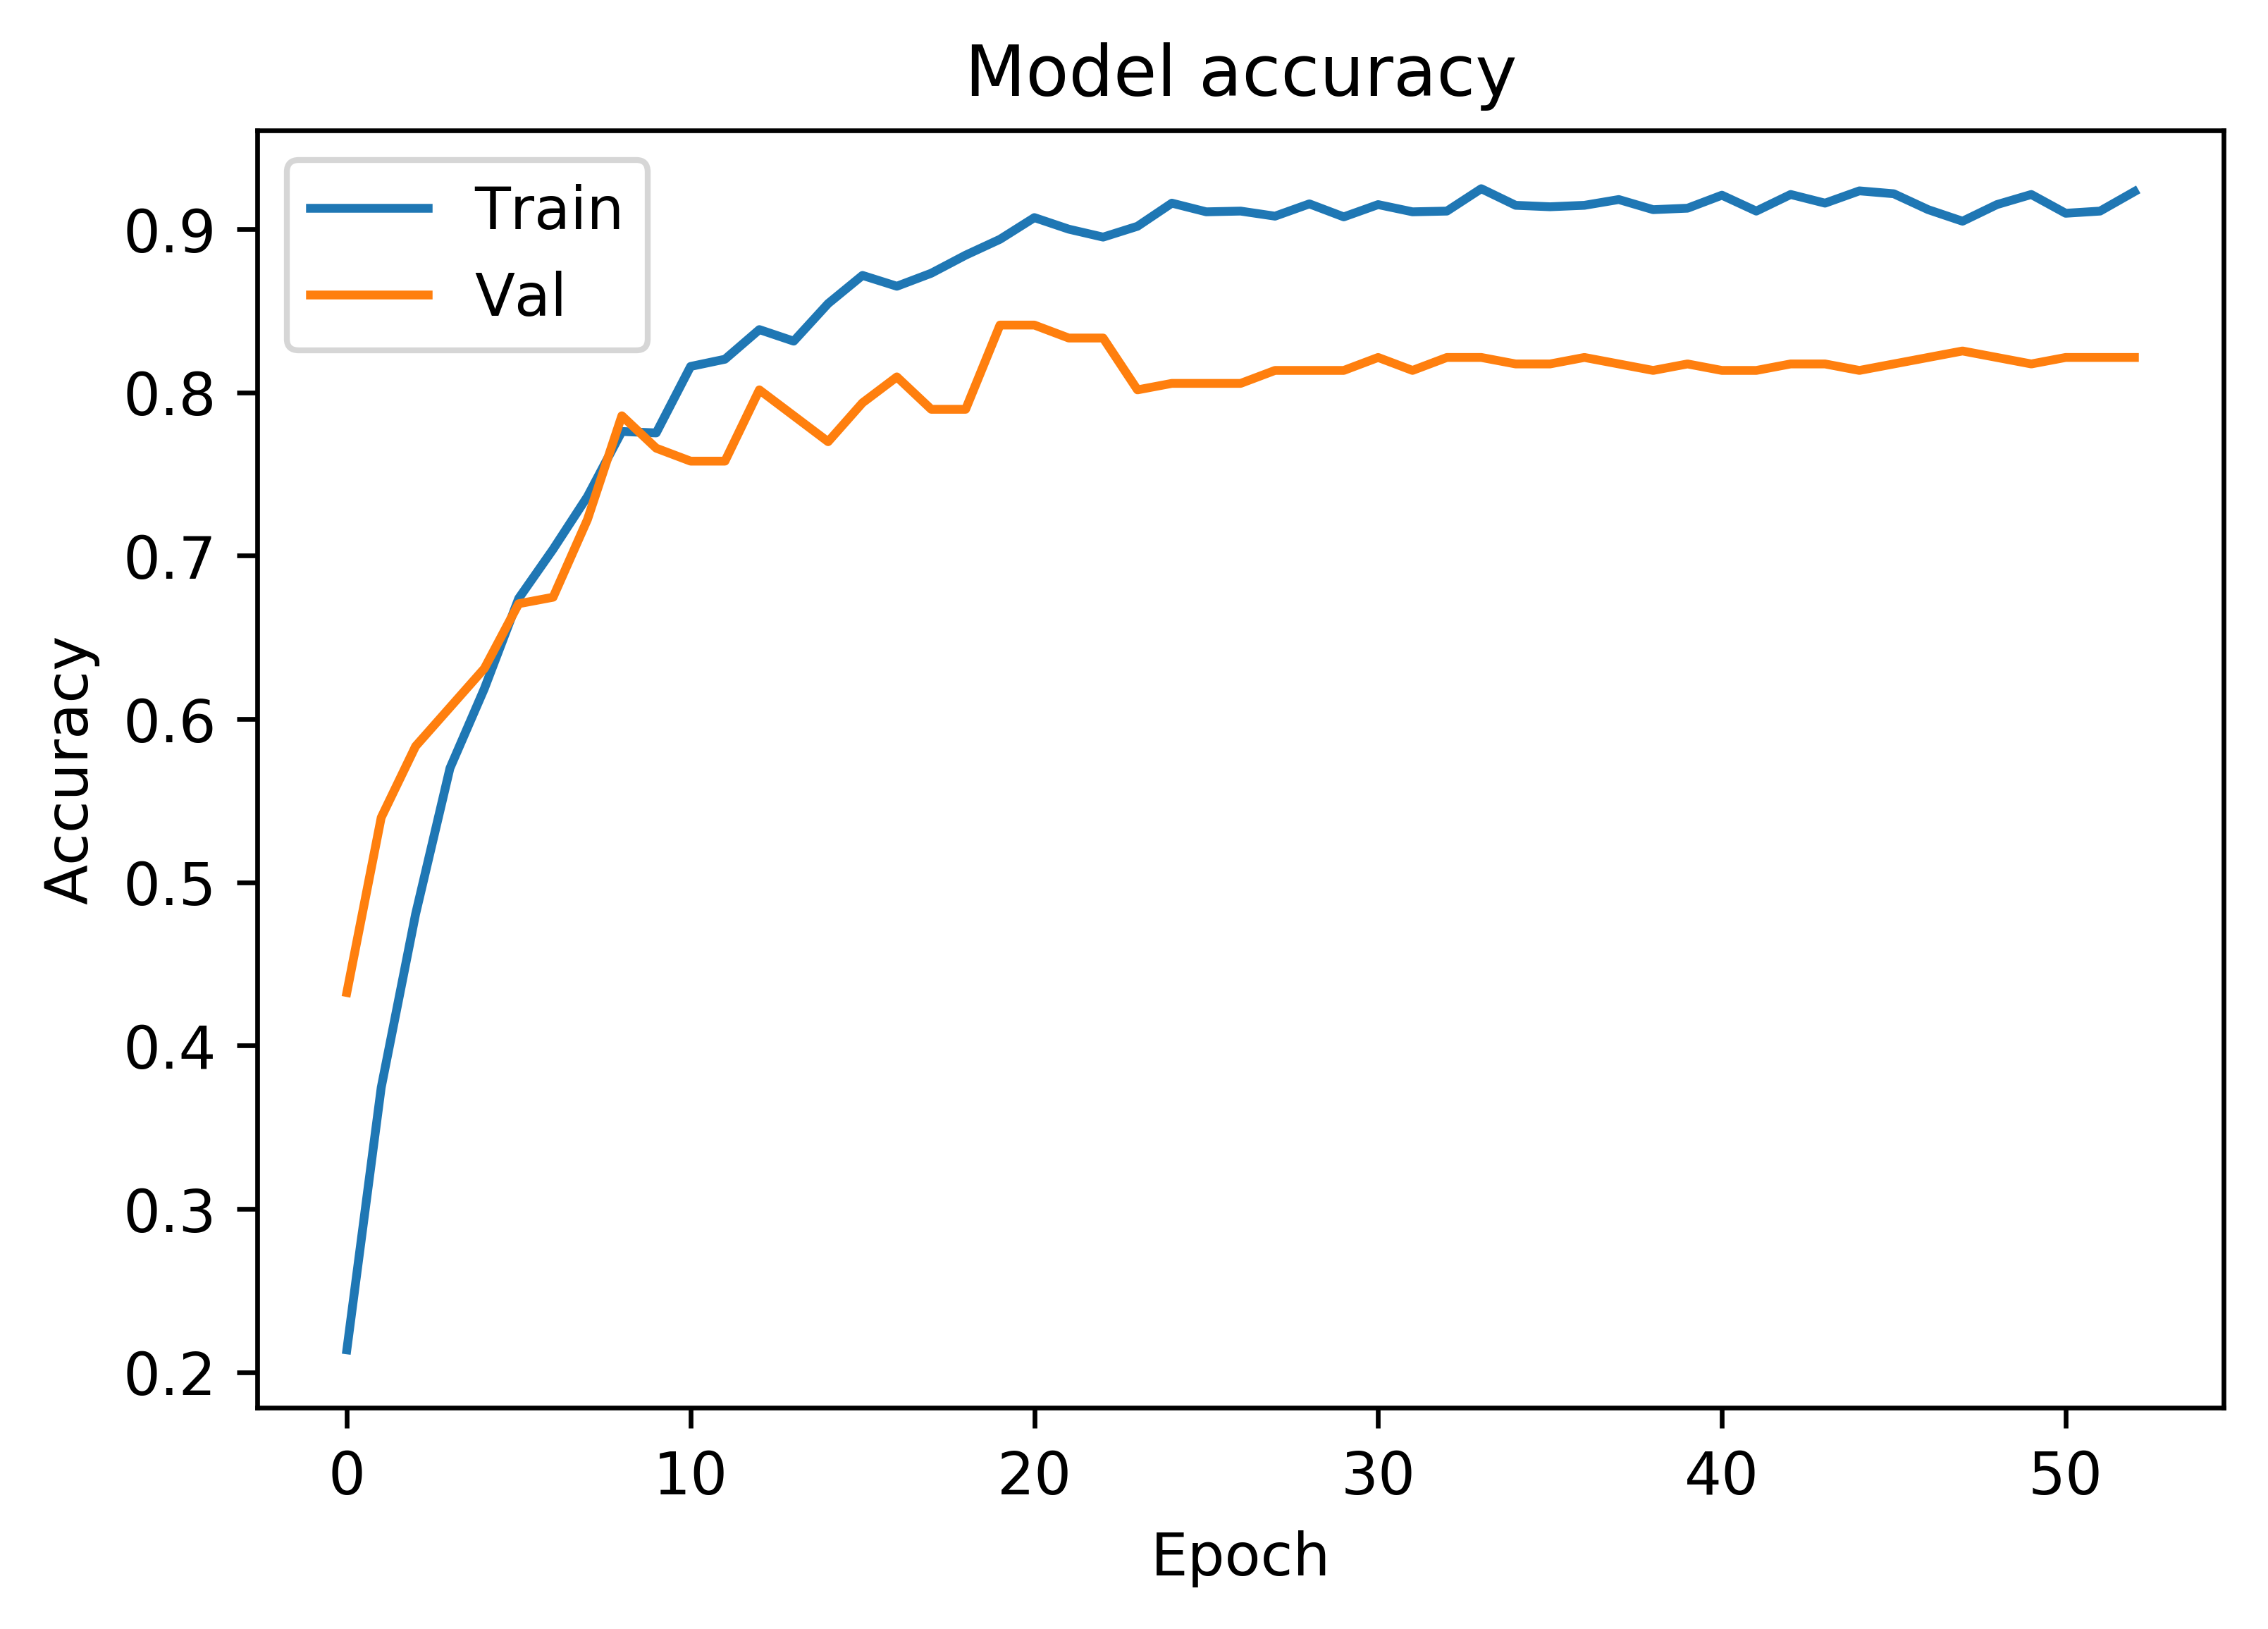

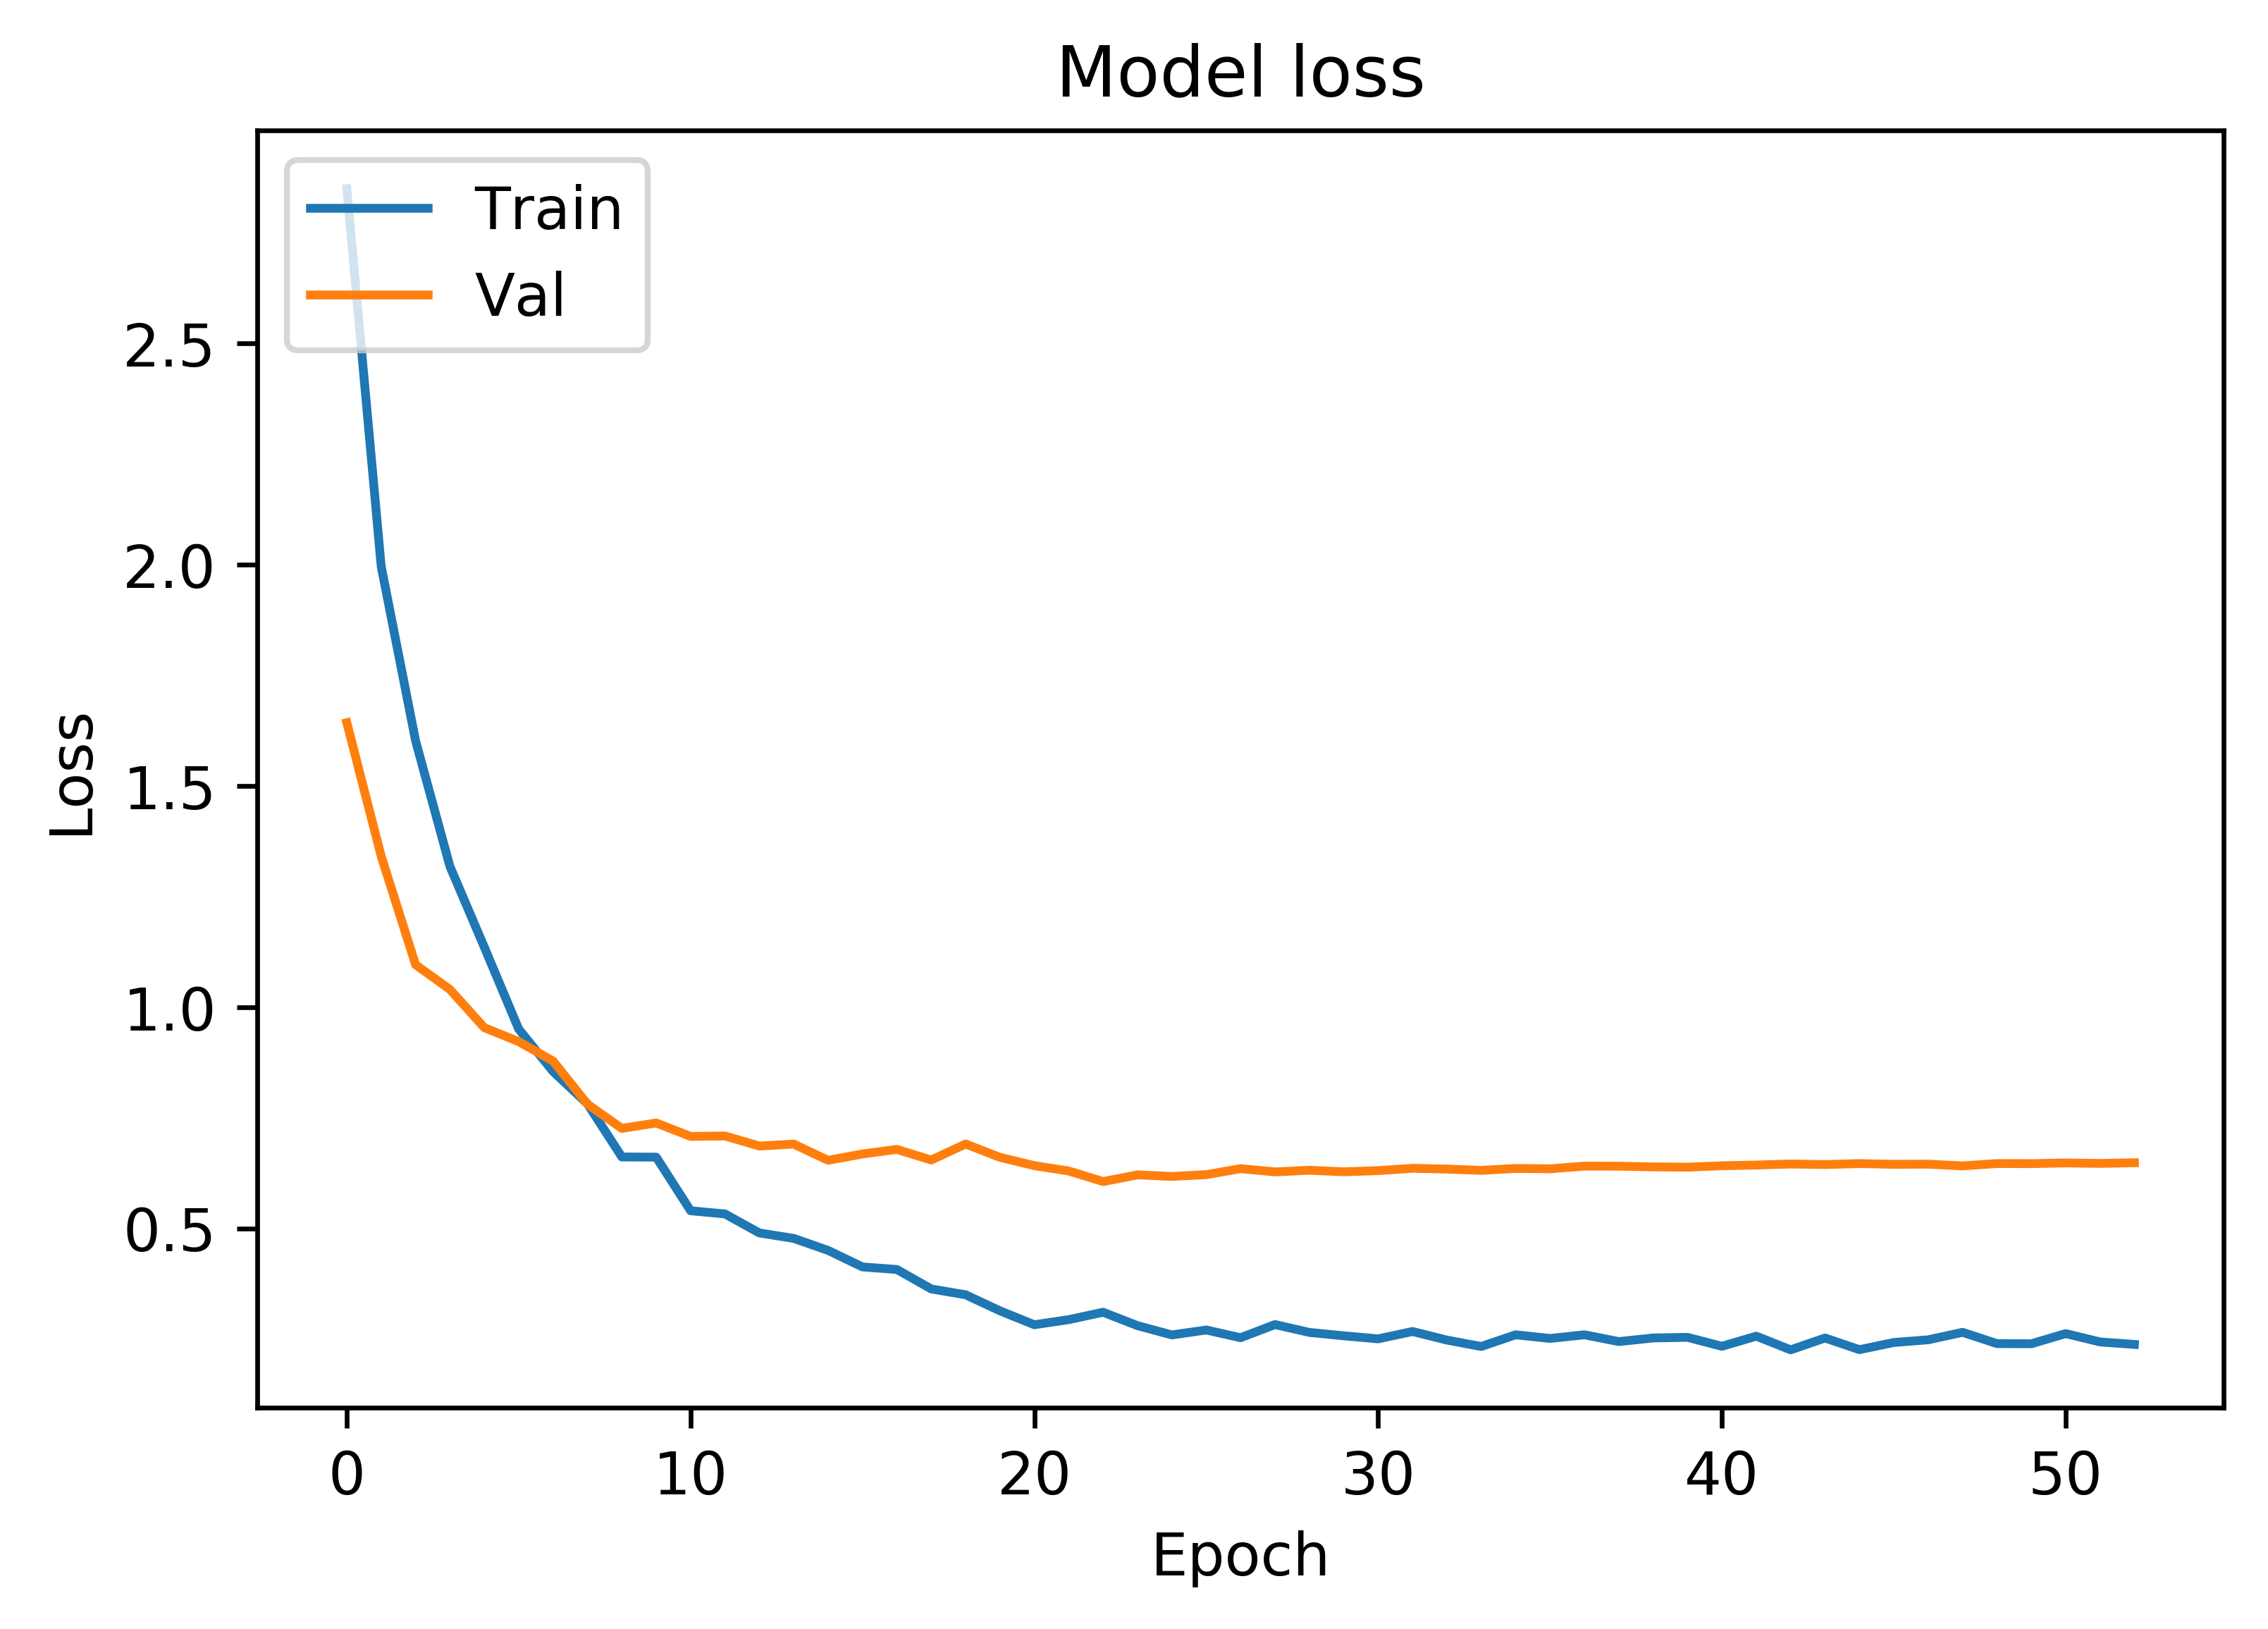

Results from K-fold: 1
acc: 78.16%
632/632 [==============================] - 0s 163us/step
[0.8738269158933736, 0.781645568865764]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         49    4        3     5          7         0     9          2
gel          6   57        0     1          9         3     3          0
network      3    0       69     0          3         0     3          1
plot        10    1        3    51          2         0    11          1
histology    1    0        2     1         67         1     4          3
sequence     2    2        0     0          0        71     3          1
line         5    1        4     6          1         0    61          1
molecular    2    0        3     0          3         0     2         69
              precision    recall  f1-score   support

         bar       0.63      0.62      0.62        79
         gel       0.88      0.72      0.79        79
     network       0.82      0.87      0.85     

2260/2260 [==============================] - 0s 135us/step - loss: 0.4044 - acc: 0.8681 - val_loss: 1.0095 - val_acc: 0.7619

Epoch 00016: val_acc improved from 0.75397 to 0.76190, saving model to unimodal_weights/best_weight_text_1d_only_k-fold_2.hdf5
Epoch 17/150
2260/2260 [==============================] - 0s 141us/step - loss: 0.3526 - acc: 0.8850 - val_loss: 1.1051 - val_acc: 0.7540

Epoch 00017: val_acc did not improve from 0.76190
Epoch 18/150
2260/2260 [==============================] - 0s 137us/step - loss: 0.3377 - acc: 0.8867 - val_loss: 1.0656 - val_acc: 0.7579

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00018: val_acc did not improve from 0.76190
Epoch 19/150
2260/2260 [==============================] - 0s 153us/step - loss: 0.3399 - acc: 0.8872 - val_loss: 1.0605 - val_acc: 0.7460

Epoch 00019: val_acc did not improve from 0.76190
Epoch 20/150
2260/2260 [==============================] - 0s 135us/step - loss: 0.3176 - acc: 0.89

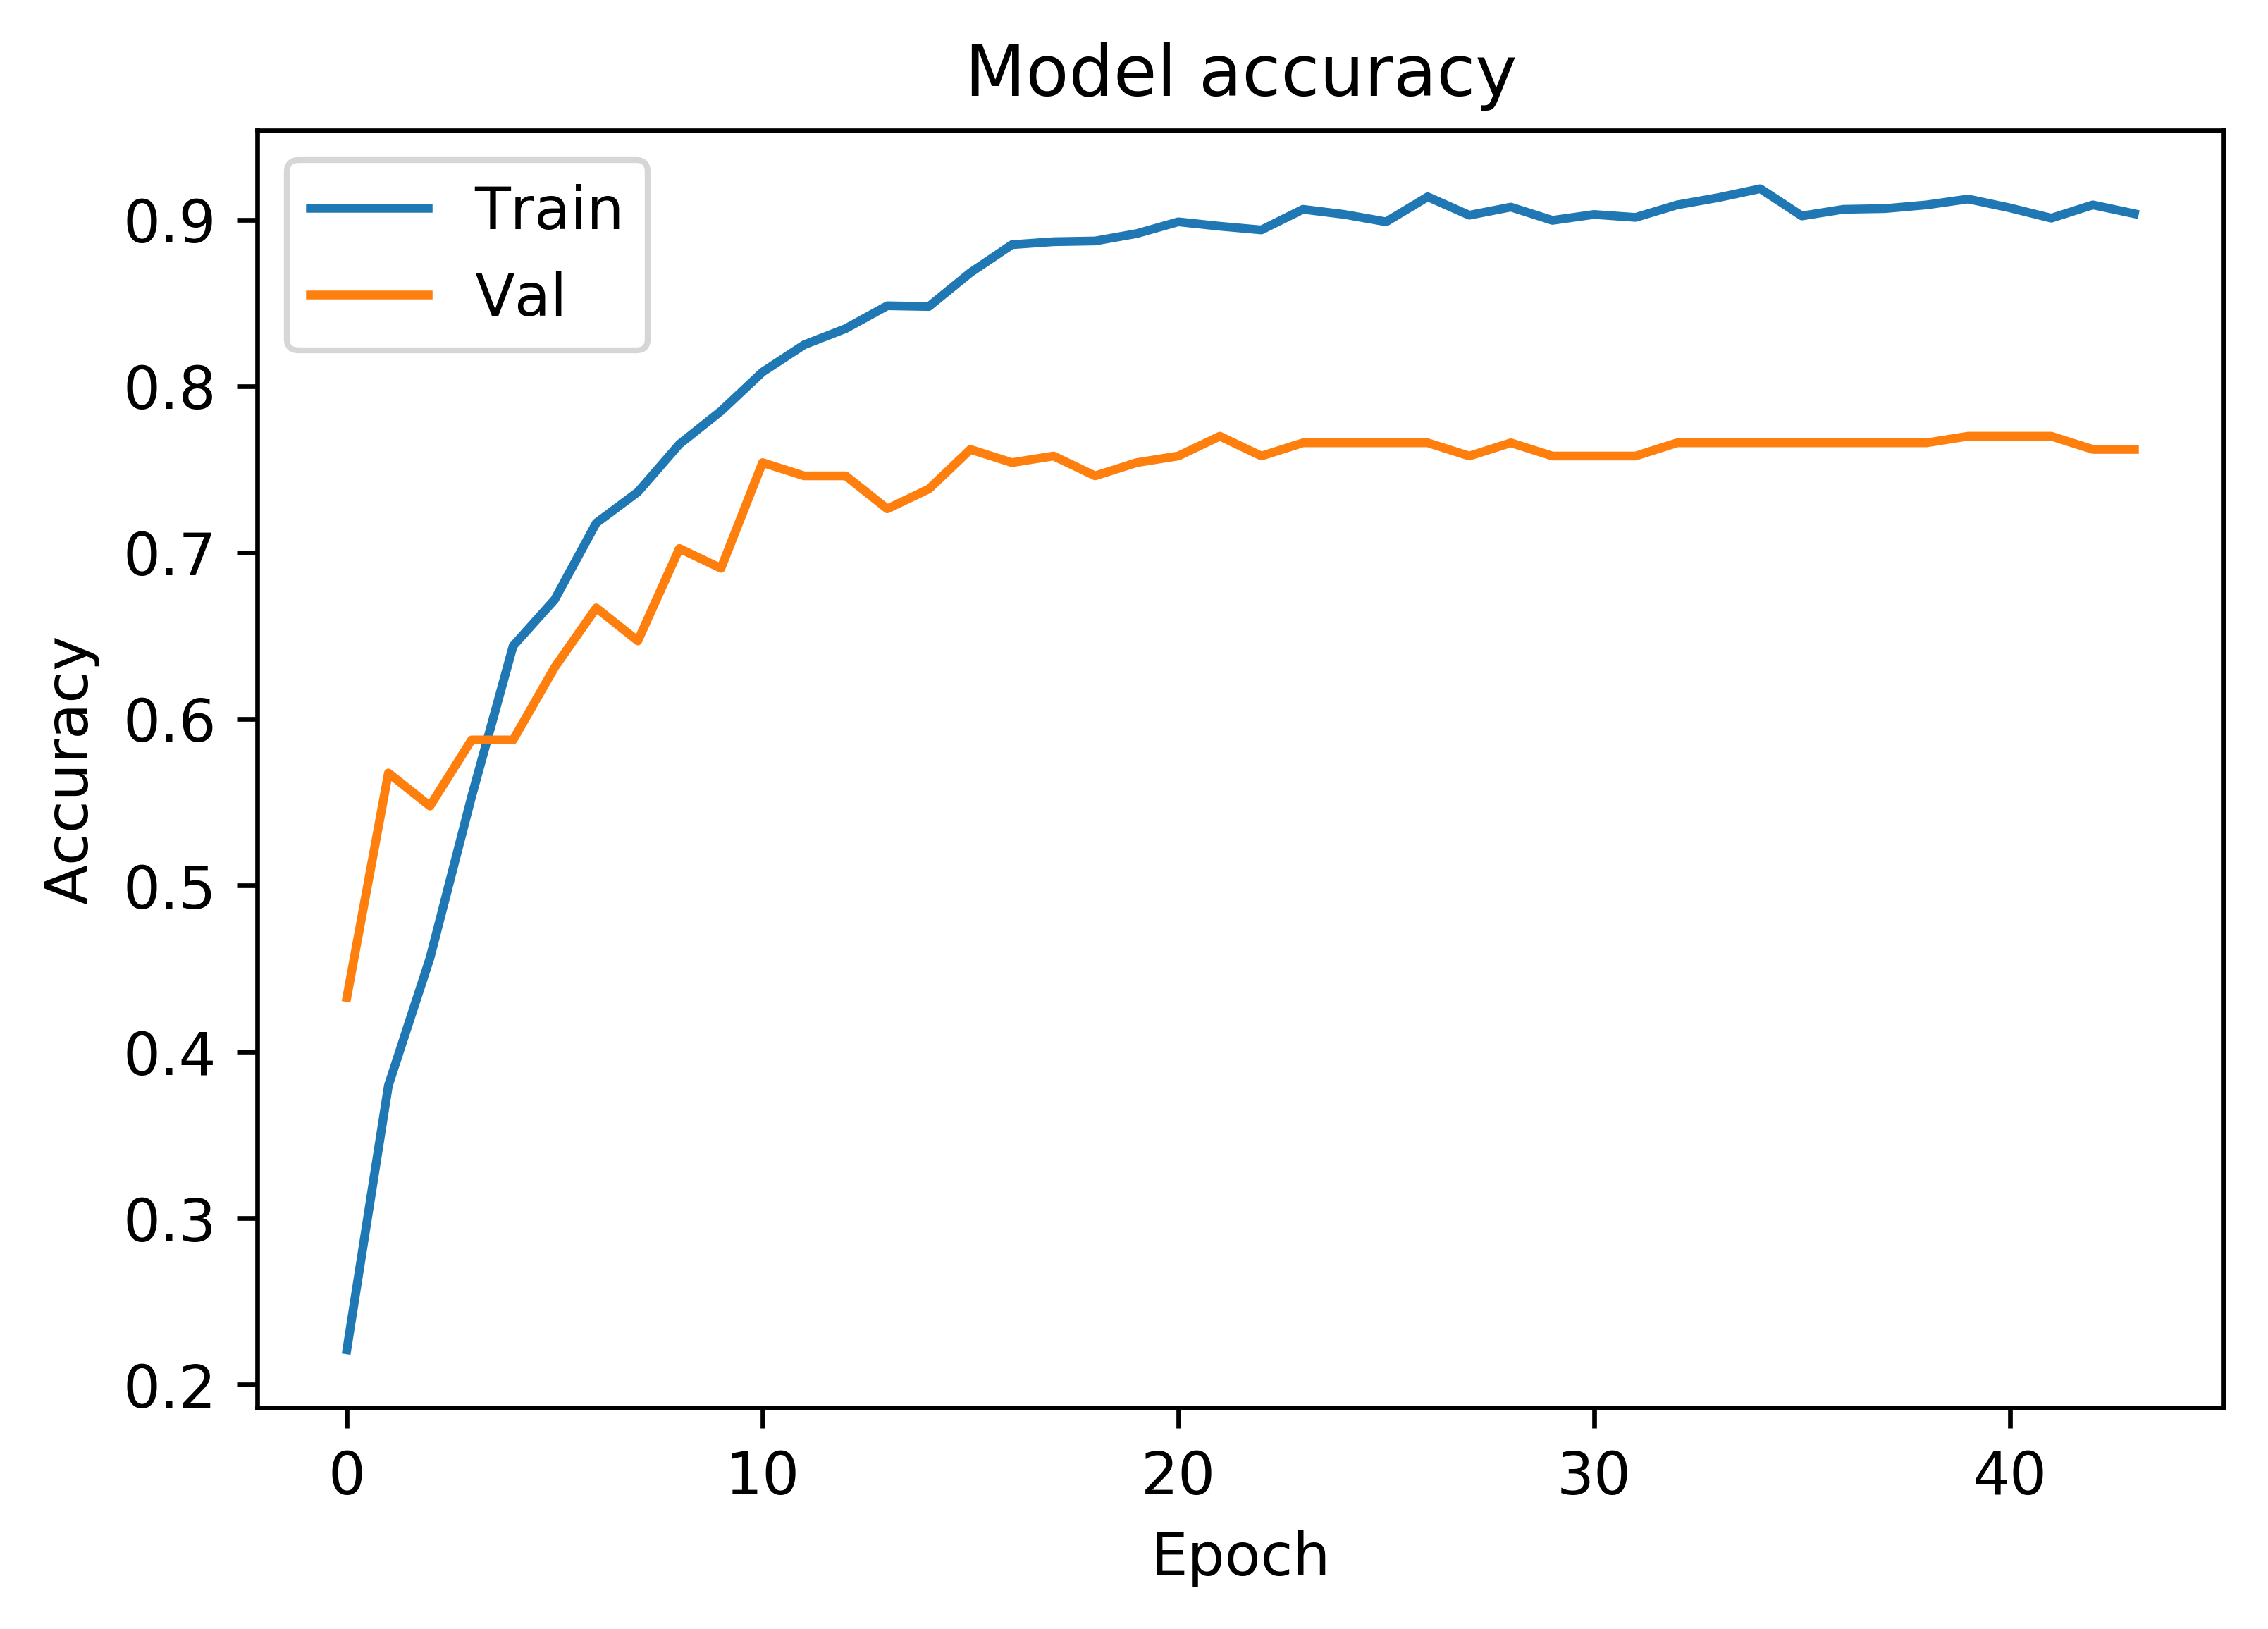

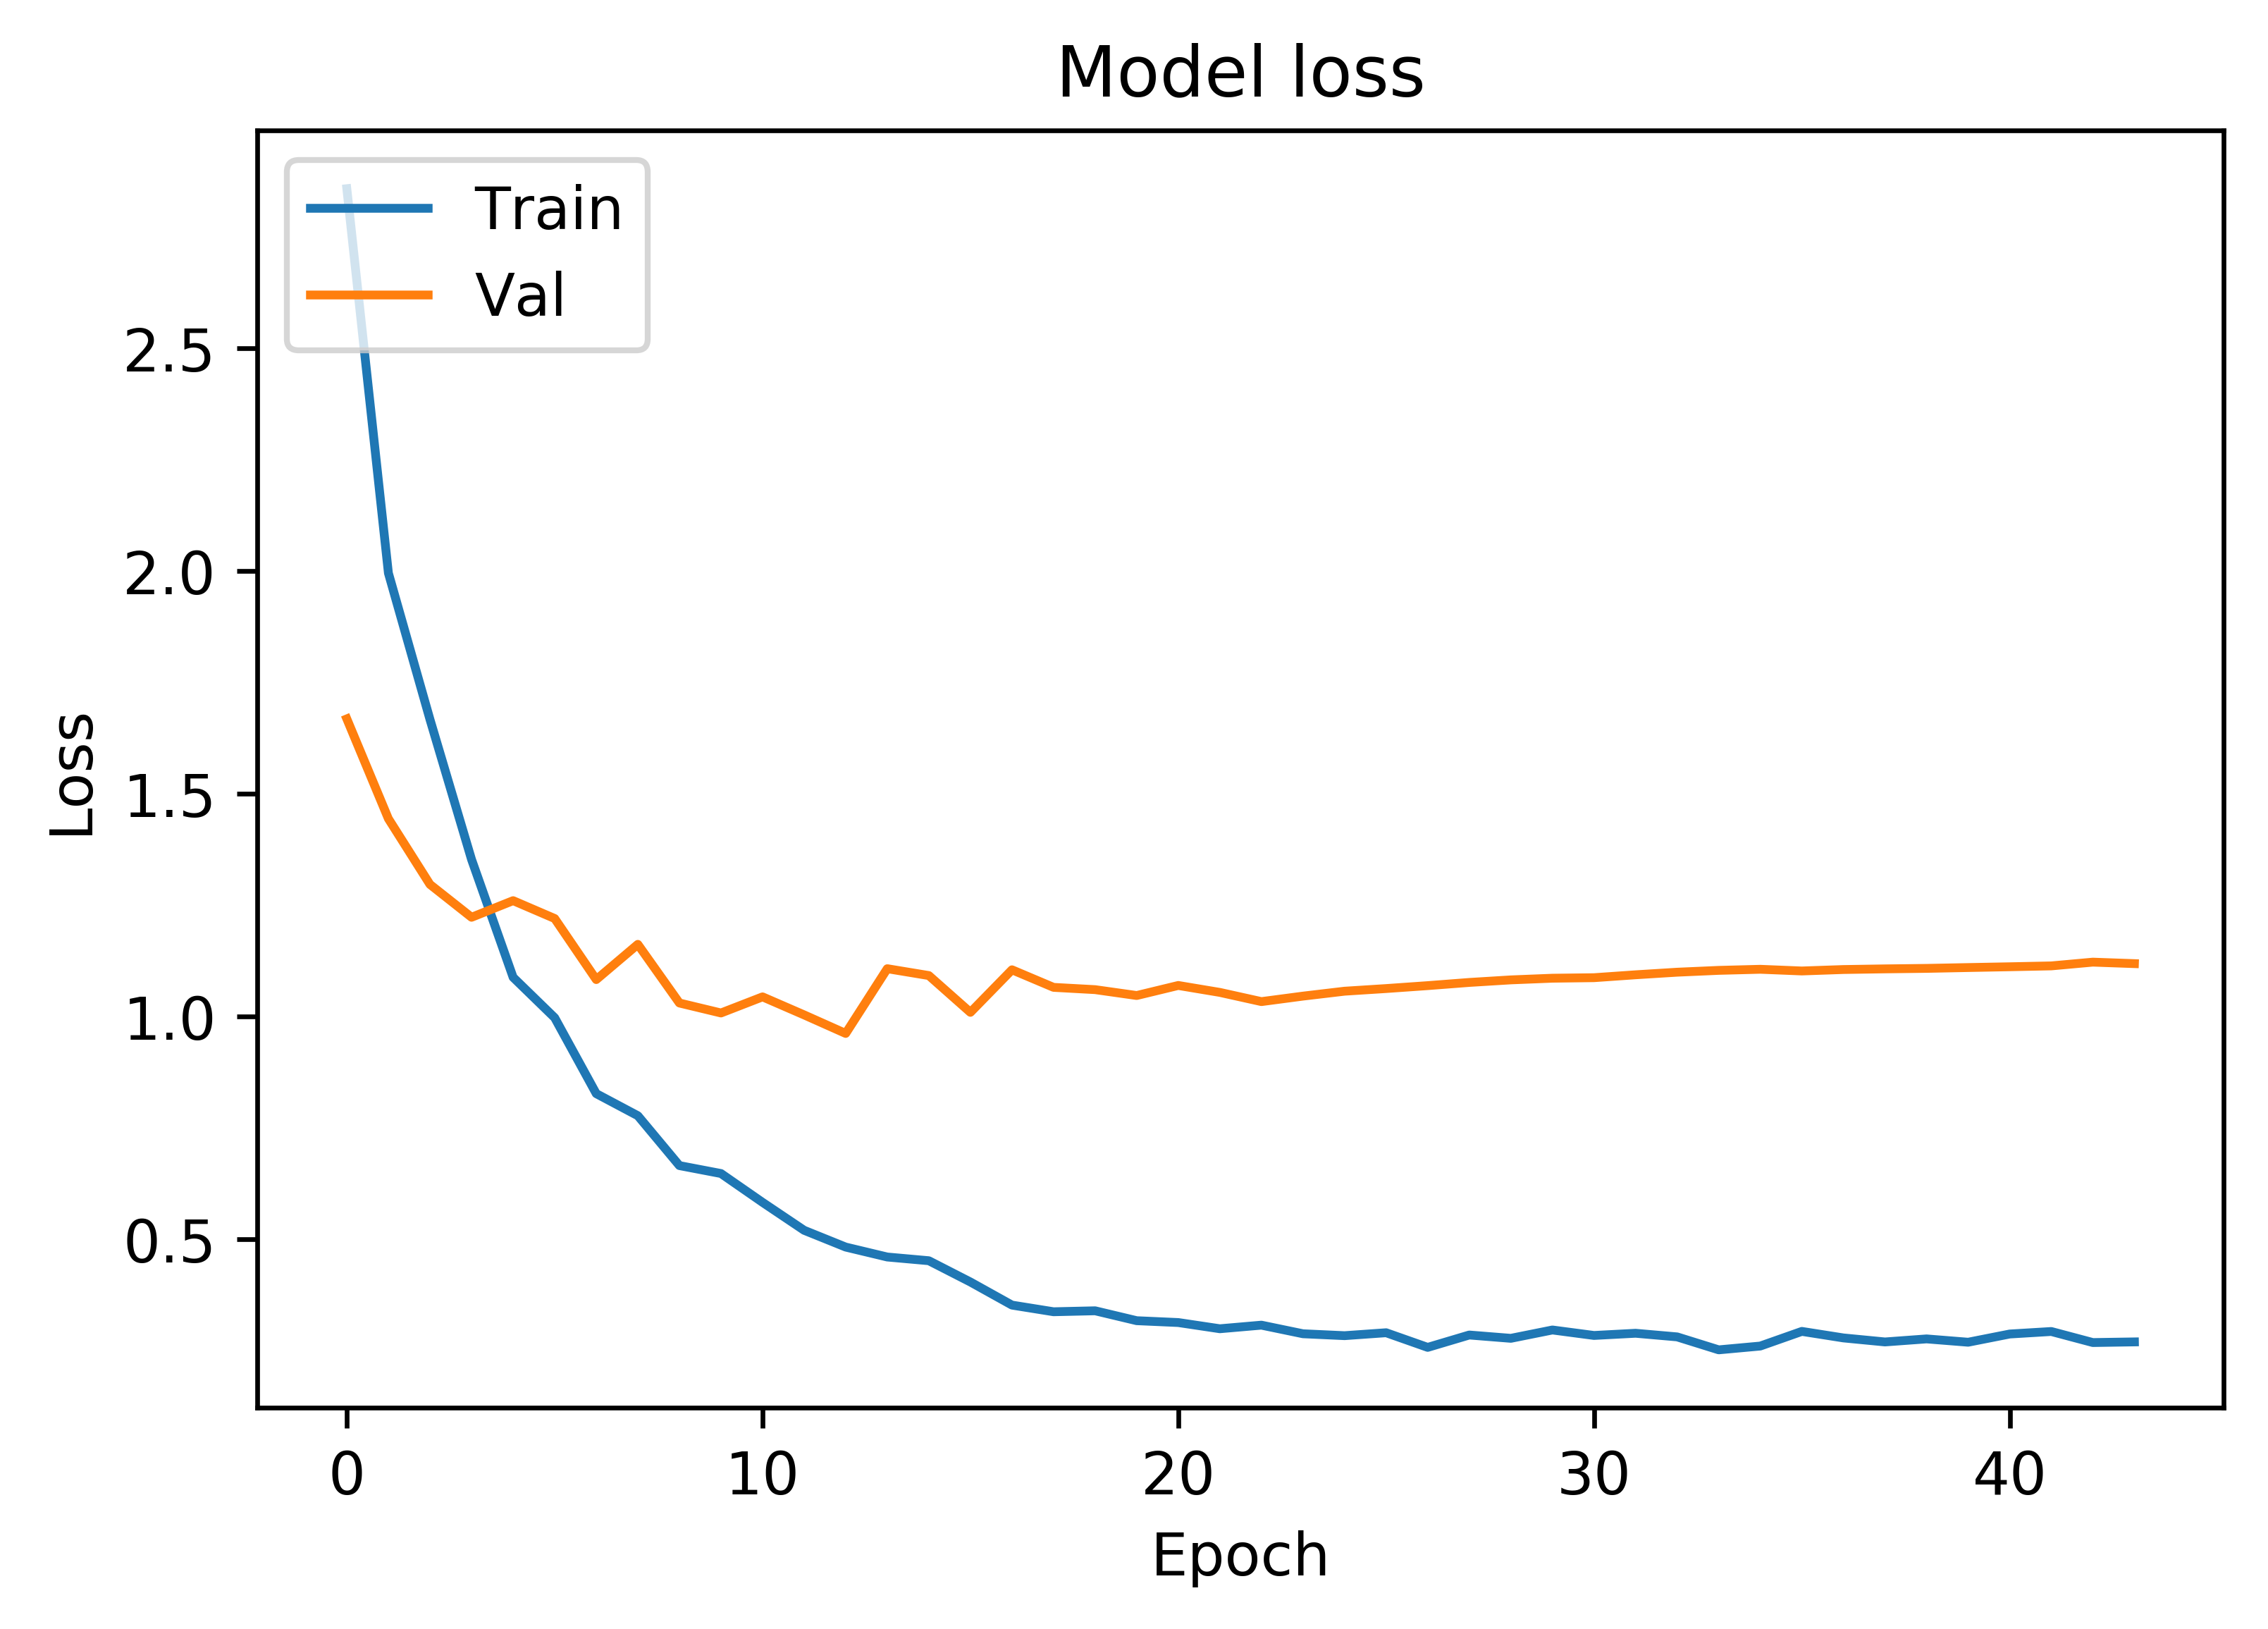

Results from K-fold: 2
acc: 78.01%
632/632 [==============================] - 0s 168us/step
[1.02583583698997, 0.7800632903847513]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         46    5        1     5          8         2    11          1
gel          6   58        4     0          2         3     6          0
network      2    2       60     4          2         4     3          2
plot         6    1        3    57          4         1     7          0
histology    1    0        2     1         71         0     1          3
sequence     0    5        2     0          2        69     0          1
line         5    1        3     3          3         2    62          0
molecular    0    0        2     0          2         5     0         70
              precision    recall  f1-score   support

         bar       0.70      0.58      0.63        79
         gel       0.81      0.73      0.77        79
     network       0.78      0.76      0.77      

Epoch 17/150
2260/2260 [==============================] - 0s 138us/step - loss: 0.4002 - acc: 0.8708 - val_loss: 0.6806 - val_acc: 0.8056

Epoch 00017: val_acc improved from 0.78175 to 0.80556, saving model to unimodal_weights/best_weight_text_1d_only_k-fold_3.hdf5
Epoch 18/150
2260/2260 [==============================] - 0s 152us/step - loss: 0.3916 - acc: 0.8704 - val_loss: 0.8976 - val_acc: 0.7976

Epoch 00018: val_acc did not improve from 0.80556
Epoch 19/150
2260/2260 [==============================] - 0s 138us/step - loss: 0.3693 - acc: 0.8810 - val_loss: 0.9666 - val_acc: 0.7817

Epoch 00019: val_acc did not improve from 0.80556
Epoch 20/150
2260/2260 [==============================] - 0s 136us/step - loss: 0.3494 - acc: 0.8867 - val_loss: 0.8931 - val_acc: 0.7937

Epoch 00020: val_acc did not improve from 0.80556
Epoch 21/150
2260/2260 [==============================] - 0s 137us/step - loss: 0.3329 - acc: 0.8960 - val_loss: 0.9098 - val_acc: 0.8095

Epoch 00021: val_acc improve

2260/2260 [==============================] - 0s 138us/step - loss: 0.2566 - acc: 0.9186 - val_loss: 0.8706 - val_acc: 0.8175

Epoch 00056: val_acc did not improve from 0.82540
Epoch 57/150
2260/2260 [==============================] - 0s 135us/step - loss: 0.2546 - acc: 0.9195 - val_loss: 0.8702 - val_acc: 0.8175

Epoch 00057: val_acc did not improve from 0.82540
Epoch 58/150
2260/2260 [==============================] - 0s 137us/step - loss: 0.2520 - acc: 0.9168 - val_loss: 0.8727 - val_acc: 0.8214

Epoch 00058: val_acc did not improve from 0.82540


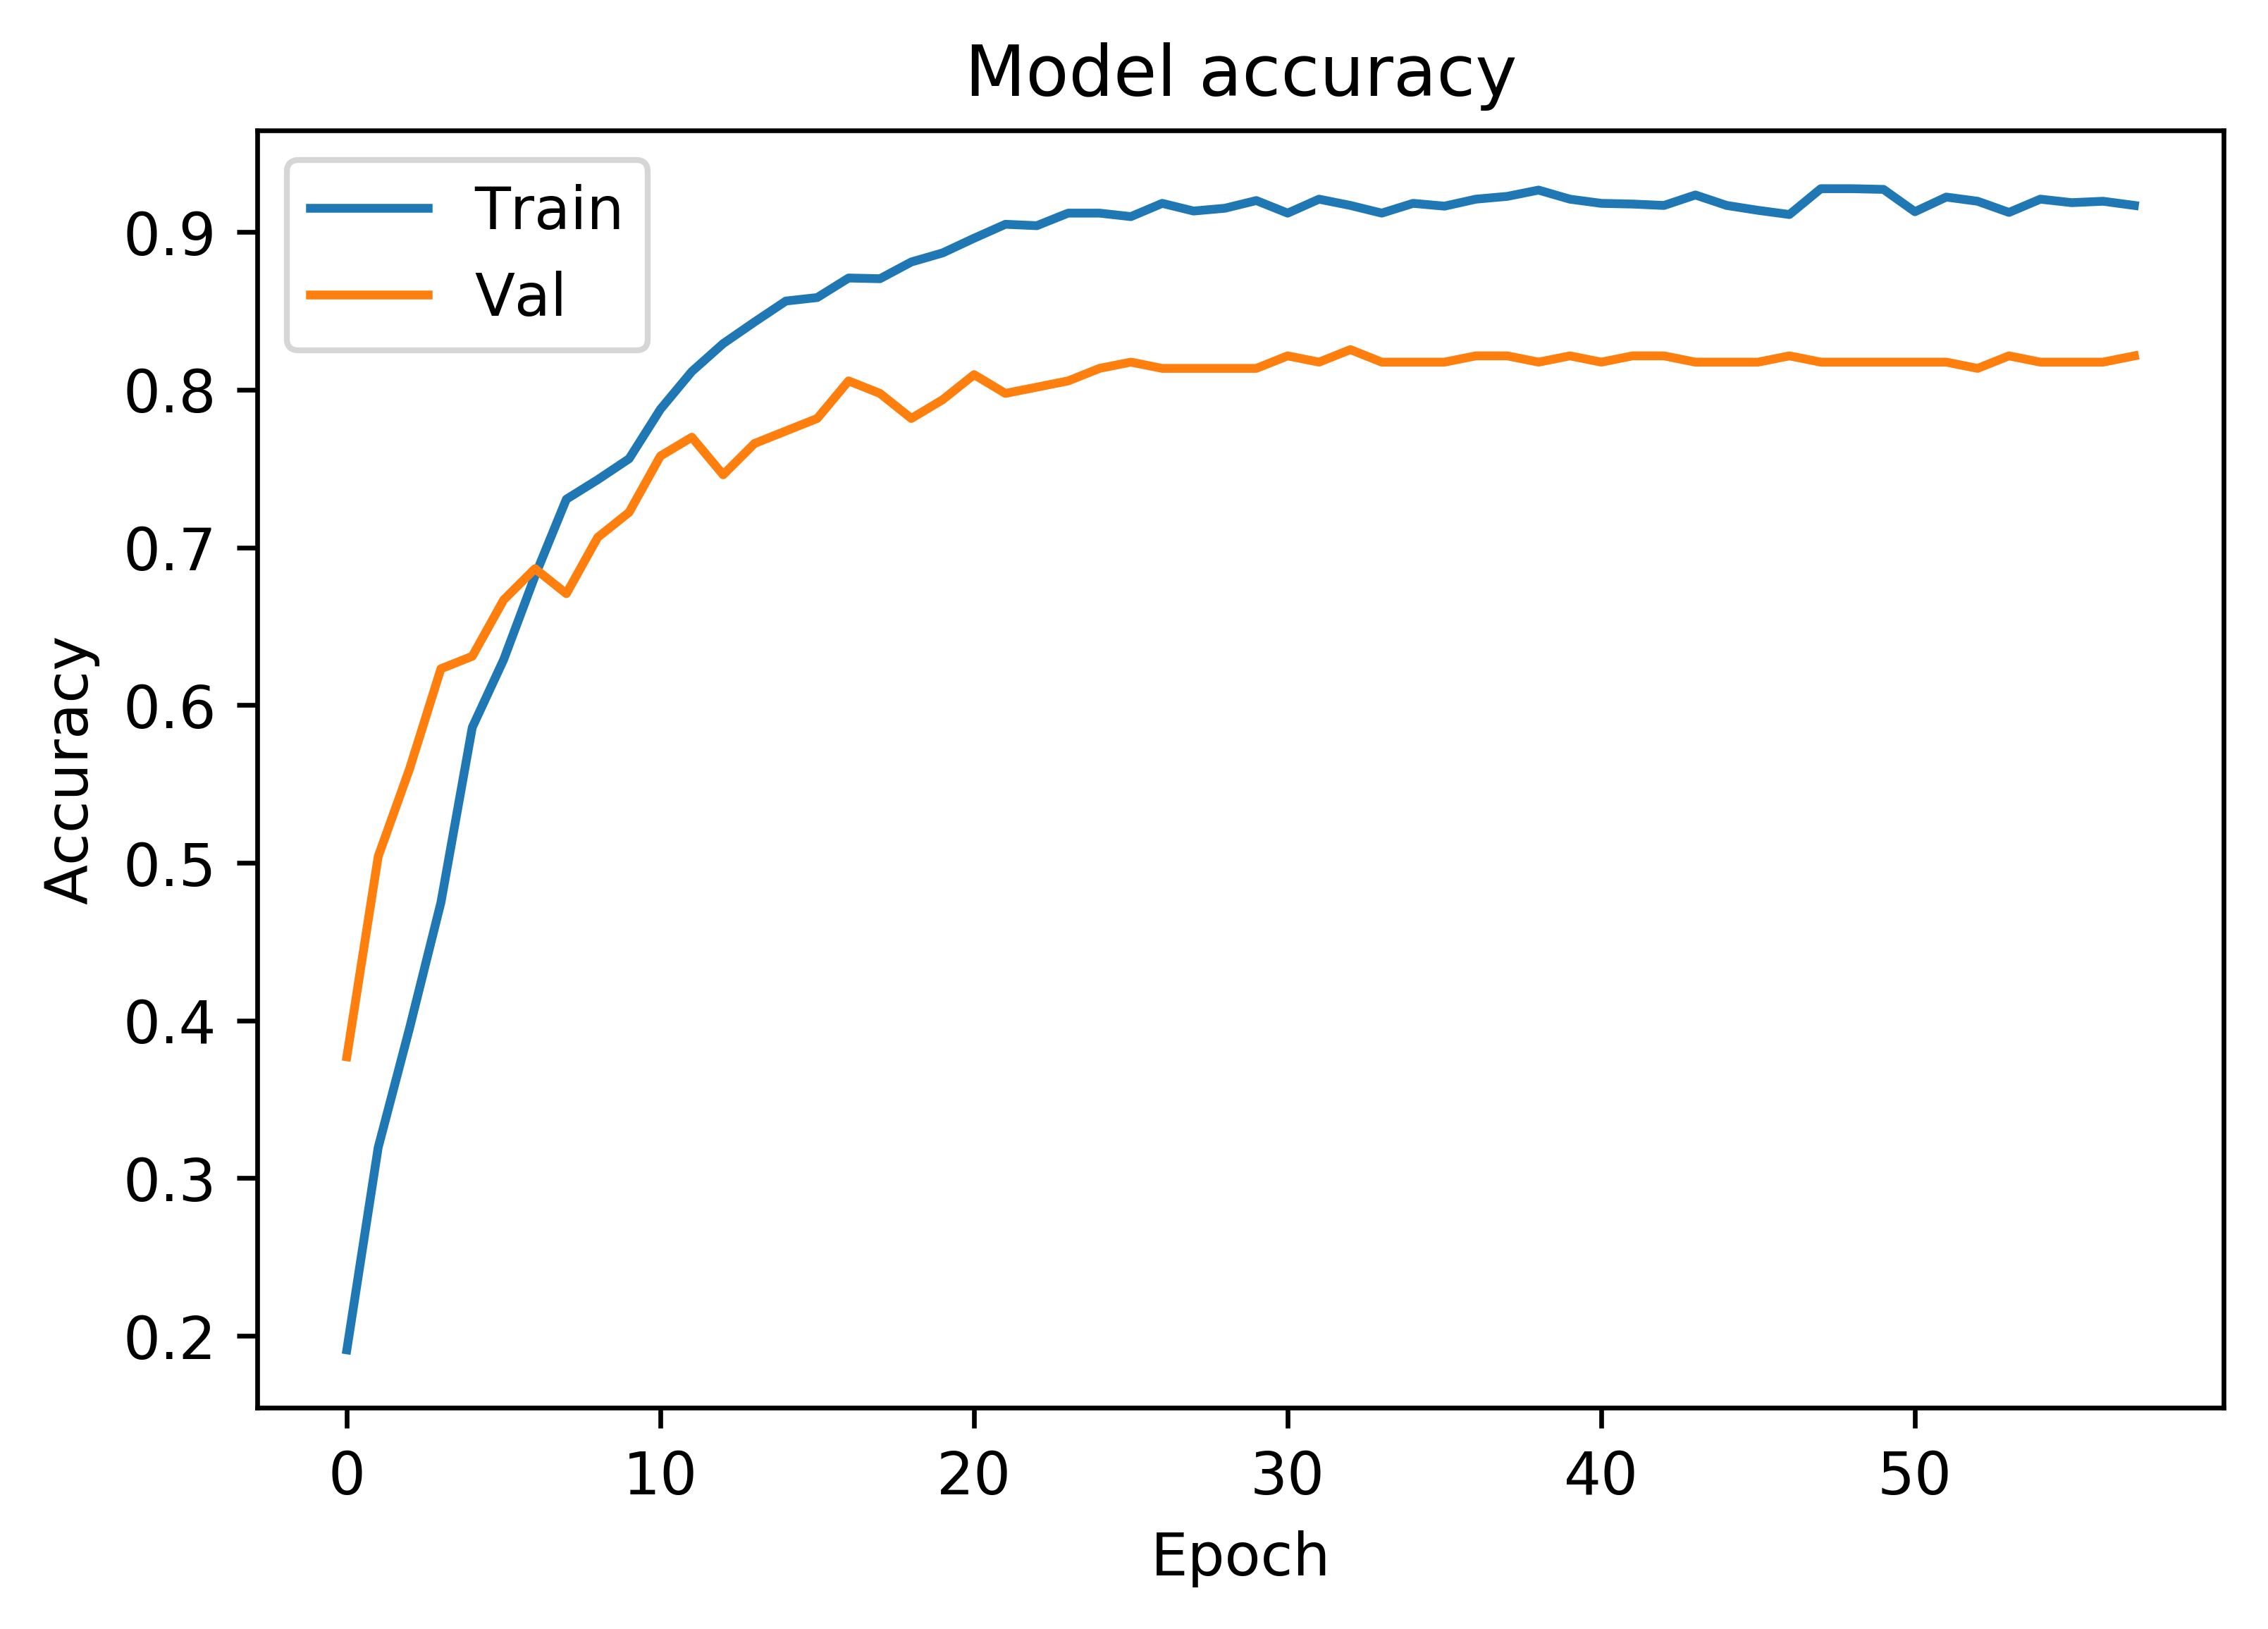

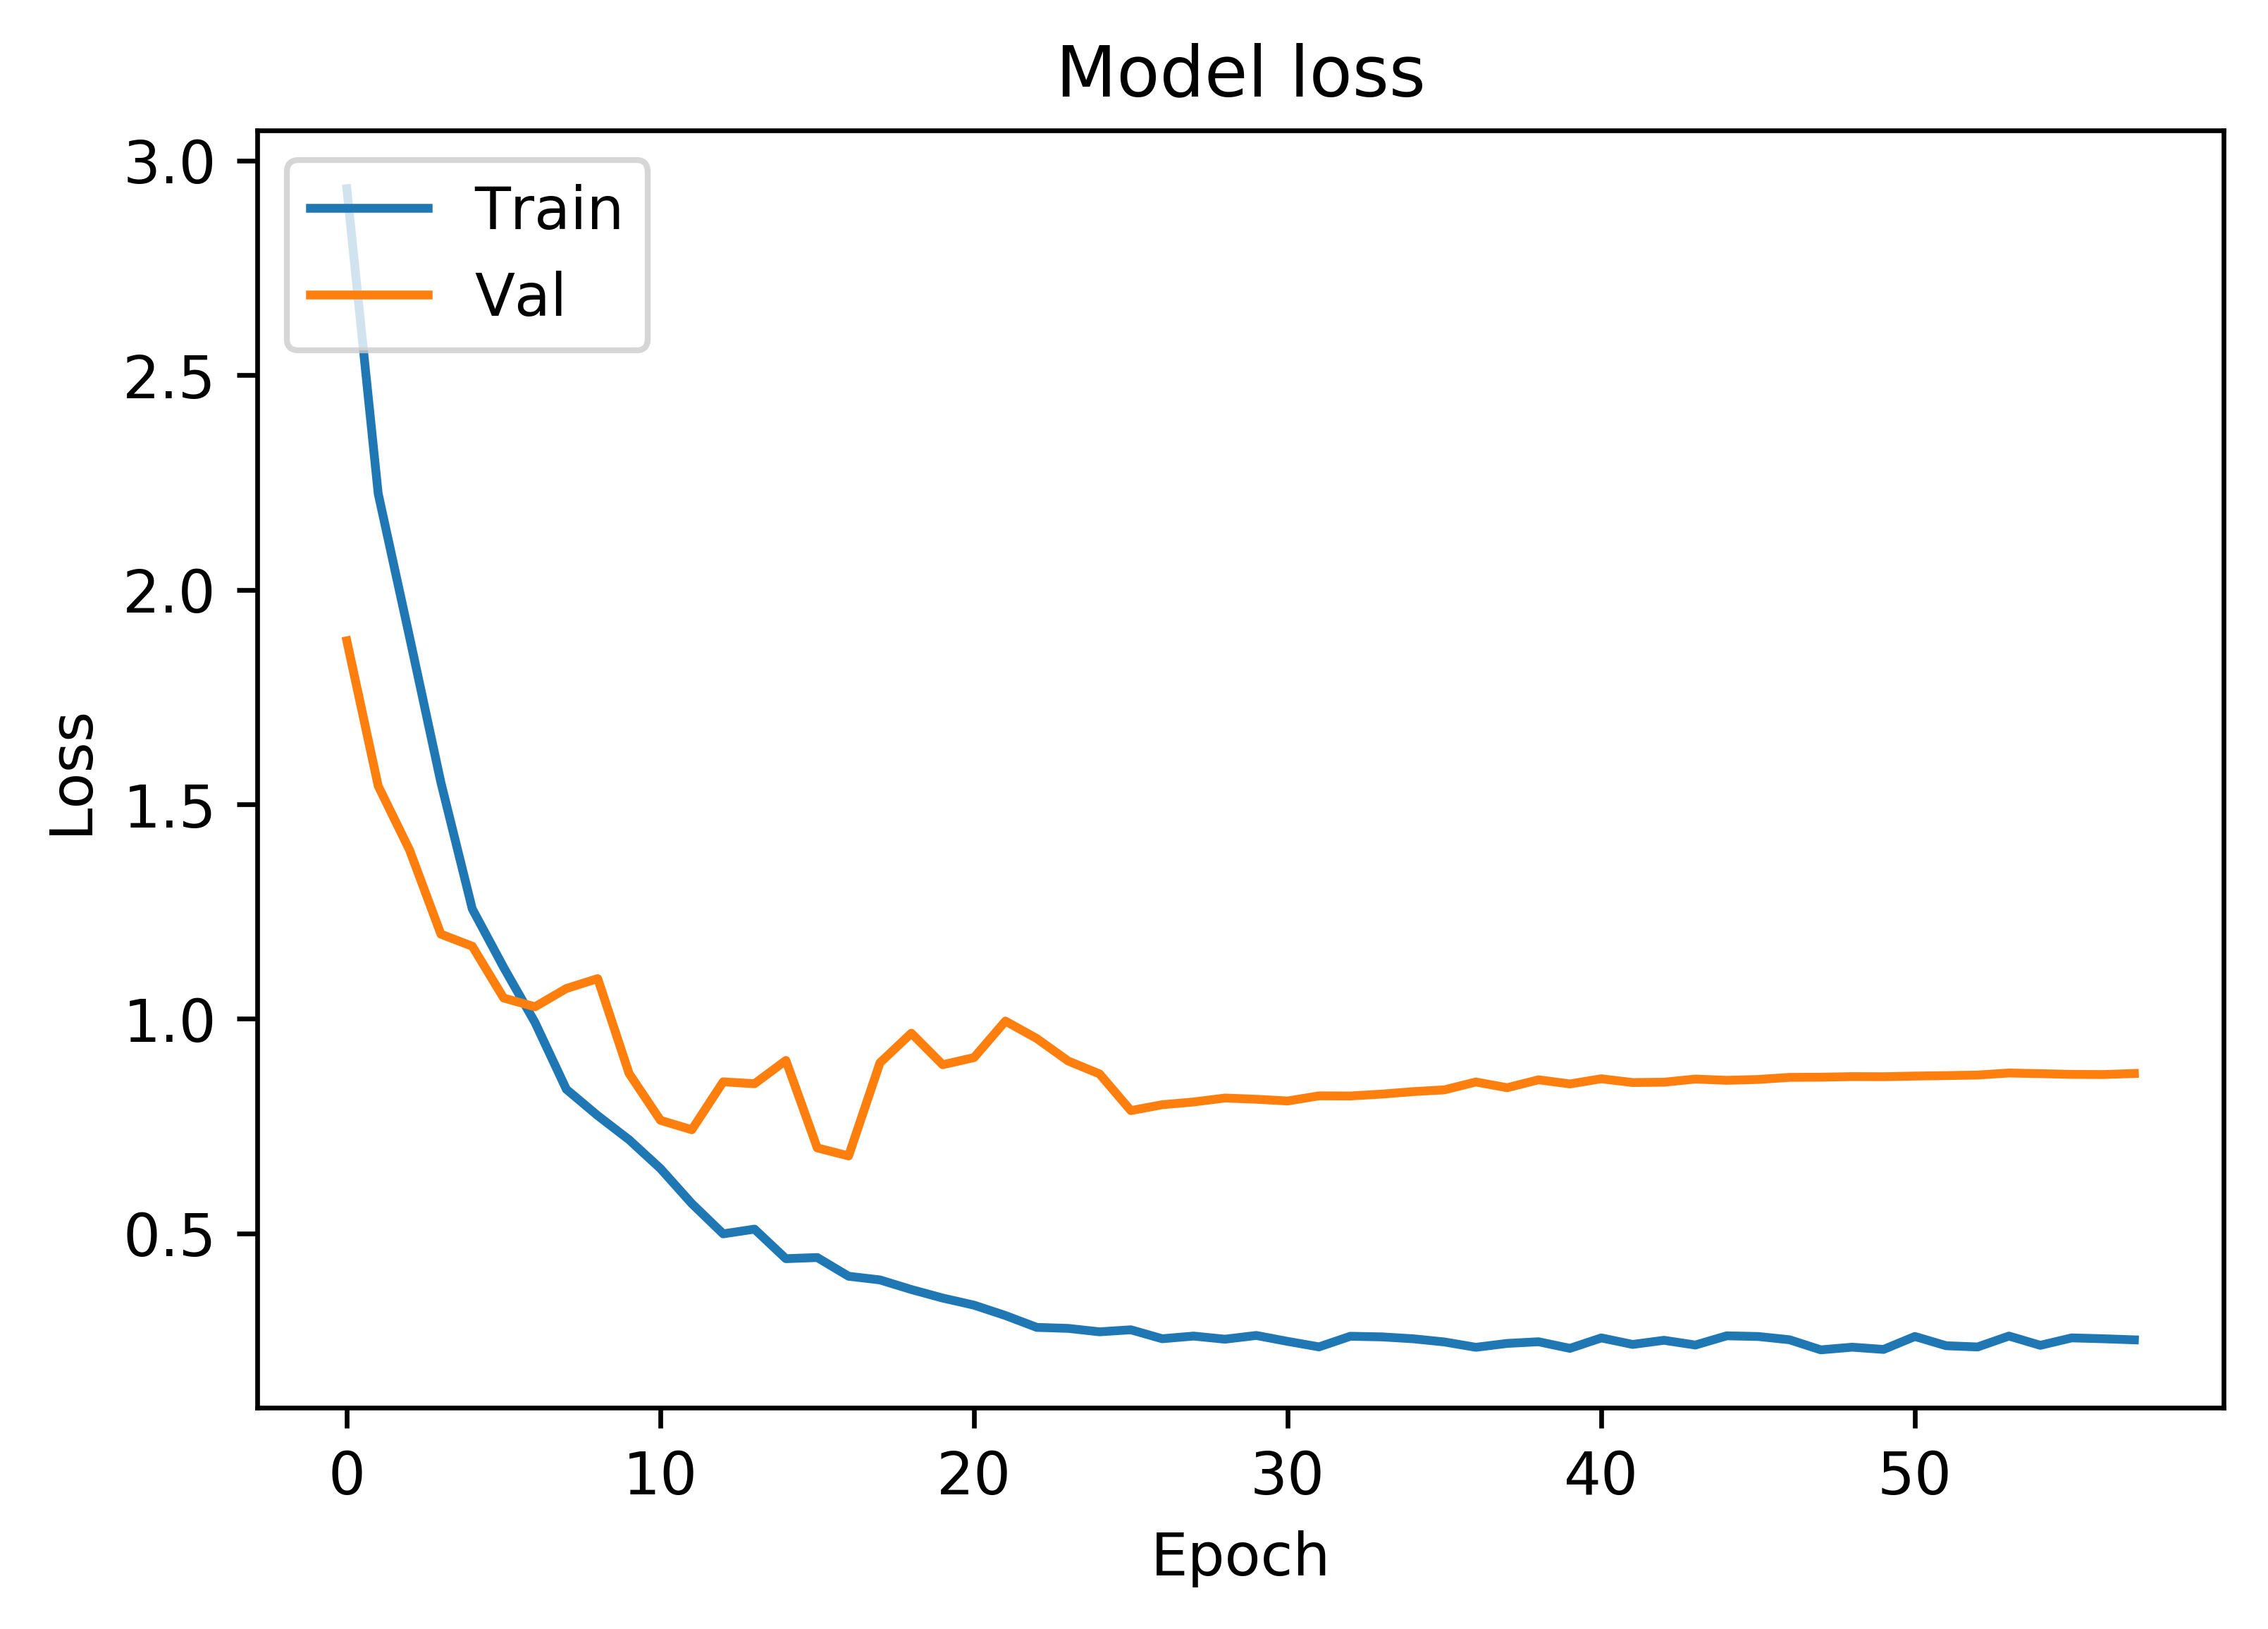

Results from K-fold: 3
acc: 80.85%
632/632 [==============================] - 0s 170us/step
[0.9241767663367187, 0.8085443045519576]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         55    3        2     3          7         1     7          1
gel          2   63        0     0          9         1     4          0
network      1    0       66     2          2         1     1          6
plot         5    0        3    54          0         0    13          4
histology    2    0        2     0         72         1     0          2
sequence     0    4        1     3          0        70     0          1
line         4    2        3     5          4         1    59          1
molecular    1    1        2     0          3         0     0         72
              precision    recall  f1-score   support

         bar       0.79      0.70      0.74        79
         gel       0.86      0.80      0.83        79
     network       0.84      0.84      0.84    


Epoch 00012: val_acc improved from 0.71429 to 0.73810, saving model to unimodal_weights/best_weight_text_1d_only_k-fold_4.hdf5
Epoch 13/150
2268/2268 [==============================] - 0s 150us/step - loss: 0.4392 - acc: 0.8501 - val_loss: 0.8995 - val_acc: 0.7460

Epoch 00013: val_acc improved from 0.73810 to 0.74603, saving model to unimodal_weights/best_weight_text_1d_only_k-fold_4.hdf5
Epoch 14/150
2268/2268 [==============================] - 0s 148us/step - loss: 0.4640 - acc: 0.8457 - val_loss: 0.9243 - val_acc: 0.7421

Epoch 00014: val_acc did not improve from 0.74603
Epoch 15/150
2268/2268 [==============================] - 0s 138us/step - loss: 0.4174 - acc: 0.8593 - val_loss: 1.0999 - val_acc: 0.7381

Epoch 00015: val_acc did not improve from 0.74603
Epoch 16/150
2268/2268 [==============================] - 0s 135us/step - loss: 0.3871 - acc: 0.8761 - val_loss: 0.9202 - val_acc: 0.7579

Epoch 00016: val_acc improved from 0.74603 to 0.75794, saving model to unimodal_weights/b

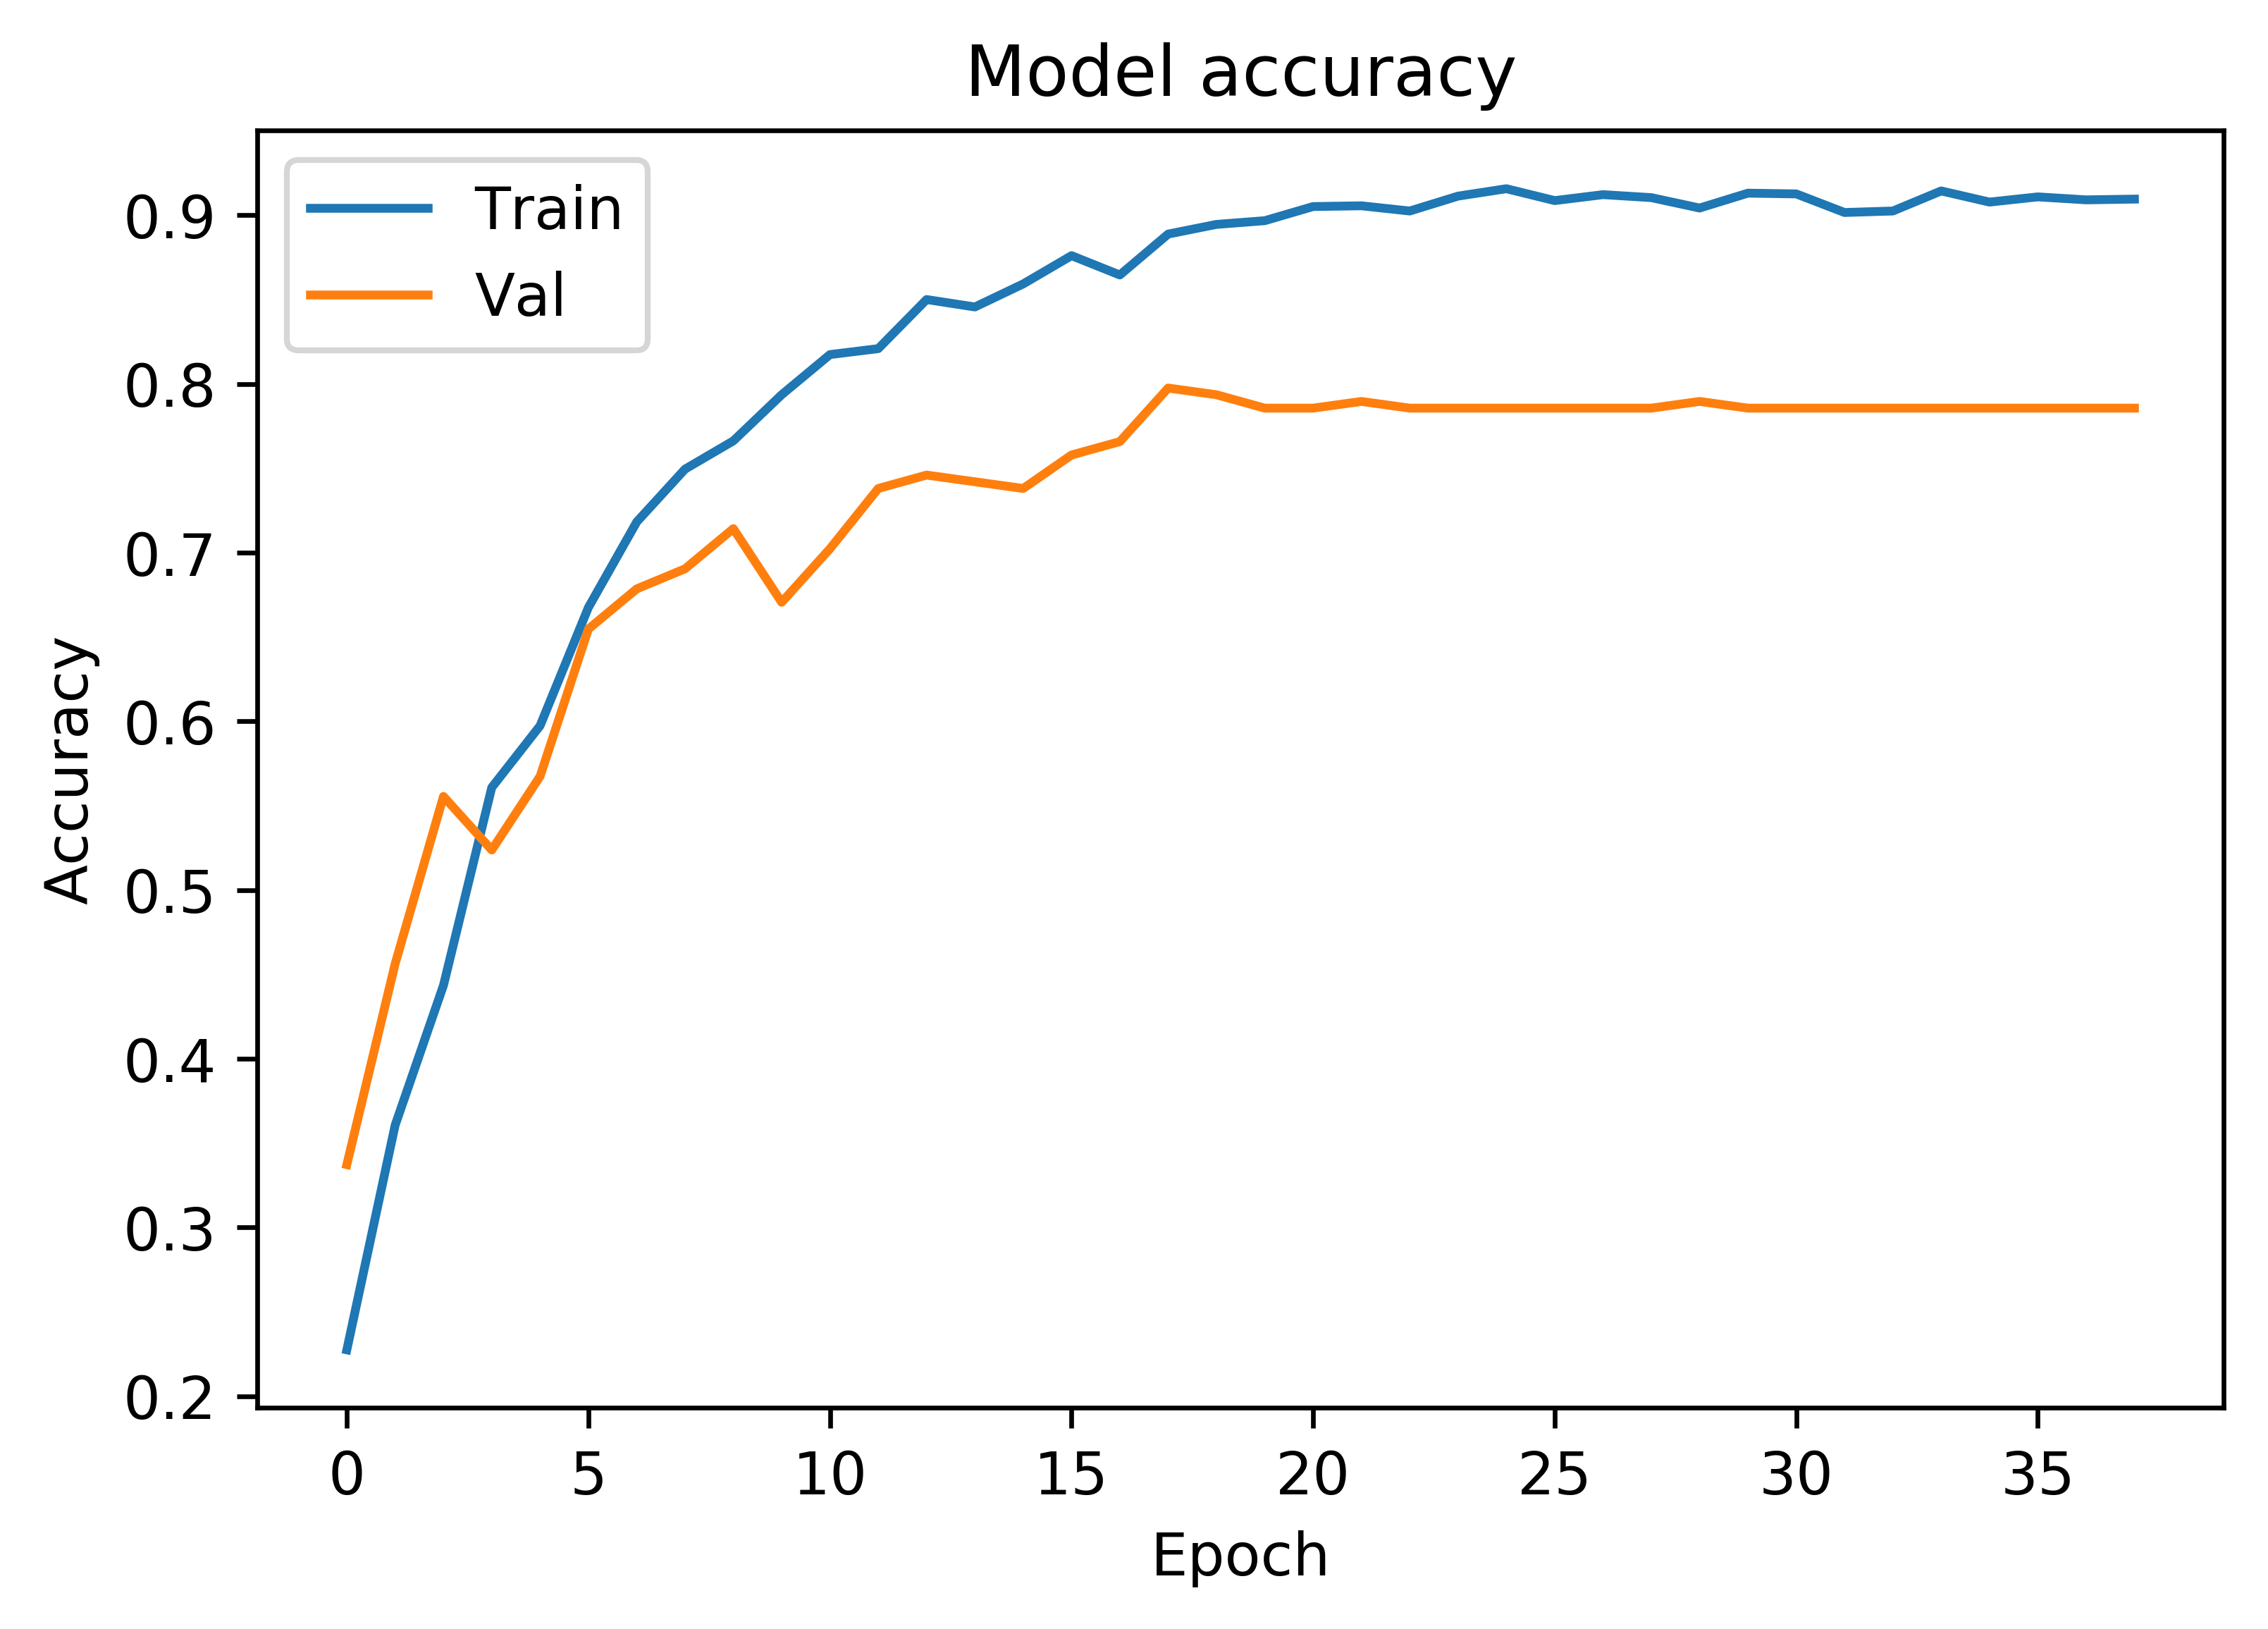

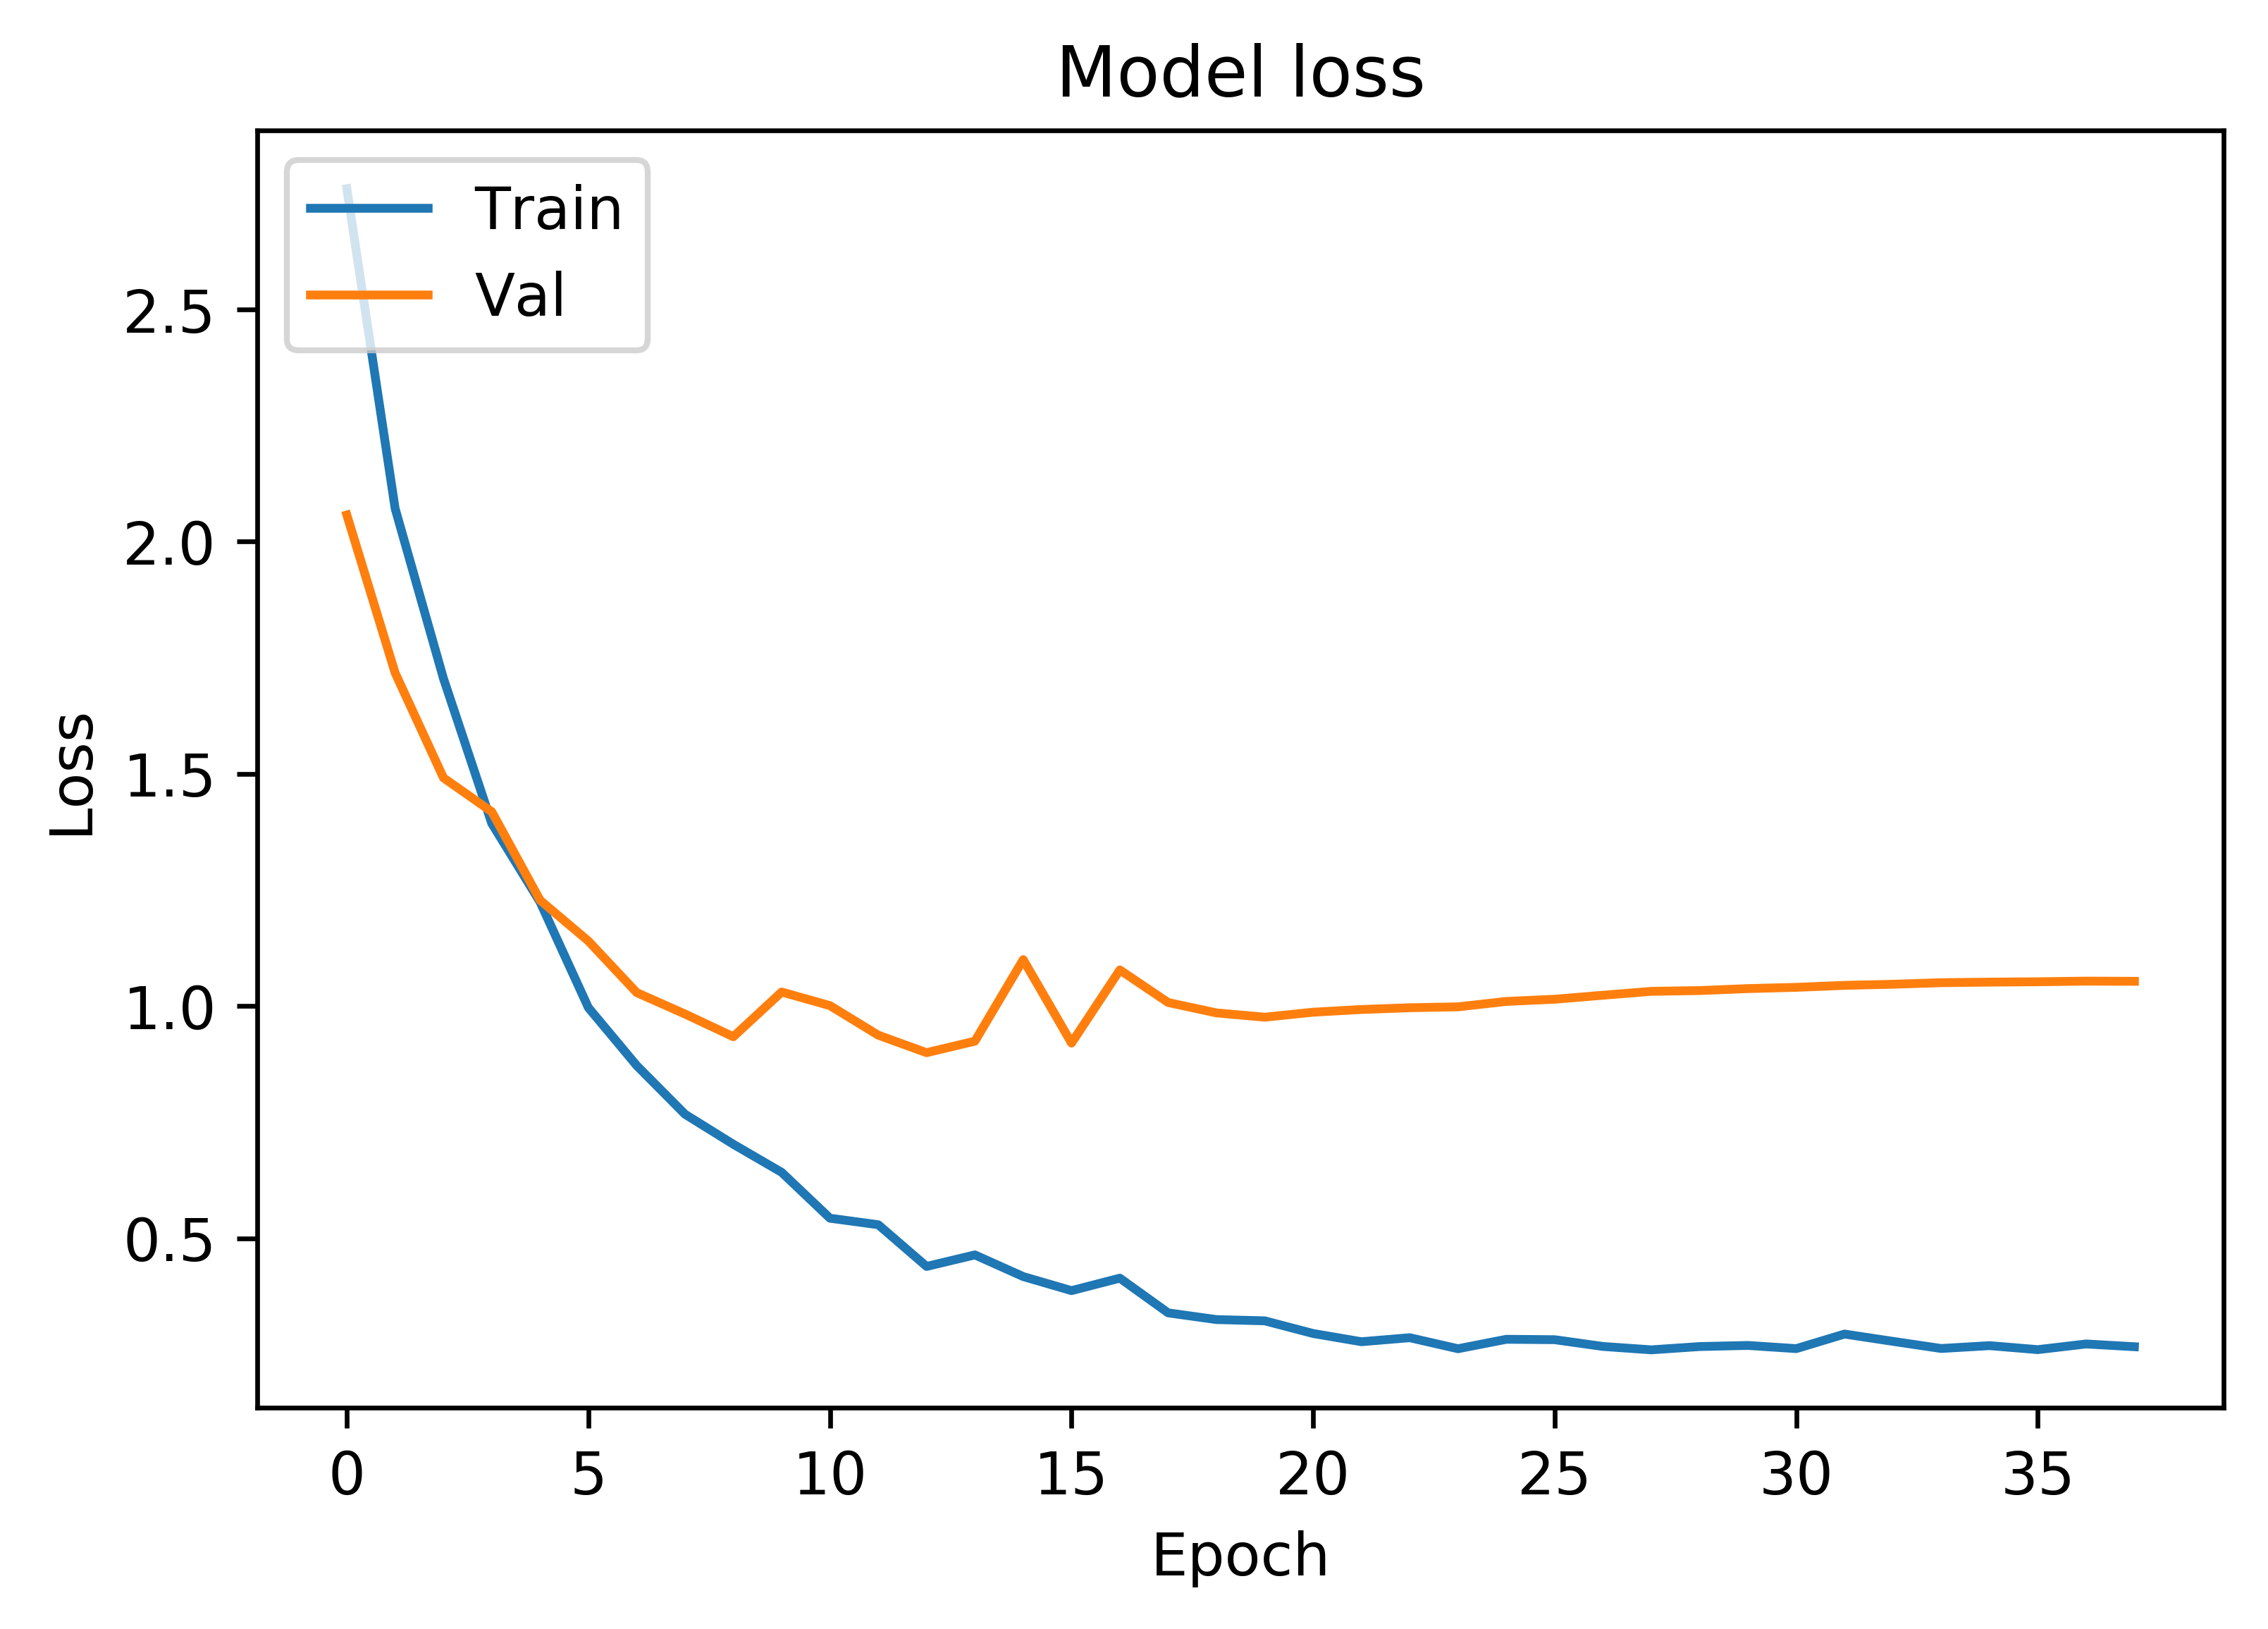

Results from K-fold: 4
acc: 80.93%
624/624 [==============================] - 0s 165us/step
[0.8431263896517265, 0.8092948717948718]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         48    8        3     5          2         1    10          1
gel          2   55        2     0         13         2     4          0
network      0    2       62     1          1         3     5          4
plot         6    3        3    57          2         0     7          0
histology    1    0        0     2         74         0     1          0
sequence     2    0        4     0          0        72     0          0
line         1    2        1     4          3         1    64          2
molecular    1    0        2     0          2         0     0         73
              precision    recall  f1-score   support

         bar       0.79      0.62      0.69        78
         gel       0.79      0.71      0.74        78
     network       0.81      0.79      0.80    


Epoch 00015: val_acc did not improve from 0.74603
Epoch 16/150
2268/2268 [==============================] - 0s 134us/step - loss: 0.3790 - acc: 0.8735 - val_loss: 1.0364 - val_acc: 0.7421

Epoch 00016: val_acc did not improve from 0.74603
Epoch 17/150
2268/2268 [==============================] - 0s 137us/step - loss: 0.3728 - acc: 0.8774 - val_loss: 0.9977 - val_acc: 0.7500

Epoch 00017: val_acc improved from 0.74603 to 0.75000, saving model to unimodal_weights/best_weight_text_1d_only_k-fold_5.hdf5
Epoch 18/150
2268/2268 [==============================] - 0s 140us/step - loss: 0.3325 - acc: 0.8911 - val_loss: 0.9948 - val_acc: 0.7460

Epoch 00018: val_acc did not improve from 0.75000
Epoch 19/150
2268/2268 [==============================] - 0s 135us/step - loss: 0.3620 - acc: 0.8770 - val_loss: 1.0007 - val_acc: 0.7659

Epoch 00019: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00019: val_acc improved from 0.75000 to 0.76587, saving model to unimodal_weig

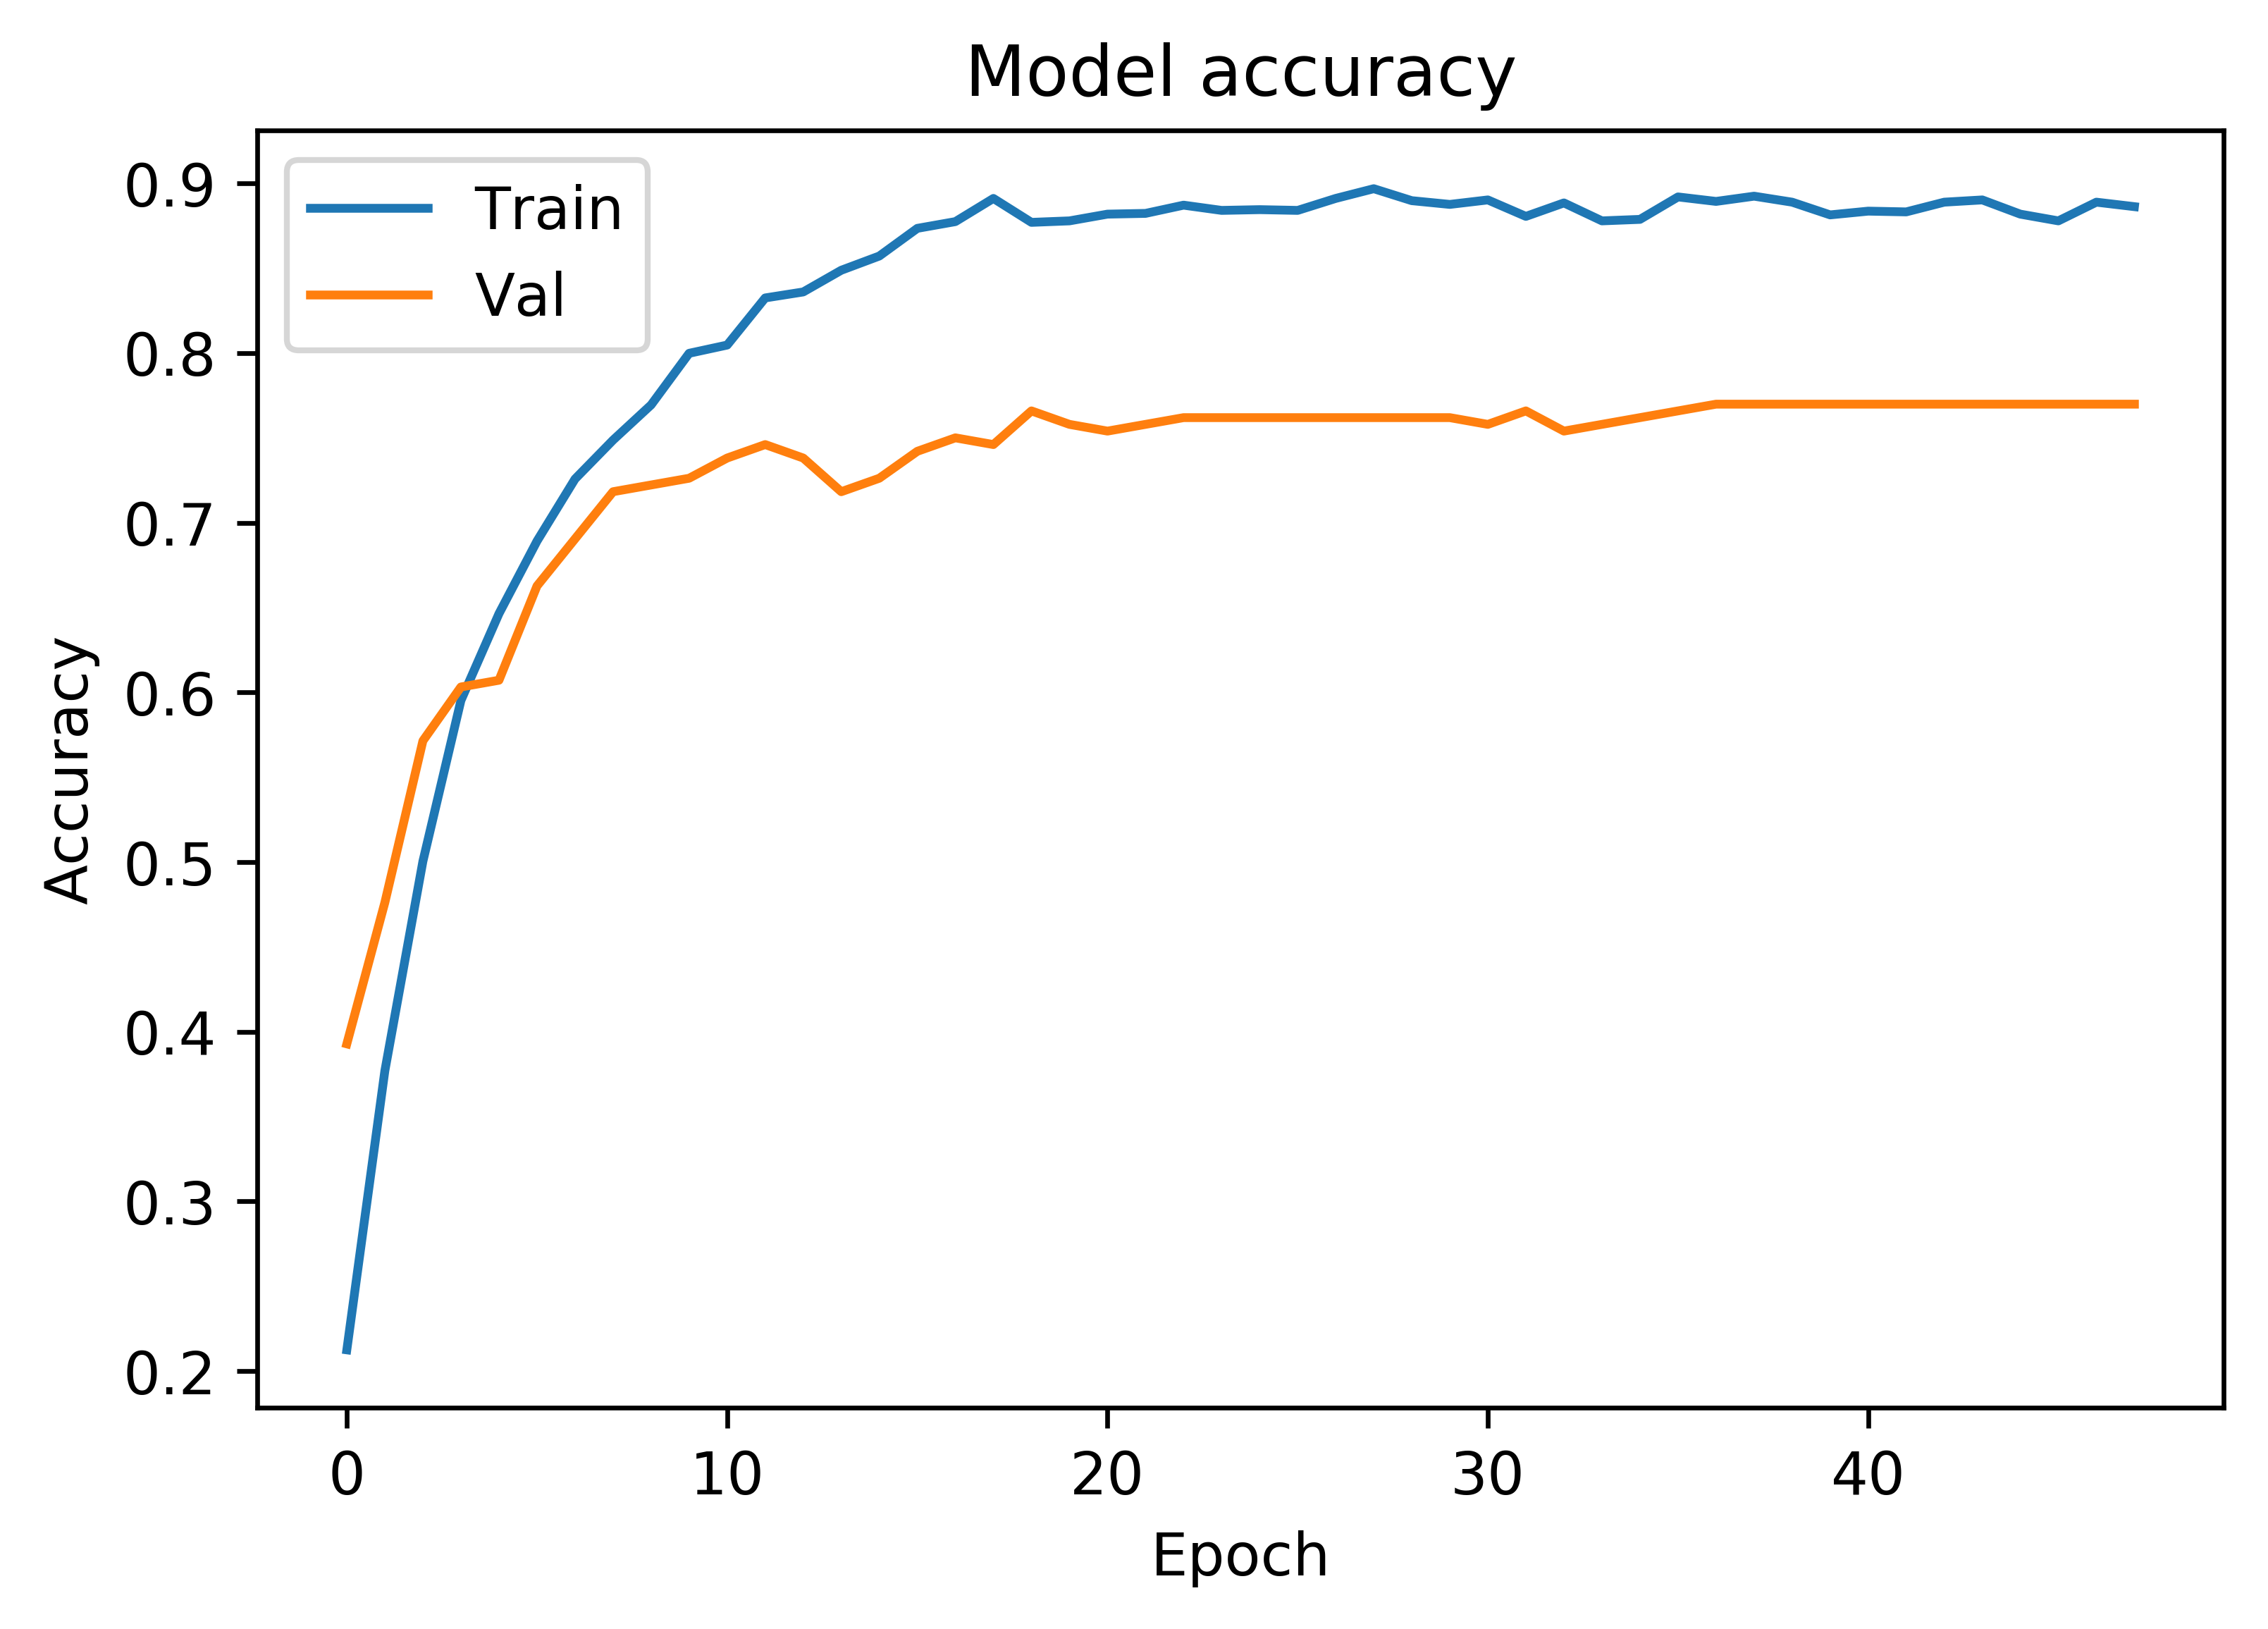

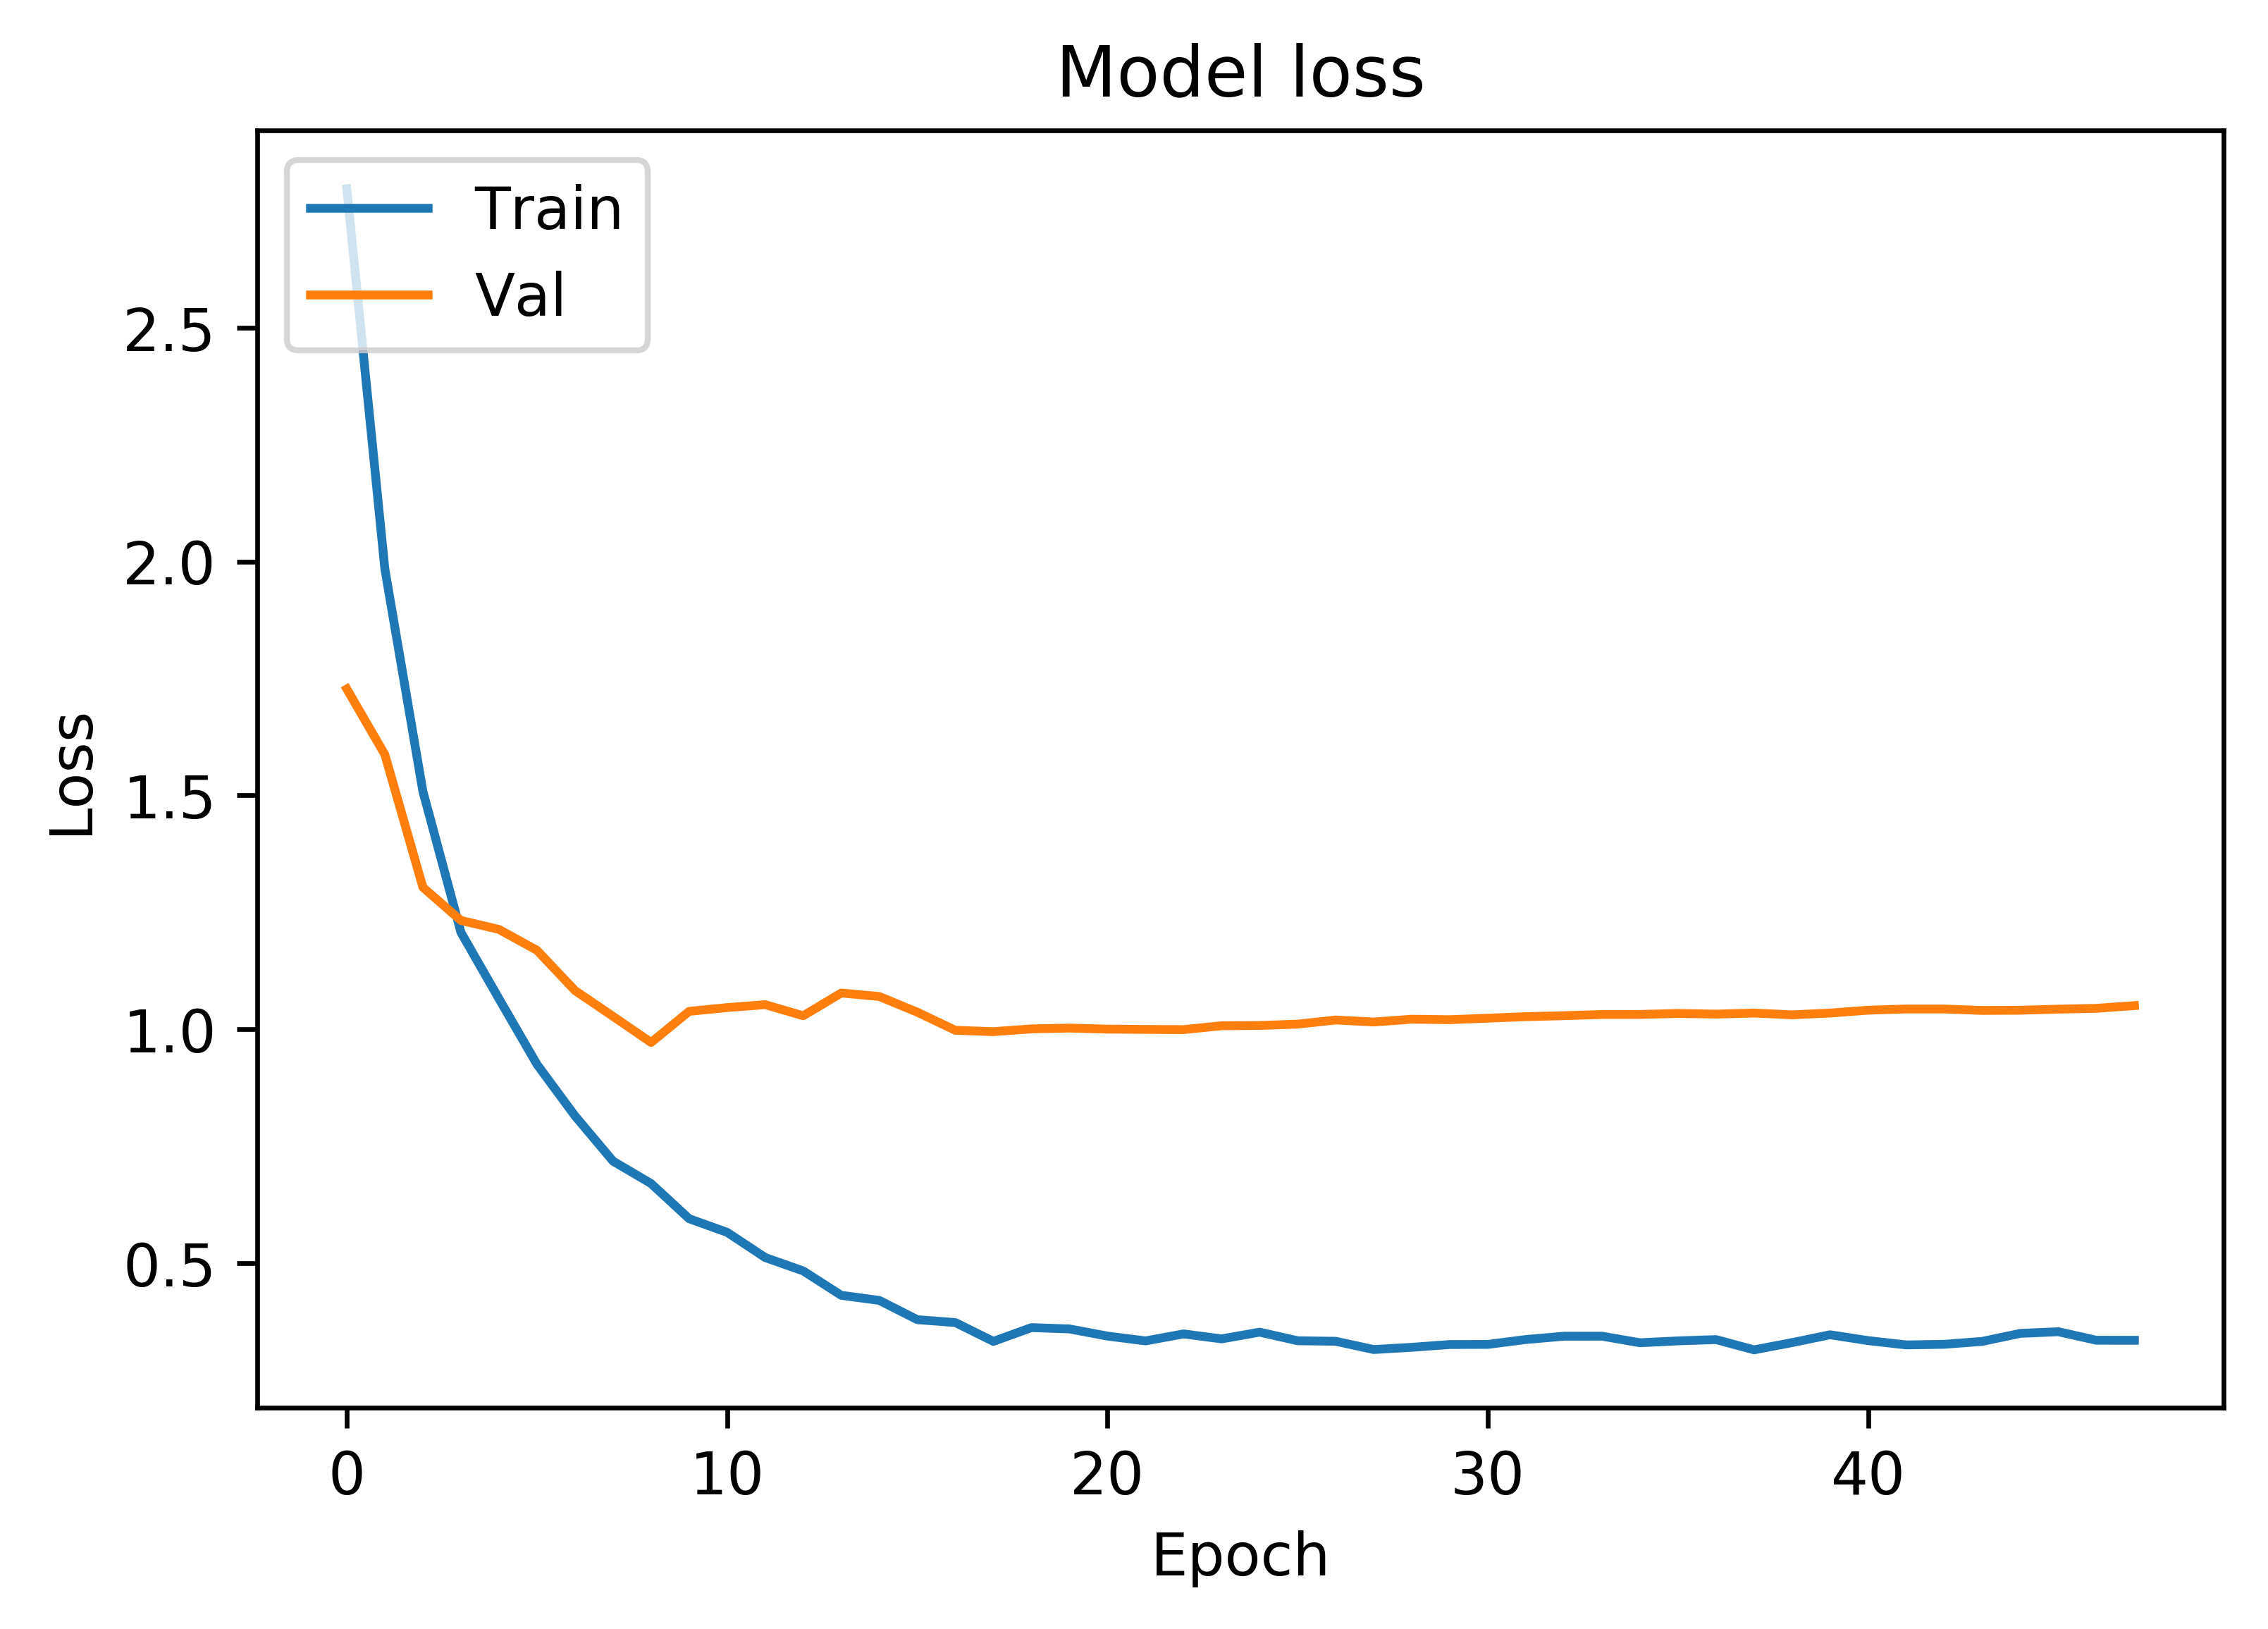

Results from K-fold: 5
acc: 79.17%
624/624 [==============================] - 0s 177us/step
[0.877010988501402, 0.7916666666666666]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         43    3       10     6          7         1     7          1
gel          6   55        2     2         11         0     0          2
network      0    1       70     2          3         0     1          1
plot         5    3        0    59          7         0     4          0
histology    1    0        0     1         75         0     1          0
sequence     3    3        0     2          0        67     0          3
line         1    3        7     7          4         1    54          1
molecular    0    0        3     0          2         2     0         71
              precision    recall  f1-score   support

         bar       0.73      0.55      0.63        78
         gel       0.81      0.71      0.75        78
     network       0.76      0.90      0.82     

In [12]:
#set K folds to 5
cvscores = []
count = 1
confusion_matrix_list = []
report_list = []

for key, val in kfolds.items():
    print(key)
    train = val['train']
    test = val['test']
    
    print('K-: {}'.format(key))
            
    print("Samples from Training")
    print_samples(samples=train, text=X_text, tokenizer=tokenizer)
    print("============================")
    
    print("Samples from Testing")
    print_samples(samples=test, text=X_text, tokenizer=tokenizer)
    print("============================")
    
    random.shuffle(train)
    text_model = Generate_Model(model_type = "text_1d")
    text_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    filepath="unimodal_weights/best_weight_text_1d_only_k-fold_{}.hdf5".format(count)
    checkpoint = MultiGPUCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [reduce_lr, checkpoint, early_stopping]

    history = text_model.fit([X_text[train]], y[train], 
                     epochs=epochs, batch_size=bs, validation_split=0.1, callbacks=callbacks_list)
    plot_model_history(history)
    filepath="unimodal_weights/final_weight_text_1d_only_k-fold_{}.hdf5".format(count)
    text_model.save_weights(filepath)
    scores = text_model.evaluate([X_text[test]], y[test], verbose=0)
    print('Results from K-fold: {}'.format(count))
    print("%s: %.2f%%" % (image_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    y_hat = test_model(text_model, zip(X_text[test], y[test]), image = False, text = True, 
                       class_names=class_names)
    cm = confusion_matrix([np.argmax(t) for t in y[test]], y_hat)
    confusion_matrix_list.append(pd.DataFrame(cm, index=class_names, columns=class_names))
    cr = classification_report([np.argmax(t) for t in y[test]], y_hat, target_names=class_names)
    report_list.append(classification_report_df(cr))
    count += 1
    print('================================================')
print('Average for kfold accuracy and stdev')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Average classification report for all folds")
print(df_mean(report_list))

### K fold validation on text_2d only

fold_1
K-: fold_1
Samples from Training
[ 617 2785  537 2520]
id: 617
ifn induces expression twist b twist twist mrna levels measured control ifn macrophages using real-time pcr normalized relative gapdh levels c twist expression measured using immunoblotting nuclear extracts control ifn -stimulated cells used emsa assay radiolabeled e box containing oligonucleotide control twist antibodies g added binding reaction min adding radiolabeled oligonucleotide 
id: 2785
nucleotide deduced amino acid sequences bprp-viii arrow indicates putative primary cleavage site signal peptide potential n-glycosylation site underlined dotted line asterisks indicate termination codon polyadenylation signal underlined solid line 
id: 537
immunoblot analysis tfpi- expression normal tumor cell lines cell lysate samples analyzed immunoblotting using polyclonal rabbit antibody raised recombinant human -tfpi- upper panel alpha-tubulin expression lower panel also assessed lysate samples establish equivalent loadi

2260/2260 [==============================] - 5s 2ms/step - loss: 0.6727 - acc: 0.7850 - val_loss: 9.5852 - val_acc: 0.1548

Epoch 00020: val_acc did not improve from 0.18254
Epoch 21/150
2260/2260 [==============================] - 5s 2ms/step - loss: 0.6584 - acc: 0.7920 - val_loss: 10.6725 - val_acc: 0.1389

Epoch 00021: val_acc did not improve from 0.18254
Epoch 22/150
2260/2260 [==============================] - 5s 2ms/step - loss: 0.6226 - acc: 0.8097 - val_loss: 10.9840 - val_acc: 0.1508

Epoch 00022: val_acc did not improve from 0.18254
Epoch 23/150
2260/2260 [==============================] - 5s 2ms/step - loss: 0.5903 - acc: 0.8115 - val_loss: 8.6109 - val_acc: 0.2183

Epoch 00023: val_acc improved from 0.18254 to 0.21825, saving model to unimodal_weights/best_weight_text_2d_only_k-fold_1.hdf5
Epoch 24/150
2260/2260 [==============================] - 5s 2ms/step - loss: 0.5837 - acc: 0.8195 - val_loss: 8.1249 - val_acc: 0.2262

Epoch 00024: ReduceLROnPlateau reducing learning 


Epoch 00057: val_acc improved from 0.47222 to 0.49206, saving model to unimodal_weights/best_weight_text_2d_only_k-fold_1.hdf5
Epoch 58/150
2260/2260 [==============================] - 4s 2ms/step - loss: 0.5109 - acc: 0.8473 - val_loss: 1.8680 - val_acc: 0.5000

Epoch 00058: val_acc improved from 0.49206 to 0.50000, saving model to unimodal_weights/best_weight_text_2d_only_k-fold_1.hdf5
Epoch 59/150
2260/2260 [==============================] - 4s 2ms/step - loss: 0.5090 - acc: 0.8518 - val_loss: 2.5780 - val_acc: 0.4167

Epoch 00059: val_acc did not improve from 0.50000
Epoch 60/150
2260/2260 [==============================] - 5s 2ms/step - loss: 0.5200 - acc: 0.8394 - val_loss: 2.8288 - val_acc: 0.3929

Epoch 00060: val_acc did not improve from 0.50000


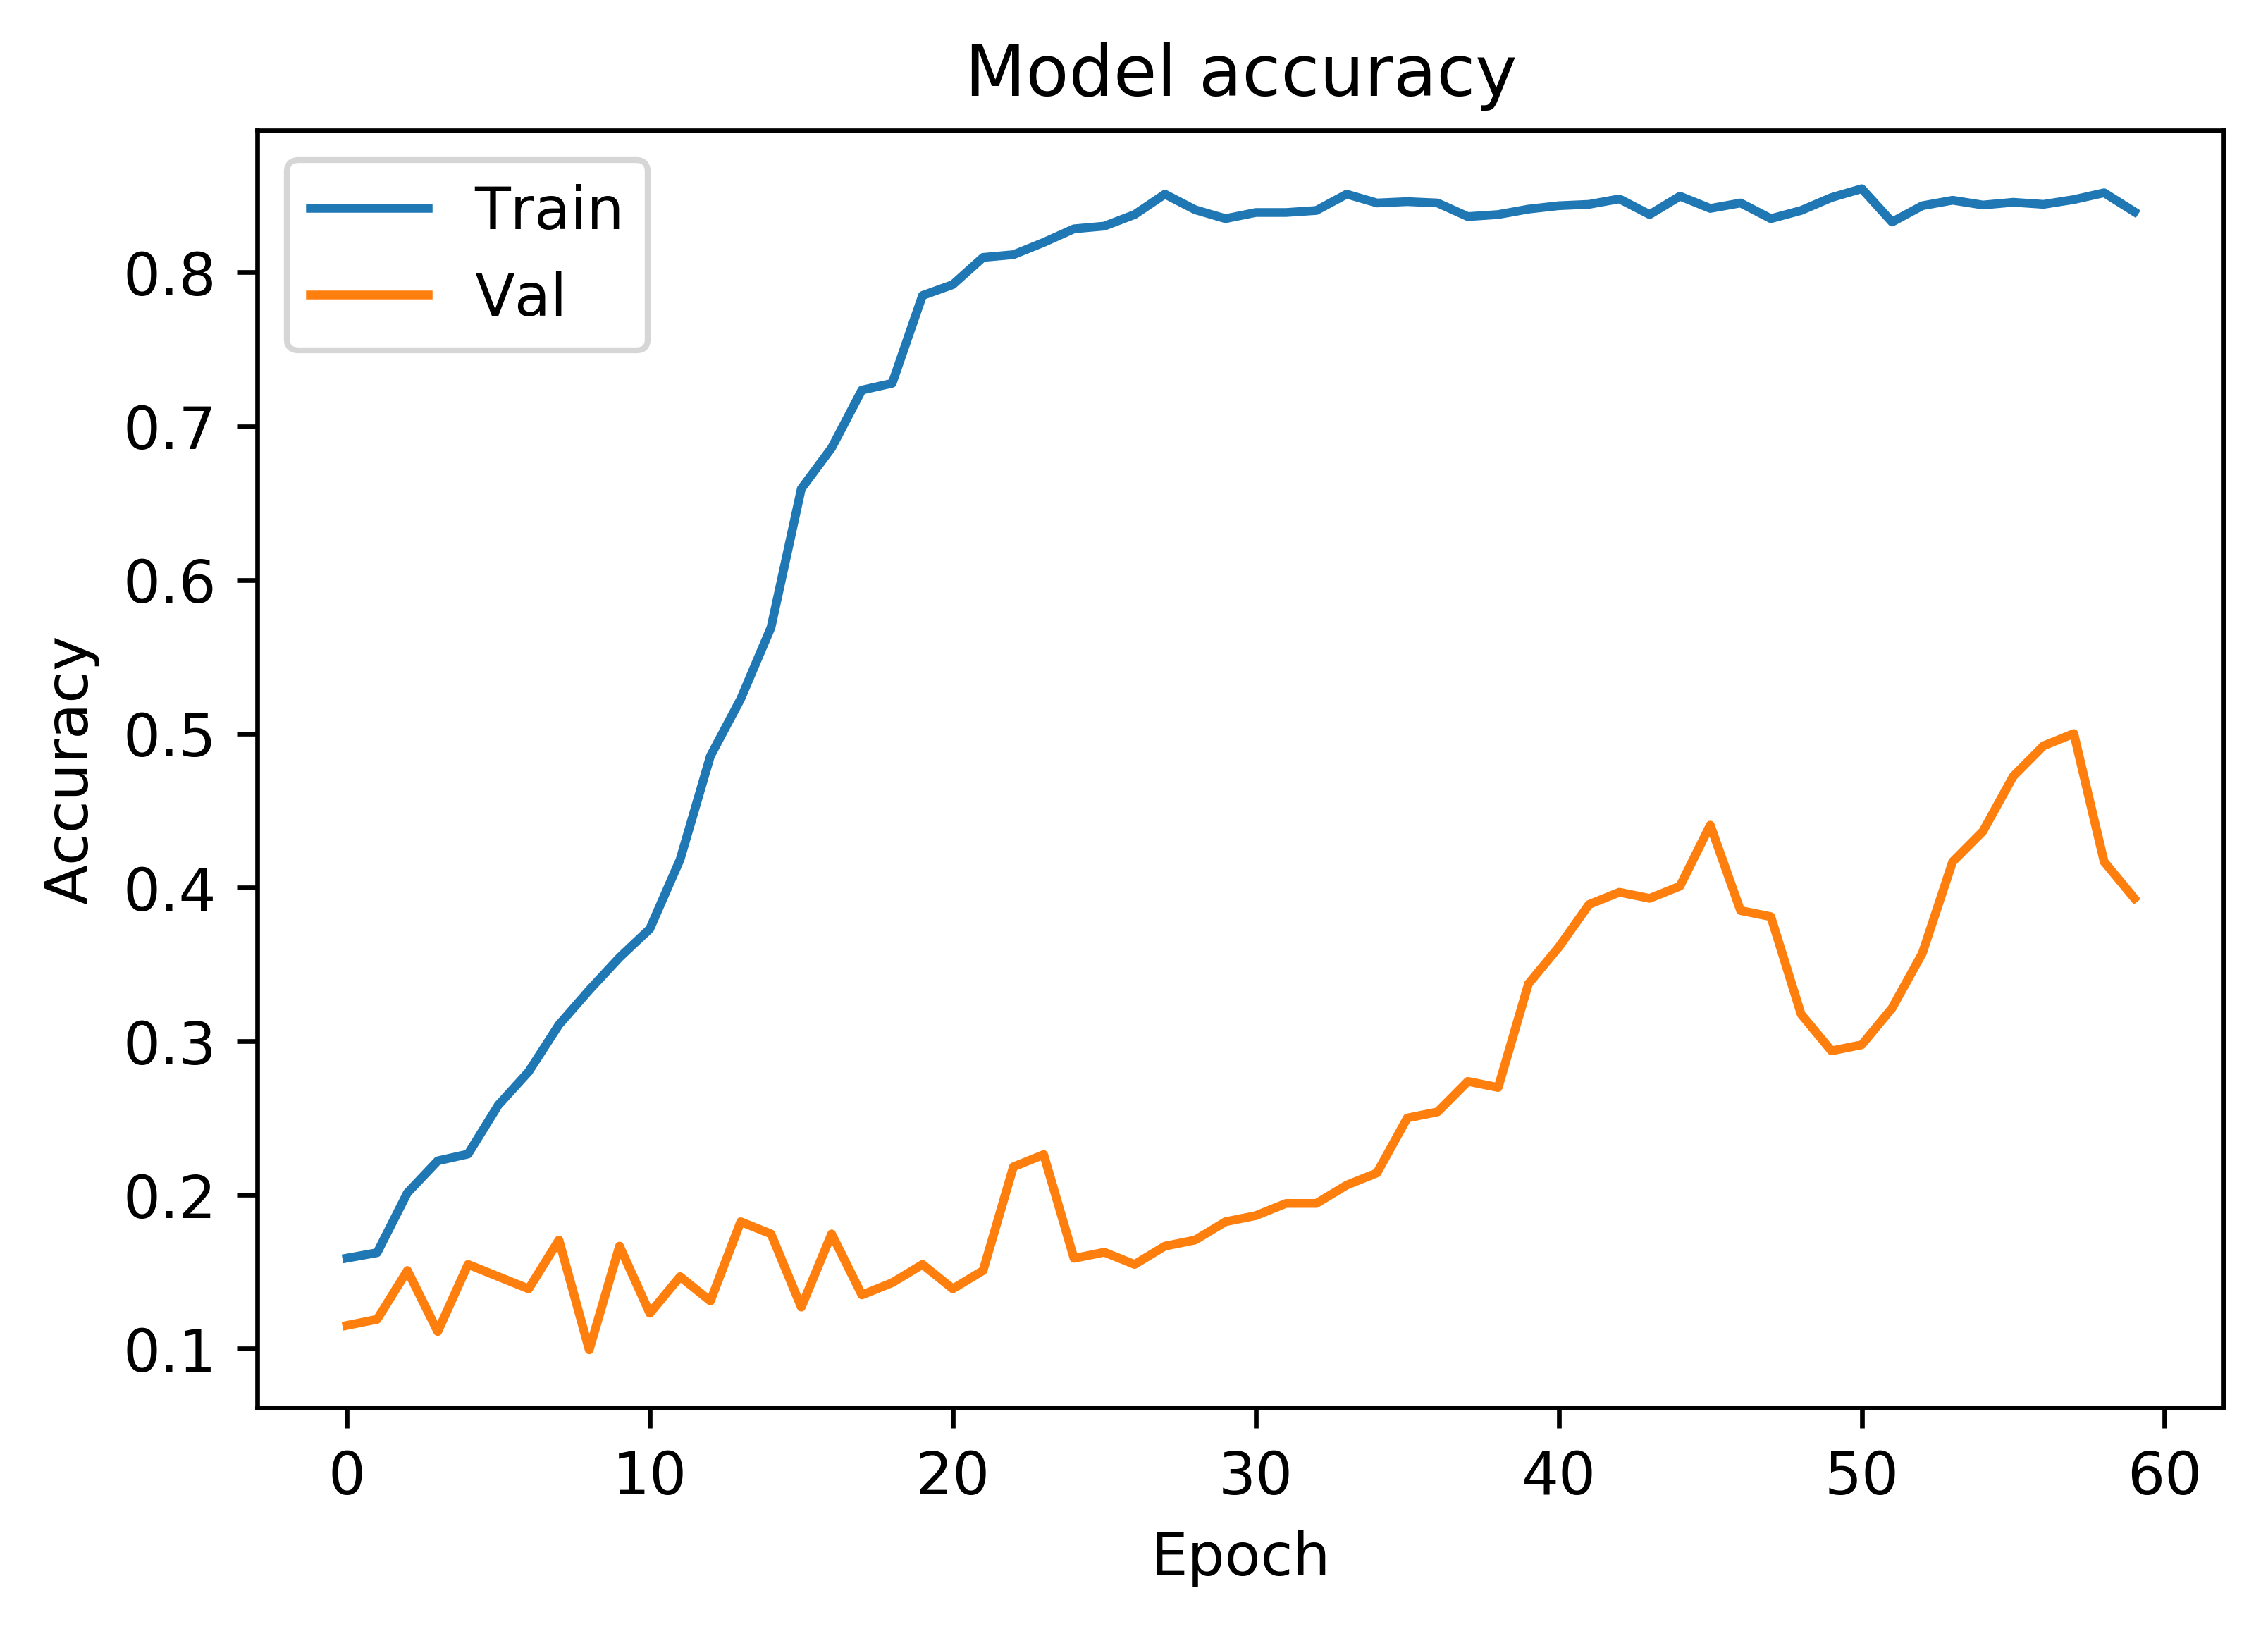

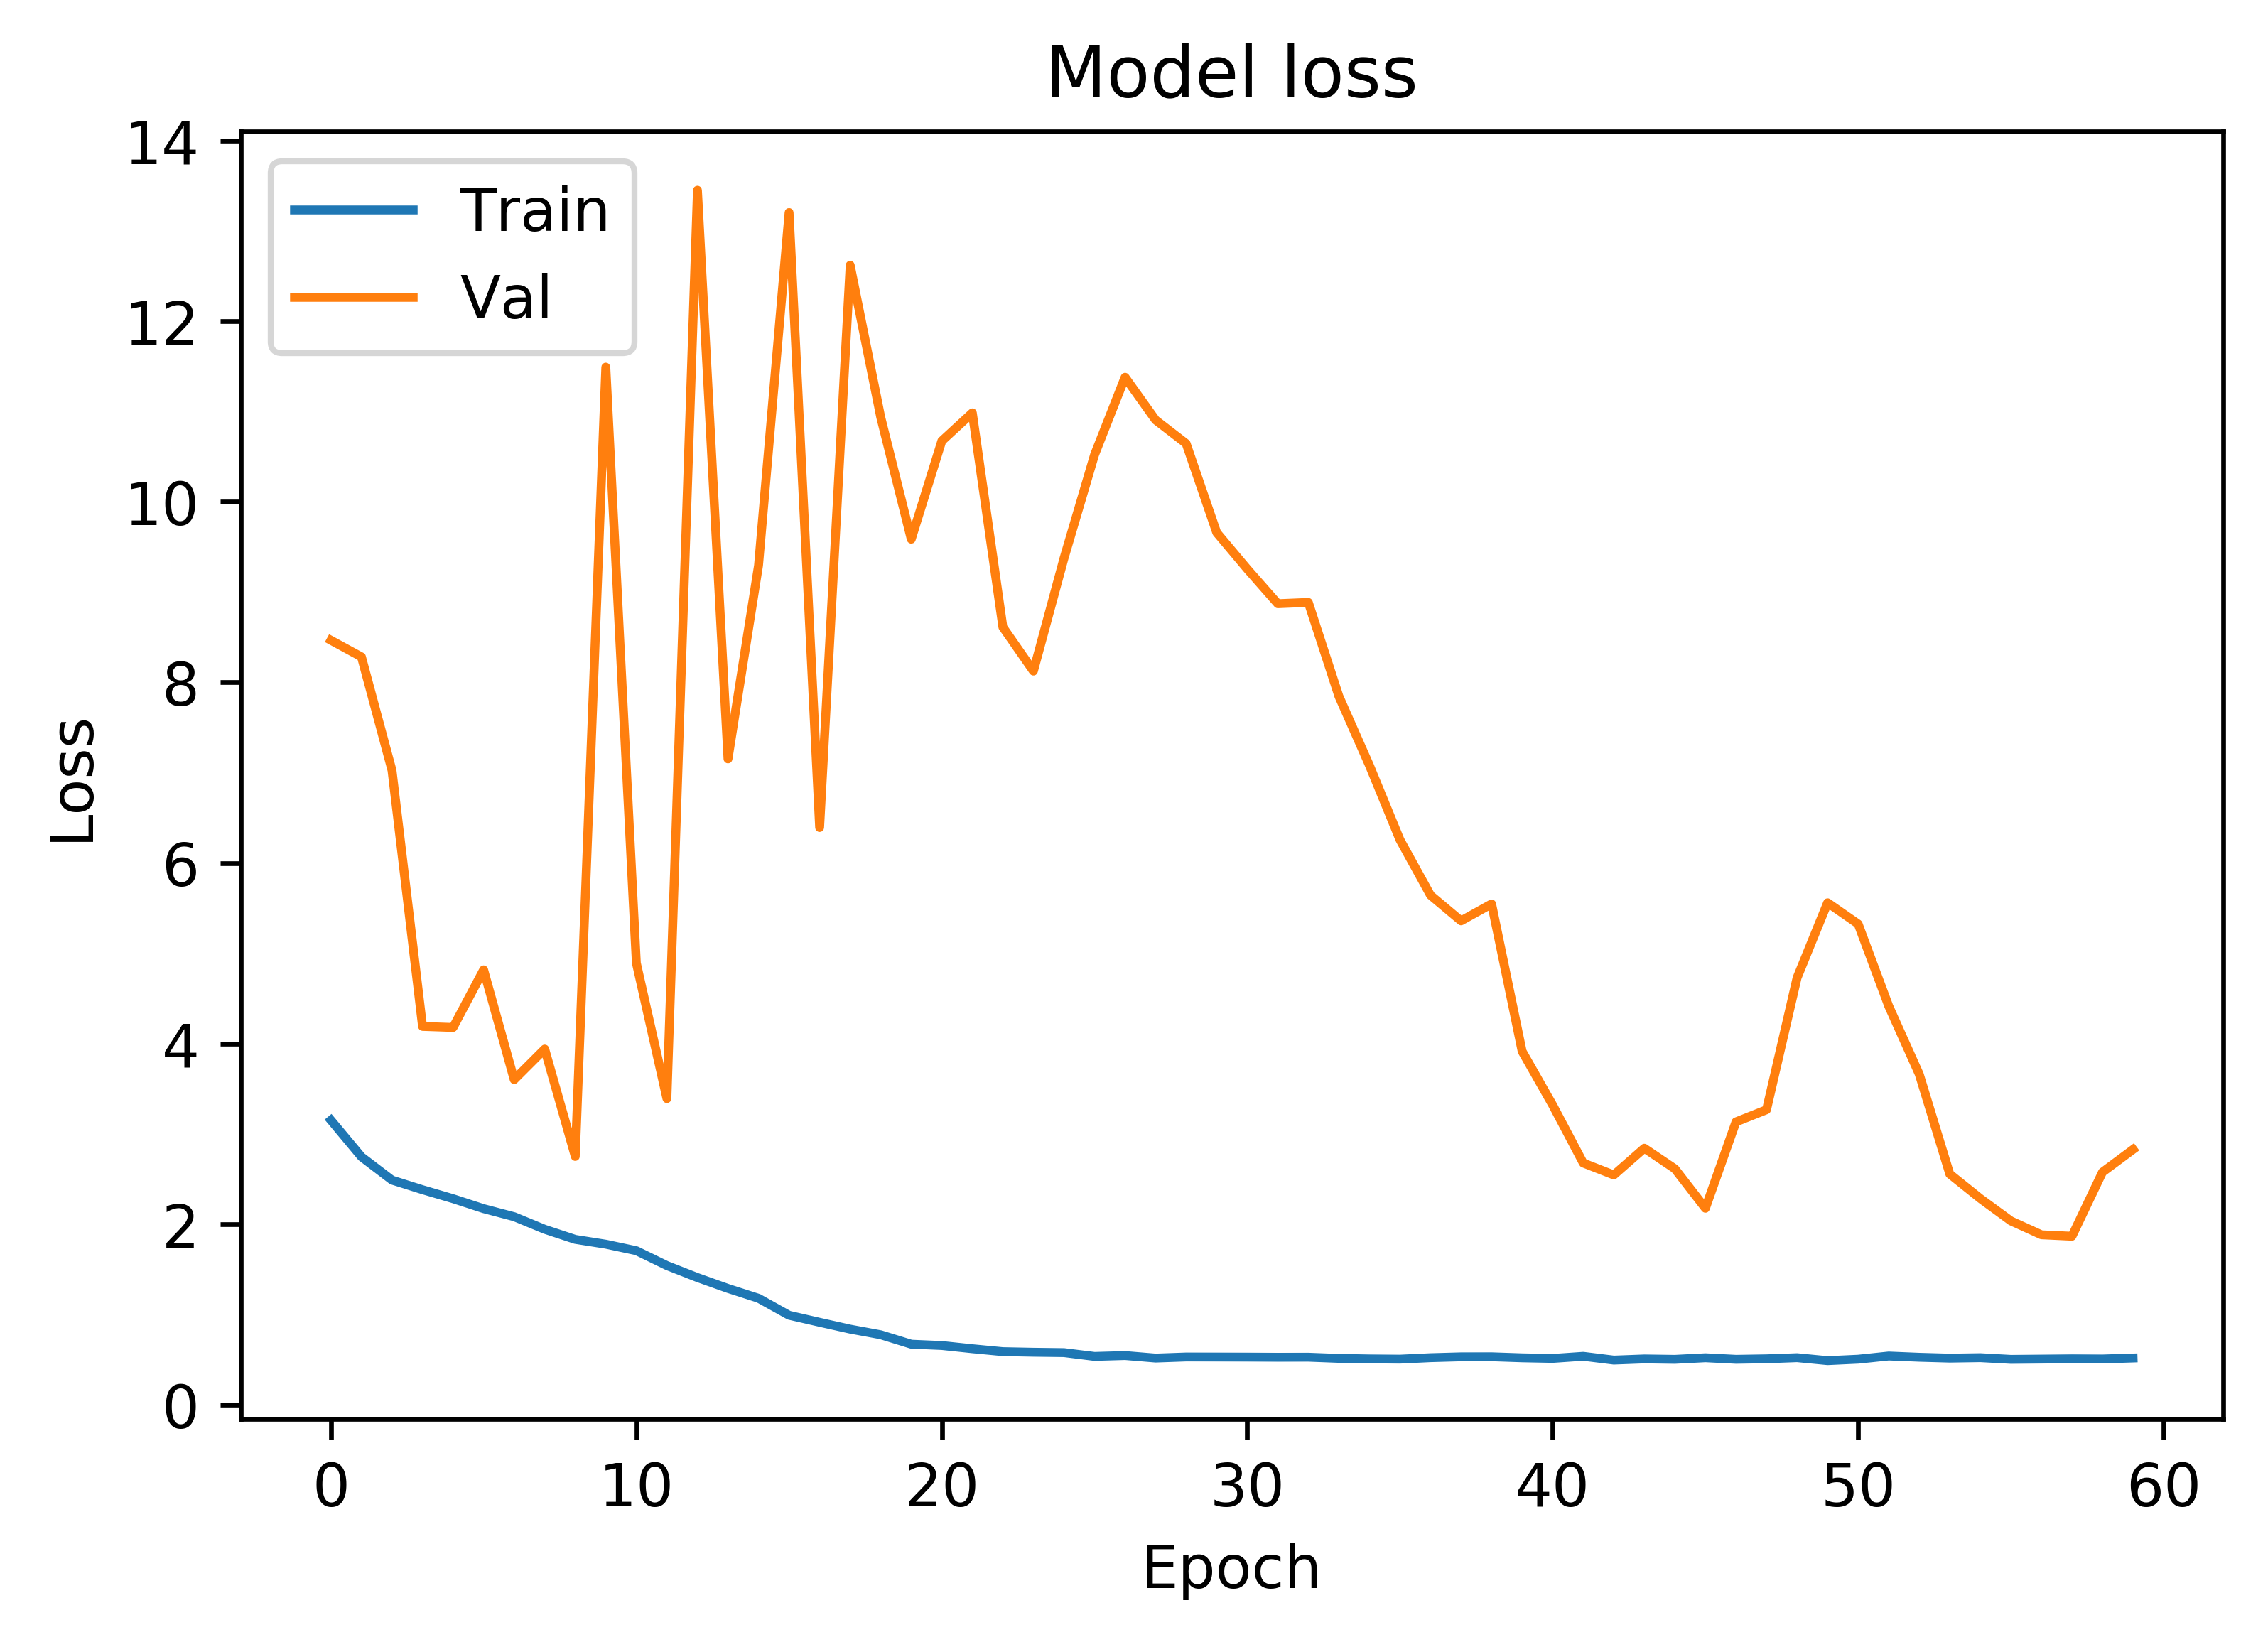

Results from K-fold: 1
acc: 34.34%
632/632 [==============================] - 1s 1ms/step
[3.0137936706784405, 0.34335442962525764]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         14   51        0    10          0         2     2          0
gel          5   62        0     8          0         3     1          0
network      0   56        5    14          0         3     0          1
plot         1   34        0    40          0         3     0          1
histology    0   47        0     0         24         8     0          0
sequence     2   27        0     2          0        48     0          0
line         0   62        0     6          0         0    11          0
molecular    0   60        0     2          0         4     0         13
              precision    recall  f1-score   support

         bar       0.64      0.18      0.28        79
         gel       0.16      0.78      0.26        79
     network       1.00      0.06      0.12     

2260/2260 [==============================] - 4s 2ms/step - loss: 0.9713 - acc: 0.6566 - val_loss: 8.3293 - val_acc: 0.1310

Epoch 00018: val_acc did not improve from 0.24206
Epoch 19/150
2260/2260 [==============================] - 4s 2ms/step - loss: 0.9546 - acc: 0.6527 - val_loss: 8.3934 - val_acc: 0.1349

Epoch 00019: val_acc did not improve from 0.24206
Epoch 20/150
2260/2260 [==============================] - 5s 2ms/step - loss: 0.8869 - acc: 0.6929 - val_loss: 8.5952 - val_acc: 0.1349

Epoch 00020: val_acc did not improve from 0.24206
Epoch 21/150
2260/2260 [==============================] - 4s 2ms/step - loss: 0.8321 - acc: 0.7004 - val_loss: 7.8239 - val_acc: 0.1468

Epoch 00021: val_acc did not improve from 0.24206
Epoch 22/150
2260/2260 [==============================] - 5s 2ms/step - loss: 0.8380 - acc: 0.7177 - val_loss: 6.5124 - val_acc: 0.1230

Epoch 00022: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00022: val_acc did not improve from 0.242

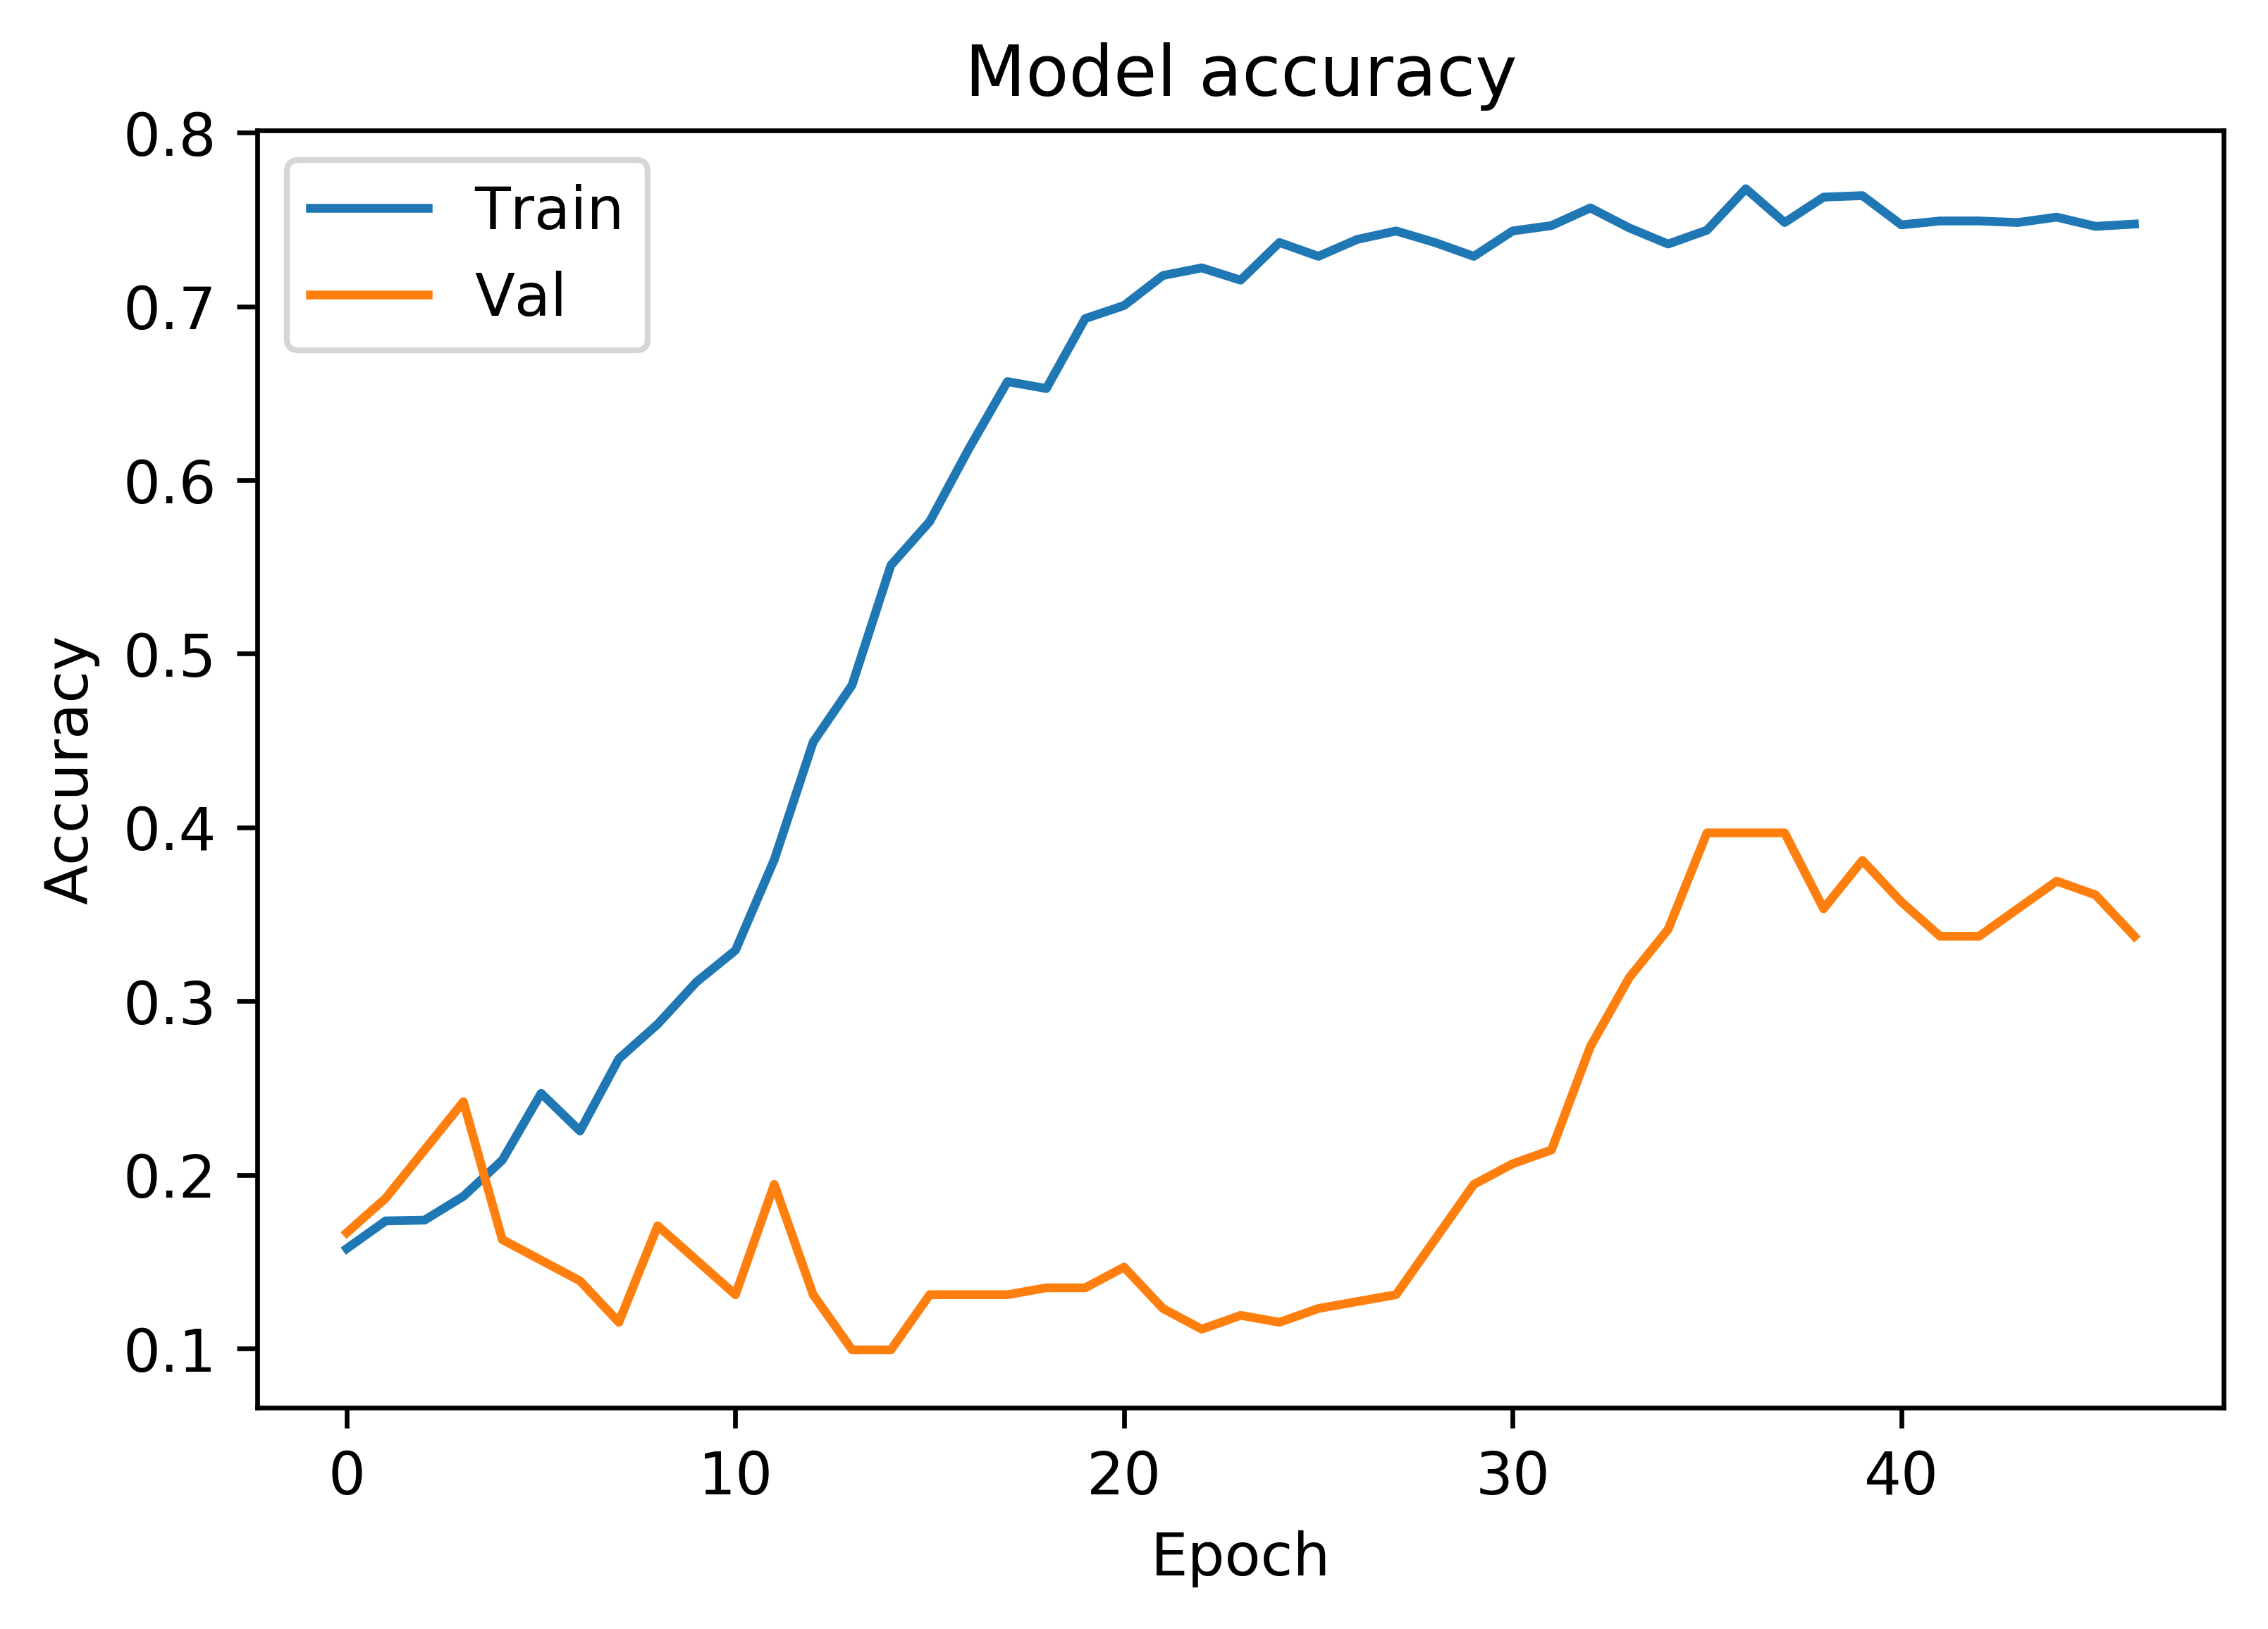

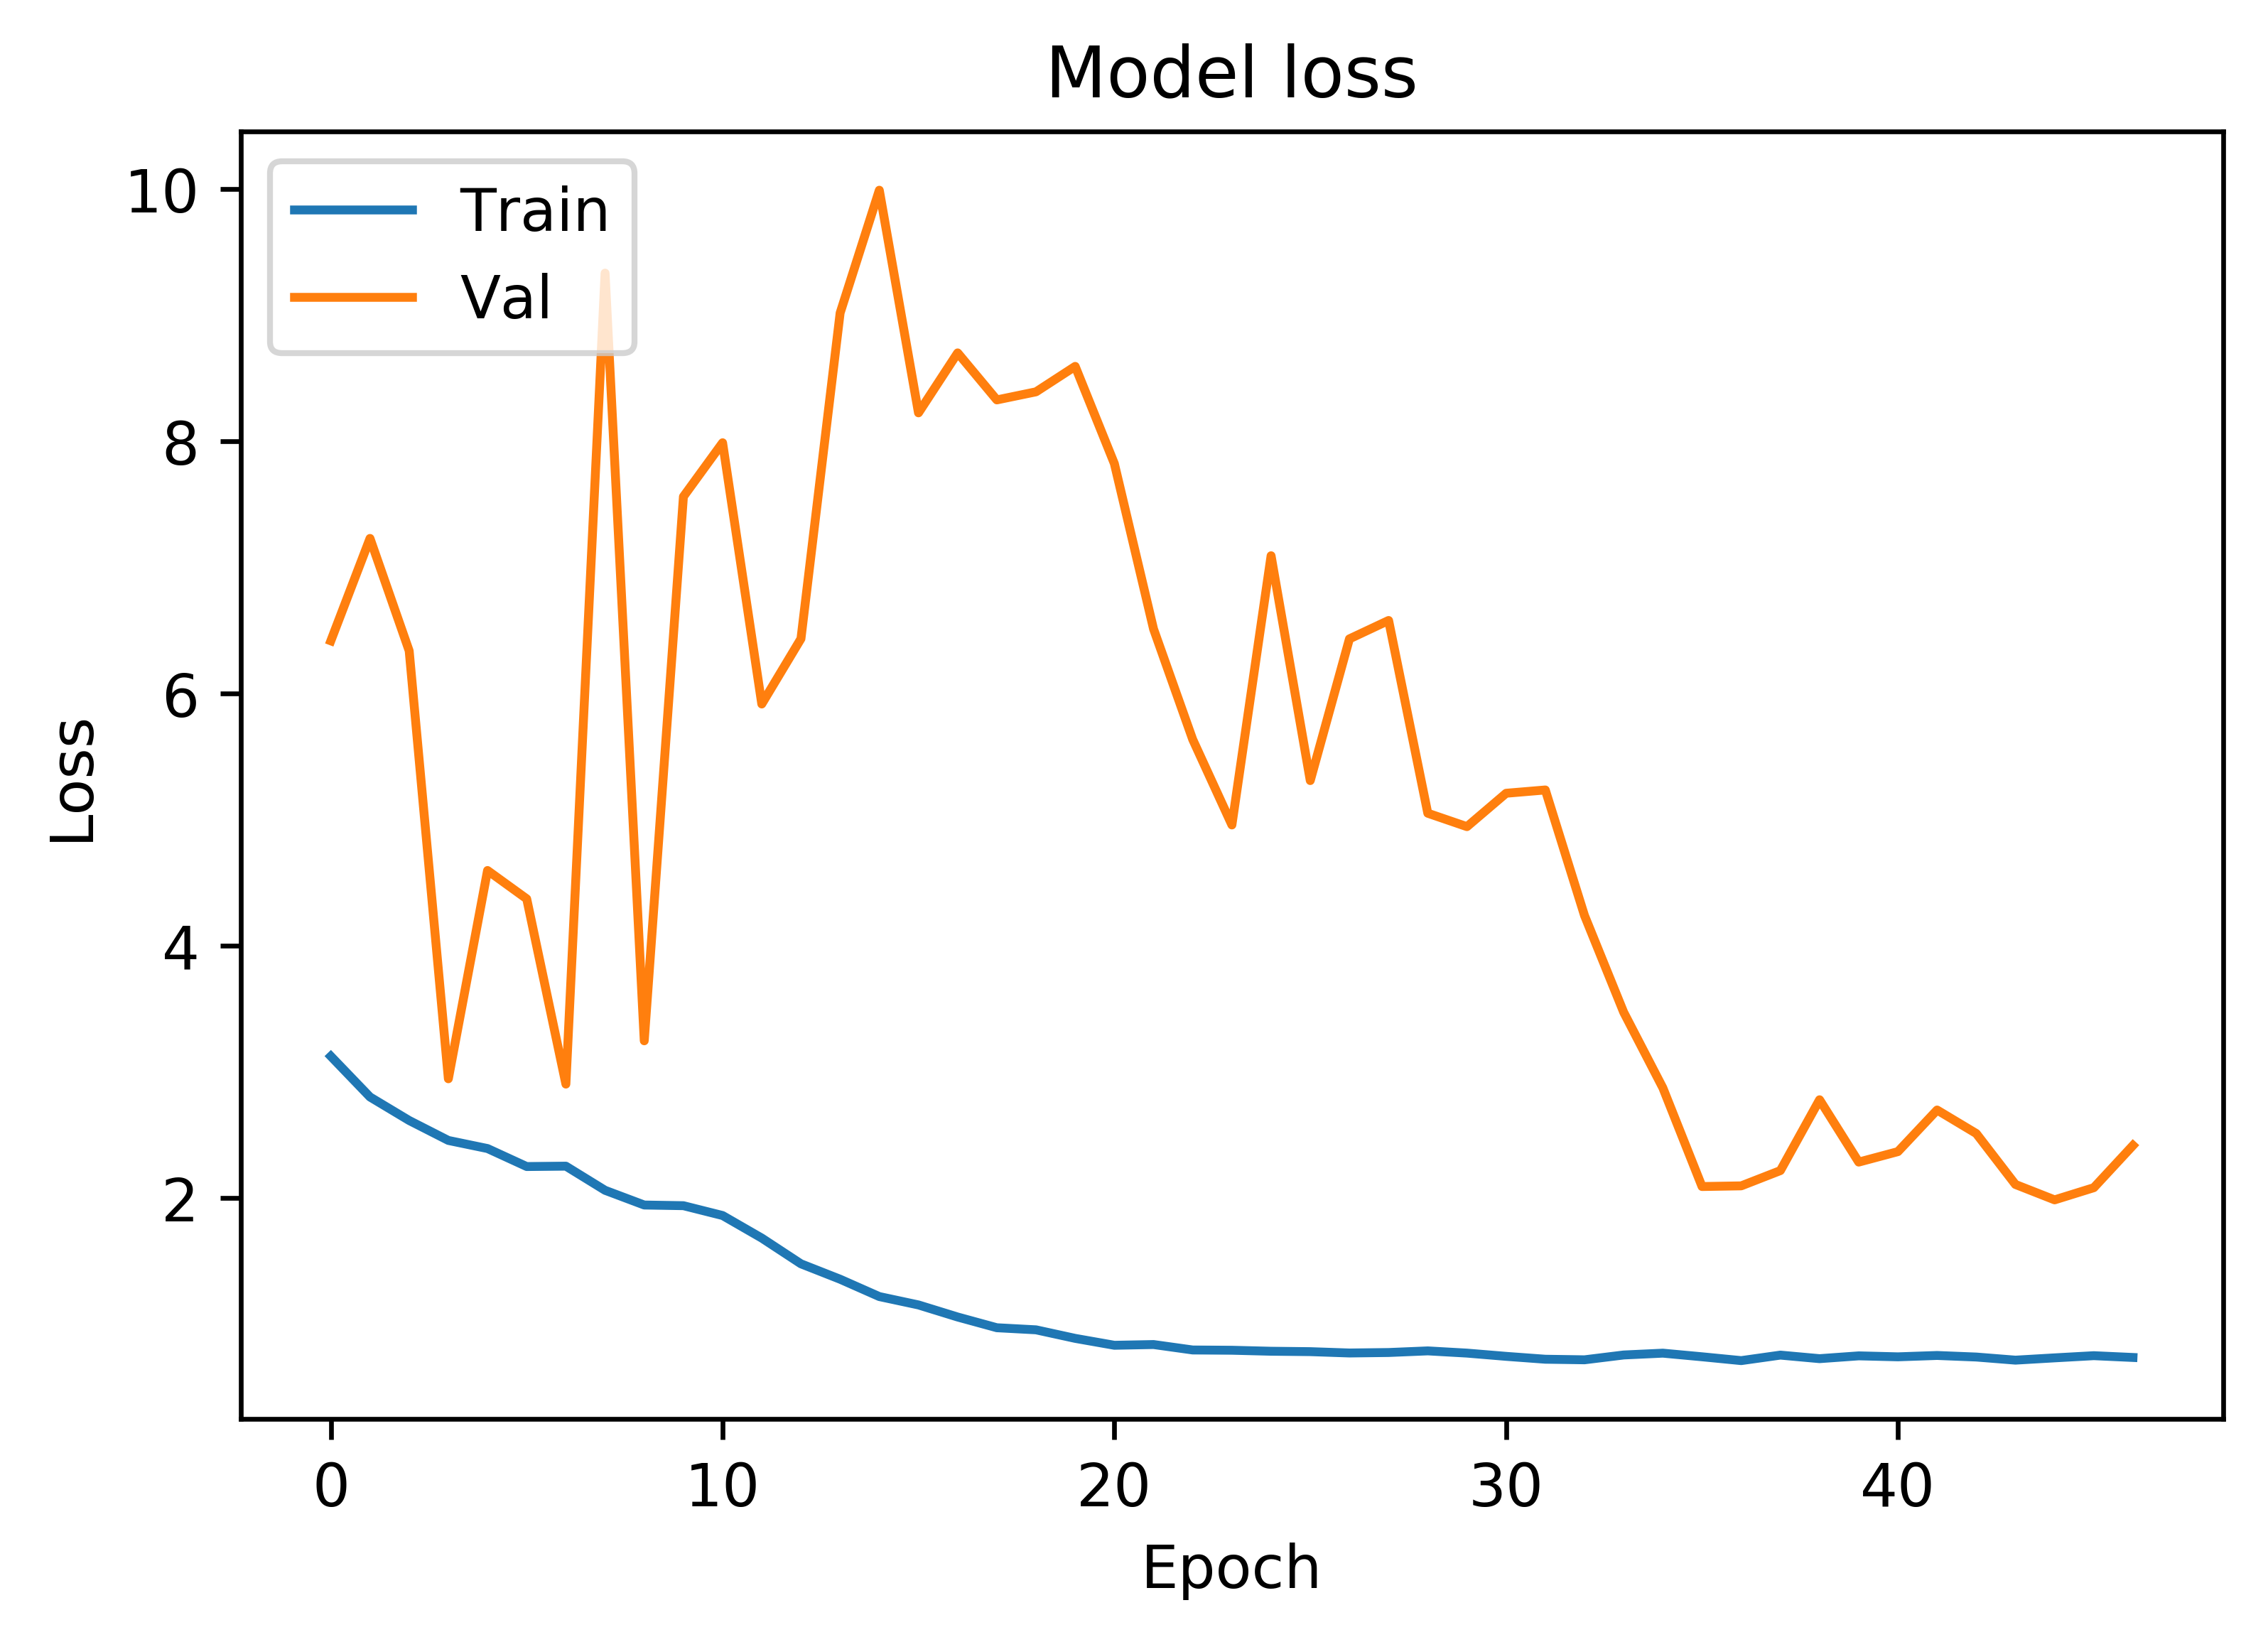

Results from K-fold: 2
acc: 35.28%
632/632 [==============================] - 1s 1ms/step
[2.361444068860404, 0.35284810164306735]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         29   32        0    11          0         7     0          0
gel         12   53        0    12          0         2     0          0
network      2   45        5    10          0        16     0          1
plot        15   21        0    40          0         3     0          0
histology    2   40        0     0         24        13     0          0
sequence     6   30        1     2          1        39     0          0
line         7   46        0     4          0         2    20          0
molecular    2   55        0     1          0         8     0         13
              precision    recall  f1-score   support

         bar       0.39      0.37      0.38        79
         gel       0.16      0.67      0.26        79
     network       0.83      0.06      0.12      

2260/2260 [==============================] - 5s 2ms/step - loss: 0.4353 - acc: 0.8659 - val_loss: 12.9304 - val_acc: 0.1190

Epoch 00025: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00025: val_acc did not improve from 0.23016
Epoch 26/150
2260/2260 [==============================] - 4s 2ms/step - loss: 0.4092 - acc: 0.8708 - val_loss: 12.8568 - val_acc: 0.1190

Epoch 00026: val_acc did not improve from 0.23016
Epoch 27/150
2260/2260 [==============================] - 4s 2ms/step - loss: 0.3932 - acc: 0.8836 - val_loss: 12.7153 - val_acc: 0.1230

Epoch 00027: val_acc did not improve from 0.23016
Epoch 28/150
2260/2260 [==============================] - 4s 2ms/step - loss: 0.3727 - acc: 0.8889 - val_loss: 12.4657 - val_acc: 0.1349

Epoch 00028: val_acc did not improve from 0.23016
Epoch 29/150
2260/2260 [==============================] - 4s 2ms/step - loss: 0.3883 - acc: 0.8827 - val_loss: 12.3057 - val_acc: 0.1548

Epoch 00029: val_acc did not improve from 

In [ ]:
#set K folds to 5
cvscores = []
count = 1
confusion_matrix_list = []
report_list = []

for key, val in kfolds.items():
    print(key)
    train = val['train']
    test = val['test']
    
    print('K-: {}'.format(key))
            
    print("Samples from Training")
    print_samples(samples=train, text=X_text, tokenizer=tokenizer)
    print("============================")
    
    print("Samples from Testing")
    print_samples(samples=test, text=X_text, tokenizer=tokenizer)
    print("============================")
    
    random.shuffle(train)
    text_model = Generate_Model(model_type = "text_2d")
    text_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    filepath="unimodal_weights/best_weight_text_2d_only_k-fold_{}.hdf5".format(count)
    checkpoint = MultiGPUCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [reduce_lr, checkpoint, early_stopping]

    history = text_model.fit([X_text[train]], y[train], 
                     epochs=epochs, batch_size=bs, validation_split=0.1, callbacks=callbacks_list)
    plot_model_history(history)
    filepath="unimodal_weights/final_weight_text_2d_only_k-fold_{}.hdf5".format(count)
    text_model.save_weights(filepath)
    scores = text_model.evaluate([X_text[test]], y[test], verbose=0)
    print('Results from K-fold: {}'.format(count))
    print("%s: %.2f%%" % (image_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    y_hat = test_model(text_model, zip(X_text[test], y[test]), image = False, text = True, 
                       class_names=class_names)
    cm = confusion_matrix([np.argmax(t) for t in y[test]], y_hat)
    confusion_matrix_list.append(pd.DataFrame(cm, index=class_names, columns=class_names))
    cr = classification_report([np.argmax(t) for t in y[test]], y_hat, target_names=class_names)
    report_list.append(classification_report_df(cr))
    count += 1
    print('================================================')
print('Average for kfold accuracy and stdev')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Average classification report for all folds")
print(df_mean(report_list))

In [ ]:
for key, val in folds.items():
    print(key)
    train = val['train']
    test = val['test']
    